In [2]:
import os
import re
from tqdm import tqdm
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 100)
from glob import glob
import matplotlib.pyplot as plt
from matplotlib import colormaps

## Convert Units

In [3]:
def parse_time(text):
    # 0:30.42 sec --> 0.5 (in minutes)
    # or 1:34.56 sec --> 1.57 (in minutes)
    # or 1:12:34.13 sec --> 72.57 (in minutes)
    if text.endswith(" sec"):
        text = text.split(" ")[0]  # Remove ' sec'
    parts = text.split(":")
    if len(parts) == 2:
        # Format: mm:ss
        minutes = float(parts[0])
        seconds = float(parts[1])
        return round(minutes + seconds / 60, 2)
    elif len(parts) == 3:
        # Format: hh:mm:ss
        hours = float(parts[0])
        minutes = float(parts[1])
        seconds = float(parts[2])
        return round(hours * 60 + minutes + seconds / 60, 2)

def convert_units(df):
    """
    Converts the specified columns in the DataFrame to appropriate units.
    """
    # Create a copy
    df = df.copy()

    # Ensure columns exist before attempting conversion
    if 'num_nodes' in df.columns:
        # 123456 --> 123.4 (in thousands)
        df['num_nodes'] = df['num_nodes'] / 1000
        df['num_nodes'] = df['num_nodes'].round(1)  # Round to 1 decimal places

    if 'num_edges' in df.columns:
        # 123456 --> 123.4 (in thousands)
        df['num_edges'] = df['num_edges'] / 1000
        df['num_edges'] = df['num_edges'].round(1)  # Round to 1 decimal places

    if 'train_data_size' in df.columns:
        # 880700 --> 880.7 (in thousands)
        df['train_data_size'] = df['train_data_size'] / 1000  # Convert to thousands
        df['train_data_size'] = df['train_data_size'].round(1)  # Round to 1 decimal places

    if 'test_data_size' in df.columns:
        # 880700 --> 880.7 (in thousands)
        df['test_data_size'] = df['test_data_size'] / 1000
        df['test_data_size'] = df['test_data_size'].round(1)  # Round to 1 decimal places

    if 'model_params' in df.columns:
        # 123456 --> 123.4 (in thousands)
        df['model_params'] = df['model_params'] / 1000  # Convert to thousands
        df['model_params'] = df['model_params'].round(1)  # Round to 1 decimal places

    if 'model_size' in df.columns:
        # "12 MB" --> 12 (in MB)
        df['model_size'] = df['model_size'].astype(str).str.replace(" MB", "").astype(float)

    if 'train_mre' in df.columns:
        # "5.12%" --> 5.12 (in percentage)
        df['train_mre'] = df['train_mre'].astype(str).str.rstrip('%')  # Remove % sign
        df['train_mre'] = df['train_mre'].astype(float)  # Convert to float
        df['train_mre'] = df['train_mre'].round(2)

    if 'test_mre' in df.columns:
        # "0.12%" --> 0.12 (in percentage)
        df['test_mre'] = df['test_mre'].astype(str).str.rstrip('%')  # Remove % sign
        df['test_mre'] = df['test_mre'].astype(float)  # Convert to float
        df['test_mre'] = df['test_mre'].round(2)

    if 'precomputation_time' in df.columns:
        # "12.23 minutes" --> 12.23 (in minutes)
        df['precomputation_time'] = df['precomputation_time'].astype(str).map(lambda x: x.split(" ")[0]).astype(float)  # Convert to float
        df['precomputation_time'] = df['precomputation_time'].round(2)

    if 'train_query_time' in df.columns:
        # "1.34 microseconds" --> 1.34 (in microseconds)
        df['train_query_time'] = df['train_query_time'].astype(str) \
                                    .map(lambda x: x.split(" ")[0]).astype(float)  # Convert to float
        # df['train_query_time'] = df['train_query_time'].round(2)

    if 'train_evaluation_time' in df.columns:
        # "0.08 minutes" --> 0.08 (in minutes)
        df['train_evaluation_time'] = df['train_evaluation_time'].astype(str) \
                                        .map(lambda x: x.split(" ")[0]).astype(float)

    if 'test_query_time' in df.columns:
        # "1.34 microseconds" --> 1.34 (in microseconds)
        df['test_query_time'] = df['test_query_time'].astype(str) \
                                    .map(lambda x: x.split(" ")[0]).astype(float)  # Convert to float
        # df['test_query_time'] = df['test_query_time'].round(2)

    if 'test_evaluation_time' in df.columns:
        # "0.08 minutes" --> 0.08 (in minutes)
        df['test_evaluation_time'] = df['test_evaluation_time'].astype(str) \
                                        .map(lambda x: x.split(" ")[0]).astype(float)

    if 'max_cpu_memory' in df.columns:
        # "840376 KB" --> 0.84 (in GB)
        df['max_cpu_memory'] = df['max_cpu_memory'].astype(str) \
                                .map(lambda x: int(x.split(" ")[0])/ (1024 * 1024))  # Convert to GB
        df['max_cpu_memory'] = df['max_cpu_memory'].round(2)

    if 'time_elapsed' in df.columns:
        # "0:30.42 sec" --> 0.5 (in minutes)
        # df['time_elapsed'] = df['time_elapsed'].astype(str).str.rstrip(' sec')  # Remove sec
        # df['time_elapsed'] = df['time_elapsed'].map(lambda x: float(x.split(":")[0]) + float(x.split(":")[1])/60)  # Convert to minutes
        # df['time_elapsed'] = df['time_elapsed'].round(2)
        df['time_elapsed'] = df['time_elapsed'].astype(str).map(parse_time)

    # 'average_query_time': '0.62 microseconds'
    if 'average_query_time' in df.columns:
        # "0.62 microseconds" --> 0.62 (in microseconds)
        df['average_query_time'] = df['average_query_time'].astype(str) \
                                        .map(lambda x: x.split(" ")[0]).astype(float)  # Convert to float

    return df

In [4]:
## Version 3 ##

def parse_catboost_time(text):
    """
    Converts CatBoost time strings like '2.72s', '1m 44s', '5m 20s' to minutes (float).
    """
    text = text.strip()
    if text.endswith('ms'):
        # Format: '23.40ms'
        ms = float(text[:-2])
        return round(ms / 1000 / 60, 6)
    elif text.endswith('s') and not any(x in text for x in ['m', 'h']):
        # Format: '2.72s'
        seconds = float(text[:-1])
        return round(seconds / 60, 4)
    elif 'm' in text and 's' in text:
        # Format: '1m 44s'
        parts = text.split('m')
        minutes = float(parts[0])
        seconds = float(parts[1].replace('s', '').strip())
        return round(minutes + seconds / 60, 4)
    elif 'h' in text:
        # Format: '1h 12m 34s'
        h, rest = text.split('h')
        hours = float(h)
        if 'm' in rest and 's' in rest:
            m, s = rest.split('m')
            minutes = float(m)
            seconds = float(s.replace('s', '').strip())
            return round(hours * 60 + minutes + seconds / 60, 4)
        elif 'm' in rest:
            minutes = float(rest.replace('m', '').strip())
            return round(hours * 60 + minutes, 4)
    elif 'm' in text:
        # Format: '5m'
        minutes = float(text.replace('m', '').strip())
        return round(minutes, 4)
    return None

def parse_worker_log(log_file):
    """
    Parses the worker log file and extracts the required information.
    """
    result = {}
    #### Command line arguments ####
    model_class = None
    model_name = None
    data_name = None
    query_name = None
    batch_size_train = None
    batch_size_test = None
    learning_rate = None
    epochs = None
    eval_runs = None
    seed = None
    num_workers = None
    embedding_dim = None
    p_norm = None
    landmark_selection = None
    gnn_layer = None
    disable_edge_weight = None

    #### Graph statistics ####
    num_nodes = None
    num_edges = None

    #### Train and Test Data Statistics ####
    in_train = None
    train_data_size = None
    test_data_size = None
    train_data_distance_mean = None
    test_data_distance_mean = None

    #### Model Architecture ####
    model_params = None
    loss_function = None
    optimizer = None
    gpu_name = None
    device = None
    precomputation_time = None
    model_size = None

    #### Train Metrics ####
    train_evaluation_time = None
    train_query_time = None
    train_mae = None
    train_mre = None
    train_mre_bucket1 = None
    train_mre_bucket2 = None
    train_mre_bucket3 = None
    train_mre_bucket4 = None
    train_mre_bucket5 = None
    train_loss_history = []
    val_mre_history = []
    time_elapsed_history = []
    epoch_history = []

    #### Test Metrics ####
    test_evaluation_time = None
    test_query_time = None
    test_mae = None
    test_mre = None
    test_mre_bucket1 = None
    test_mre_bucket2 = None
    test_mre_bucket3 = None
    test_mre_bucket4 = None
    test_mre_bucket5 = None

    #### Misc ####
    average_query_time = None

    with open(log_file, 'r') as file:
        lines = file.readlines()
        for line in lines:
            #### Command line arguments ####
            # - model_class         : rgnndist2vec
            if re.match(r"  - model_class\s*: ", line) and model_class is None:
                model_class = re.split(r"  - model_class\s*: ", line)[1].strip()
                result['model_class'] = model_class

            # - model_name          : GCN
            if re.match(r"  - model_name\s*: ", line) and model_name is None:
                model_name = re.split(r"  - model_name\s*: ", line)[1].strip()
                result['model_name'] = model_name

            # - data_dir            : ../data/W_Chengdu/
            if re.match(r"  - data_dir\s*: ", line) and data_name is None:
                data_name = re.split(r"  - data_dir\s*: ", line)[1].strip()
                data_name = os.path.basename(os.path.normpath(data_name))  # Get the last part of the path
                result['data_name'] = data_name

            # - query_dir           : ../data/W_Chengdu/real_workload/
            if re.match(r"  - query_dir\s*: ", line) and query_name is None:
                query_name = re.split(r"  - query_dir\s*: ", line)[1].strip()
                query_name = os.path.basename(os.path.normpath(query_name))  # Get the last part of the path
                result['query_name'] = query_name

            # - batch_size_train    : 1024
            if re.match(r"  - batch_size_train\s*: ", line) and batch_size_train is None:
                batch_size_train = re.split(r"  - batch_size_train\s*: ", line)[1].strip()
                batch_size_train = int(batch_size_train)
                result['batch_size_train'] = batch_size_train

            # - batch_size_test     : 1048576
            if re.match(r"  - batch_size_test\s*: ", line) and batch_size_test is None:
                batch_size_test = re.split(r"  - batch_size_test\s*: ", line)[1].strip()
                batch_size_test = int(batch_size_test)
                result['batch_size_test'] = batch_size_test

            # - learning_rate       : 0.001
            if re.match(r"  - learning_rate\s*: ", line) and learning_rate is None:
                learning_rate = re.split(r"  - learning_rate\s*: ", line)[1].strip()
                learning_rate = float(learning_rate)
                result['learning_rate'] = learning_rate

            # - epochs              : 20
            if re.match(r"  - epochs\s*: ", line) and epochs is None:
                epochs = re.split(r"  - epochs\s*: ", line)[1].strip()
                epochs = int(epochs)
                result['epochs'] = epochs

            # - eval_runs           : 10
            if re.match(r"  - eval_runs\s*: ", line) and eval_runs is None:
                eval_runs = re.split(r"  - eval_runs\s*: ", line)[1].strip()
                eval_runs = int(eval_runs)
                result['eval_runs'] = eval_runs

            # - seed                : 42
            if re.match(r"  - seed\s*: ", line) and seed is None:
                seed = re.split(r"  - seed\s*: ", line)[1].strip()
                seed = int(seed)
                result['seed'] = seed

            # - num_workers         : 16
            if re.match(r"  - num_workers\s*: ", line) and num_workers is None:
                num_workers = re.split(r"  - num_workers\s*: ", line)[1].strip()
                num_workers = int(num_workers)
                result['num_workers'] = num_workers

            # - embedding_dim       : 64
            if re.match(r"  - embedding_dim\s*: ", line) and embedding_dim is None:
                embedding_dim = re.split(r"  - embedding_dim\s*: ", line)[1].strip()
                embedding_dim = int(embedding_dim)
                result['embedding_dim'] = embedding_dim

            # - p_norm              : 1
            if re.match(r"  - p_norm\s*: ", line) and p_norm is None:
                p_norm = re.split(r"  - p_norm\s*: ", line)[1].strip()
                p_norm = int(p_norm)
                result['p_norm'] = p_norm

            # - landmark_selection  : random
            if re.match(r"  - landmark_selection\s*: ", line) and landmark_selection is None:
                landmark_selection = re.split(r"  - landmark_selection\s*: ", line)[1].strip()
                result['landmark_selection'] = landmark_selection

            # - gnn_layer           : gcn
            if re.match(r"  - gnn_layer\s*: ", line) and gnn_layer is None:
                gnn_layer = re.split(r"  - gnn_layer\s*: ", line)[1].strip()
                result['gnn_layer'] = gnn_layer

            # - disable_edge_weight : True
            if re.match(r"  - disable_edge_weight\s*: ", line) and disable_edge_weight is None:
                disable_edge_weight = re.split(r"  - disable_edge_weight\s*: ", line)[1].strip()
                disable_edge_weight = disable_edge_weight == "True"
                result['disable_edge_weight'] = disable_edge_weight

            #### Check graph statistics ####
            if num_nodes is None and line.startswith("  - No. of nodes: "):
                num_nodes = line.split("  - No. of nodes: ")[1].strip()
                num_nodes = int(num_nodes)
                result['num_nodes'] = num_nodes

            if num_edges is None and line.startswith("  - No. of edges: "):
                num_edges = line.split("  - No. of edges: ")[1].strip()
                num_edges = int(num_edges)
                result['num_edges'] = num_edges

            #### Train Data Statistics ####
            # Check train dataset loading
            if line.startswith("Train dataset...") or line.startswith("Loading train dataset..."):
                in_train = True

            if line.startswith("Augmented Train dataset...") or line.startswith("Loading train dataset..."):
                in_train = True
                train_data_size = None
                train_data_distance_mean = None

            #   - No. of samples: 15226
            if train_data_size is None and in_train and line.startswith("  - No. of samples: "):
                train_data_size = line.split("  - No. of samples: ")[1].strip()
                train_data_size = int(train_data_size)
                result['train_data_size'] = train_data_size

            # - Mean/Std distance: 15653.64/14355.13
            if train_data_distance_mean is None and in_train and line.startswith("  - Mean/Std distance: "):
                train_data_distance_mean = line.split("  - Mean/Std distance: ")[1].strip()
                train_data_distance_mean = train_data_distance_mean.split("/")[0].strip()
                train_data_distance_mean = float(train_data_distance_mean)
                result['train_data_distance_mean'] = train_data_distance_mean

            #### Test Data Statistics ####
            # Check test dataset loading
            if line.startswith("Test dataset...") or line.startswith("Loading test dataset..."):
                in_train = False

            #   - No. of samples: 15226
            if test_data_size is None and not in_train and line.startswith("  - No. of samples: "):
                test_data_size = line.split("  - No. of samples: ")[1].strip()
                test_data_size = int(test_data_size)
                result['test_data_size'] = test_data_size

            # - Mean/Std distance: 15653.64/14355.13
            if test_data_distance_mean is None and not in_train and line.startswith("  - Mean/Std distance: "):
                test_data_distance_mean = line.split("  - Mean/Std distance: ")[1].strip()
                test_data_distance_mean = test_data_distance_mean.split("/")[0].strip()
                test_data_distance_mean = float(test_data_distance_mean)
                result['test_data_distance_mean'] = test_data_distance_mean

            #### Model Architecture ####
            # Model parameters size: 34368
            if model_params is None and line.startswith("Model parameters size: "):
                model_params = line.split("Model parameters size: ")[1].strip()
                model_params = int(model_params)
                result['model_params'] = model_params

            # Loss function: MSELoss()
            if loss_function is None and line.startswith("Loss function: "):
                loss_function = line.split("Loss function: ")[1].strip()
                result['loss_function'] = loss_function.strip("()")

            # Optimizer: Adam (
            if optimizer is None and line.startswith("Optimizer: "):
                optimizer = line.split("Optimizer: ")[1].strip().split()[0]
                result['optimizer'] = optimizer

            # GPU Detected: NVIDIA A30
            if gpu_name is None and line.startswith("GPU Detected: "):
                gpu_name = line.split("GPU Detected: ")[1].strip()
                result['gpu_name'] = gpu_name

            # Using Device: cuda
            if device is None and line.startswith("Using Device: "):
                device = line.split("Using Device: ")[1].strip()
                result['device'] = device

            # Precomputation time: 2.62 minutes
            if precomputation_time is None and line.startswith("Precomputation time: "):
                precomputation_time = line.split("Precomputation time: ")[1].strip()
                result['precomputation_time'] = precomputation_time

            #   - Model size: 6.57 MB
            if model_size is None and line.startswith("  - Model size: "):
                model_size = line.split("  - Model size: ")[1].strip()
                result['model_size'] = model_size

            #### Train Metrics ####
            # Check train evaluation metrics
            if line.startswith("Evaluation on train Finished!"):
                in_train = True

            # Evaluation time: 0.08 minutes
            if train_evaluation_time is None and in_train and line.startswith("Evaluation time: "):
                train_evaluation_time = line.split("Evaluation time: ")[1].strip()
                result['train_evaluation_time'] = train_evaluation_time

            # Query time per sample: 1.47 microseconds
            if train_query_time is None and line.startswith("Query time per sample: "):
                train_query_time = line.split("Query time per sample: ")[1].strip()
                result['train_query_time'] = train_query_time

            # Mean Absolute Error: 8616.94
            if train_mae is None and line.startswith("Mean Absolute Error: "):
                train_mae = line.split("Mean Absolute Error: ")[1].strip()
                result['train_mae'] = float(train_mae)

            # Mean Relative Error: 90.12%
            if train_mre is None and line.startswith("Mean Relative Error: "):
                train_mre = line.split("Mean Relative Error: ")[1].strip()
                result['train_mre'] = train_mre

            # Bucket 1: 11 - 32939, Local MRE: 5.96%, Fraction of data samples in this bucket: 56.56%
            if train_mre_bucket1 is None and in_train and line.startswith("Bucket 1: "):
                train_mre_bucket1 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['train_mre_bucket1'] = float(train_mre_bucket1[:-1])  # Remove % sign
            if train_mre_bucket2 is None and in_train and line.startswith("Bucket 2: "):
                train_mre_bucket2 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['train_mre_bucket2'] = float(train_mre_bucket2[:-1])  # Remove % sign
            if train_mre_bucket3 is None and in_train and line.startswith("Bucket 3: "):
                train_mre_bucket3 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['train_mre_bucket3'] = float(train_mre_bucket3[:-1])  # Remove % sign
            if train_mre_bucket4 is None and in_train and line.startswith("Bucket 4: "):
                train_mre_bucket4 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['train_mre_bucket4'] = float(train_mre_bucket4[:-1])  # Remove % sign
            if train_mre_bucket5 is None and in_train and line.startswith("Bucket 5: "):
                train_mre_bucket5 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['train_mre_bucket5'] = float(train_mre_bucket5[:-1])  # Remove % sign

            # With VALIDATION
            # Epoch:  1/12000, Time elapsed/remaining/total: 0.09/1084.90/1084.99 min, Train Loss:   0.16734625, Val MRE: 9.94%
            # Without VALIDATION
            # Epoch:  1/2, Time elapsed/remaining/total: 0.03/0.03/0.07 min, Train Loss:   2800323.56
            if model_class != "catboost" and "Time elapsed/remaining/total:" in line:
                epoch_match = re.search(r"Epoch:\s+(\d+)/\d+", line)
                time_elapsed_match = re.search(r"Time elapsed/remaining/total:\s+([\d.]+)/", line)
                train_loss_match = re.search(r"Train Loss:\s+([\d.]+)", line)
                val_mre_match = re.search(r"Val MRE:\s+([\d.]+)%", line)

                if epoch_match:
                    epoch = int(epoch_match.group(1))  # current epoch
                    epoch_history.append(epoch)
                    result['epoch_history'] = epoch_history

                if time_elapsed_match:
                    time_elapsed = float(time_elapsed_match.group(1))  # in minutes
                    time_elapsed_history.append(time_elapsed)
                    result['time_elapsed_history'] = time_elapsed_history

                if train_loss_match:
                    train_loss = float(train_loss_match.group(1))  # train loss
                    train_loss_history.append(train_loss)
                    result['train_loss_history'] = train_loss_history

                if val_mre_match:
                    val_mre = float(val_mre_match.group(1))  # val mre in %
                    val_mre_history.append(val_mre)
                    result['val_mre_history'] = val_mre_history
                    result['val_best_mre'] = min(val_mre_history)  # Best val mre so far

            # With VALIDATION
            # 100:	learn: 0.0687108	test: 0.0688295	best: 0.0687909 (99)	total: 2.72s	remaining: 5m 20s
            # 4000:	learn: 0.0192793	test: 0.0226579	best: 0.0226579 (4000)	total: 1m 44s	remaining: 3m 28s
            # Without VALIDATION
            # 100:    learn: 0.6710179        total: 2.64s    remaining: 10.4s
            elif model_class == "catboost" and "total:" in line and "remaining:" in line:
                epoch_match = re.search(r"(\d+):\s+learn:", line)
                time_elapsed_match = re.search(r"total:\s*(.*?)\s*remaining:", line)
                train_loss_match = re.search(r"learn:\s+([\d.]+)", line)
                val_mre_match = re.search(r"test:\s+([\d.]+)", line)

                if epoch_match:
                    epoch = int(epoch_match.group(1))  # current epoch
                    epoch_history.append(epoch)
                    result['epoch_history'] = epoch_history

                if time_elapsed_match:
                    time_elapsed_str = time_elapsed_match.group(1)  # e.g., '2.72s' or '1m 44s'
                    time_elapsed = parse_catboost_time(time_elapsed_str)  # in minutes
                    time_elapsed_history.append(time_elapsed)
                    result['time_elapsed_history'] = time_elapsed_history

                if train_loss_match:
                    train_loss = float(train_loss_match.group(1))  # train loss
                    train_loss_history.append(train_loss)
                    result['train_loss_history'] = train_loss_history

                if val_mre_match:
                    val_mre = round(float(val_mre_match.group(1))*100, 2)  # val mre in %
                    val_mre_history.append(val_mre)
                    result['val_mre_history'] = val_mre_history
                    result['val_best_mre'] = min(val_mre_history)  # Best val mre so far

            #### Test Metrics ####
            # Check test evaluation metrics
            if line.startswith("Evaluation on test Finished!"):
                in_train = False

            # Evaluation time: 0.08 minutes
            if test_evaluation_time is None and not in_train and line.startswith("Evaluation time: "):
                test_evaluation_time = line.split("Evaluation time: ")[1].strip()
                result['test_evaluation_time'] = test_evaluation_time

            # Query time per sample: 1.47 microseconds
            if test_query_time is None and not in_train and line.startswith("Query time per sample: "):
                test_query_time = line.split("Query time per sample: ")[1].strip()
                result['test_query_time'] = test_query_time

            # Mean Absolute Error: 8616.94
            if test_mae is None and not in_train and line.startswith("Mean Absolute Error: "):
                test_mae = line.split("Mean Absolute Error: ")[1].strip()
                result['test_mae'] = float(test_mae)

            # Mean Relative Error: 90.12%
            if test_mre is None and not in_train and line.startswith("Mean Relative Error: "):
                test_mre = line.split("Mean Relative Error: ")[1].strip()
                result['test_mre'] = test_mre

            # Bucket 1: 11 - 32939, Local MRE: 5.96%, Fraction of data samples in this bucket: 56.56%
            if test_mre_bucket1 is None and not in_train and line.startswith("Bucket 1: "):
                test_mre_bucket1 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['test_mre_bucket1'] = float(test_mre_bucket1[:-1])  # Remove % sign
            if test_mre_bucket2 is None and not in_train and line.startswith("Bucket 2: "):
                test_mre_bucket2 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['test_mre_bucket2'] = float(test_mre_bucket2[:-1])  # Remove % sign
            if test_mre_bucket3 is None and not in_train and line.startswith("Bucket 3: "):
                test_mre_bucket3 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['test_mre_bucket3'] = float(test_mre_bucket3[:-1])  # Remove % sign
            if test_mre_bucket4 is None and not in_train and line.startswith("Bucket 4: "):
                test_mre_bucket4 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['test_mre_bucket4'] = float(test_mre_bucket4[:-1])  # Remove % sign
            if test_mre_bucket5 is None and not in_train and line.startswith("Bucket 5: "):
                test_mre_bucket5 = line.split("Local MRE: ")[1].strip().split(",")[0]
                result['test_mre_bucket5'] = float(test_mre_bucket5[:-1])  # Remove % sign

            #### Misc ####
            # [Eval Run] Average query time per sample: 0.32 microseconds
            if average_query_time is None and line.startswith("[Eval Run] Average query time per sample: "):
                average_query_time = line.split("[Eval Run] Average query time per sample: ")[1].strip()
                result['average_query_time'] = average_query_time
    return result

def parse_master_log(file_path):
    """
    Parses the main log file, extracts relevant information,
    and combines it with data from worker training logs.
    """
    global_results = []
    current_result = {}

    #### Extract job_id from the file name ####
    # results/expt25-workload/train-master-9397567.log
    job_id = os.path.basename(file_path).split("-")[1].split(".")[0]
    current_result['job_id'] = job_id

    # Read the main log file
    with open(file_path, 'r') as main_file:
        for line in tqdm(main_file):
            # PYTHON_COMMAND: python train_geodnn.py --model_name GeoDNN --data_name Rome --data_strategy landmark \
            # --data_version v1-landmark --training_epochs 20 --seed 42 --experiment_name expt18-train-medium-v1-landmark
            if line.startswith("PYTHON_COMMAND: "):
                current_result = {}  # Start a new dictionary
                python_command = line.split("PYTHON_COMMAND: ")[1].strip()
                current_result['python_command'] = python_command

            # LOG_FILE: ../results/logs/expt18-train-medium-v1-landmark/train_GeoDNN_Rome.log
            elif line.startswith("LOG_FILE: "):
                log_output_path = line.split("LOG_FILE: ")[1].strip()
                current_result['log_output'] = log_output_path
                ## Extract expt_name, model_name, and dataset_variant from the log file path
                # LOG_FILE="${LOG_DIR}/${EXPT_NAME}/train_${model_name}_${dataset}.log"
                expt_name = os.path.basename(os.path.dirname(os.path.normpath(log_output_path)))  # Extract the directory name
                current_result['expt_name'] = expt_name

                ## Parse the worker log file and combine results
                worker_result = parse_worker_log(log_output_path)
                current_result = {**current_result, **worker_result}  # Merge dictionaries

            # Max CPU Memory: 2084488 KB
            elif line.startswith("Max CPU Memory: "):
                memory_kb = line.split("Max CPU Memory: ")[1].strip()
                current_result['max_cpu_memory'] = memory_kb

            # Time Elapsed: 1:28.28 sec
            elif line.startswith("Time Elapsed: "):
                time_elapsed = line.split("Time Elapsed: ")[1].strip()
                current_result['time_elapsed'] = time_elapsed
                global_results.append(current_result)  # Append to the global list

    return pd.DataFrame(global_results)

# master_file_names = glob("../results/v28-real_workload/train-master-*.log")
# master_file_names = glob("../results/v29-augmented_real_workload/train-master-*.log")
# master_file_names = glob("../results/v31-real_workload_perturb_k4/train-master-*.log")
# master_file_names = glob("../results/v33-real_workload_perturb_k4/train-master-*.log")
# master_file_names = glob("../results/v36-real_workload_perturb_500k/train-master-*.log")
# master_file_names = glob("../results/v37-real_workload_perturb_500k/train-master-*.log")
# master_file_names = glob("../results/v38-real_workload_perturb_500k/train-master-*.log")  ## Device == "cpu"
# master_file_names = glob("../results/v39-real_workload_perturb_500k/train-master-*.log")  ## Device == "cuda"
# master_file_names = glob("../results/v40-real_workload_perturb_500k/train-master-*.log")
# master_file_names = glob("../results/v41-real_workload_perturb_500k/train-master-*.log")
# master_file_names = glob("../results/v39-real_workload_perturb_500k/train-master-*.log") \
#     + glob("../results/v40-real_workload_perturb_500k/train-master-*.log") \
#     + glob("../results/v41-real_workload_perturb_500k/train-master-*.log")
master_file_names = glob("../results/v36-real_workload_perturb_500k/train-master-9800359.log") \
    + glob("../results/v39-real_workload_perturb_500k/train-master-*.log")
df_list = [convert_units(parse_master_log(f)) for f in master_file_names]

for df in df_list:
    print(df.shape)

# concat df1 and df2
# df = pd.concat([df1, df2], ignore_index=True)
df = pd.concat(df_list, ignore_index=True)
print(df.shape)
df

0it [00:00, ?it/s]

325it [00:00, 5165.97it/s]
199it [00:00, 1491.12it/s]
199it [00:00, 1677.93it/s]
199it [00:00, 1512.60it/s]
199it [00:00, 1641.07it/s]
199it [00:00, 1851.72it/s]
199it [00:00, 1768.23it/s]


(35, 52)
(21, 56)
(21, 56)
(21, 56)
(21, 56)
(21, 56)
(21, 56)
(161, 57)


python_command  \
0    python train.py --model_class lpnorm --model_n...   
1    python train.py --model_class landmark --model...   
2    python train.py --model_class landmark --model...   
3    python train.py --model_class landmark --model...   
4    python train.py --model_class landmark --model...   
..                                                 ...   
156  python train.py --model_class aneda --model_na...   
157  python train.py --model_class path2vec --model...   
158  python train.py --model_class aneda --model_na...   
159  python train.py --model_class aneda --model_na...   
160  python train.py --model_class path2vec --model...   

                                            log_output  \
0    ../results/v36-real_workload_perturb_500k/trai...   
1    ../results/v36-real_workload_perturb_500k/trai...   
2    ../results/v36-real_workload_perturb_500k/trai...   
3    ../results/v36-real_workload_perturb_500k/trai...   
4    ../results/v36-real_workload_perturb_500k/trai...   
..                                                 ...   
156  ../results/v39-real_workload_perturb_500k/trai...   
157  ../results/v39-real_workload_perturb_500k/trai...   
158  ../results/v39-real_workload_perturb_500k/trai...   
159  ../results/v39-real_workload_perturb_500k/trai...   
160  ../results/v39-real_workload_perturb_500k/trai...   

                          expt_name model_class              model_name  \
0    v36-real_workload_perturb_500k      lpnorm               Manhattan   
1    v36-real_workload_perturb_500k    landmark         Landmark_random   
2    v36-real_workload_perturb_500k    landmark  Landmark_random_subset   
3    v36-real_workload_perturb_500k    landmark         Landmark_kmeans   
4    v36-real_workload_perturb_500k    landmark  Landmark_kmeans_subset   
..                              ...         ...                     ...   
156  v39-real_workload_perturb_500k       aneda            ANEDA_random   
157  v39-real_workload_perturb_500k    path2vec                Path2vec   
158  v39-real_workload_perturb_500k       aneda                   ANEDA   
159  v39-real_workload_perturb_500k       aneda            ANEDA_random   
160  v39-real_workload_perturb_500k    path2vec                Path2vec   

     data_name                  query_name  batch_size_train  batch_size_test  \
0      W_Jinan  real_workload_perturb_500k              1024          1048576   
1      W_Jinan  real_workload_perturb_500k              1024          1048576   
2      W_Jinan  real_workload_perturb_500k              1024          1048576   
3      W_Jinan  real_workload_perturb_500k              1024          1048576   
4      W_Jinan  real_workload_perturb_500k              1024          1048576   
..         ...                         ...               ...              ...   
156  W_NewYork  real_workload_perturb_500k              1024          1048576   
157  W_NewYork  real_workload_perturb_500k              1024          1048576   
158  W_Chicago  real_workload_perturb_500k              1024          1048576   
159  W_Chicago  real_workload_perturb_500k              1024          1048576   
160  W_Chicago  real_workload_perturb_500k              1024          1048576   

     learning_rate  epochs  eval_runs  seed  num_workers  embedding_dim  \
0             0.01      20          0  1234           16             64   
1             0.01      20          0  1234           16             64   
2             0.01      20          0  1234           16             64   
3             0.01      20          0  1234           16             64   
4             0.01      20          0  1234           16             64   
..             ...     ...        ...   ...          ...            ...   
156           0.01   12000          0  1234           16             64   
157           0.03   12000          0  1234           16             64   
158           0.03   12000          0  1234           16             64   
159           0.01   1

In [4]:
print("Datasets: ", df['data_name'].unique())
print("Models: ", df['model_name'].unique())

Datasets:  ['W_Jinan' 'W_Shenzhen' 'W_Chengdu' 'W_Beijing' 'W_Shanghai' 'W_NewYork'
 'W_Chicago']
Models:  ['Manhattan' 'Landmark_random' 'Landmark_random_subset' 'Landmark_kmeans'
 'Landmark_kmeans_subset' 'DistanceNN' 'DistanceNN_mean' 'DistanceNN_sub'
 'RNE' 'CatBoost' 'CatBoostNN' 'EmbeddingNN' 'EmbeddingNN_mean'
 'EmbeddingNN_sub' 'GeoDNN' 'Vdist2vec' 'Ndist2vec' 'SAGE' 'GAT' 'GCN'
 'ANEDA' 'ANEDA_random' 'Path2vec']


In [5]:
# Pivot table: models as rows, datasets as columns, metric = test_mre
metrics = {
    'Train MRE': 'train_mre',
    'Test MRE': 'test_mre',
    'Model Size': 'model_size',
    'Test Query Time': 'test_query_time',
    'Precomputation Time': 'precomputation_time'
}
metric_units = {
    'Train MRE': '%',
    'Test MRE': '%',
    'Model Size': 'MB',
    'Test Query Time': 'us',
    'Precomputation Time': 'us'
}

all_models = [
    'Manhattan',  # Better

    'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # 'GCN',
    'GCN',
    'SAGE',
    'GAT',

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

all_datasets = [
    'W_Jinan',      # 8.9k
    'W_Shenzhen',   # 11.9k
    'W_Chengdu',    # 17.5k
    'W_Beijing',    # 74.3k
    'W_Shanghai',   # 74.9k
    'W_NewYork',    # 334.9k
    'W_Chicago',    # 386.5k
]

pivot_test_mre = (
    df[df['model_name'].isin(all_models) & df['data_name'].isin(all_datasets)]
    .groupby(['model_name', 'data_name'])['test_mre']
    .mean()
    .unstack('data_name')
    .reindex(index=all_models, columns=all_datasets)
)

# Add mean and std columns across datasets
pivot_test_mre['Mean'] = pivot_test_mre.mean(axis=1)
pivot_test_mre['Std'] = pivot_test_mre.std(axis=1)

print(pivot_test_mre.round(2).to_markdown())
# pivot_test_mre.round(2)

| model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |   Mean |   Std |
|:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|-------:|------:|
| Manhattan              |      9.73 |        12.05 |       11.09 |        9.64 |        10.12 |       20.6  |        9.72 |  11.85 |  3.67 |
| Landmark_random        |    162.37 |        47.64 |       26.99 |       71.2  |        41.65 |       36.99 |       26.77 |  59.09 | 44.42 |
| Landmark_random_subset |    122.8  |        32.35 |       20.36 |       54.69 |        36.55 |       19.81 |       10.28 |  42.41 | 35.41 |
| Landmark_kmeans        |     98.67 |        40.1  |       25.36 |       81    |        37.67 |       50.97 |       20.24 |  50.57 | 26.92 |
| Landmark_kmeans_subset |     64.69 |        20.95 |       21.54 |       66.68 |        29.02 |       16.16 |        5.62 |  32.09 | 22.23 |
| GeoD

In [6]:
def highlight_latex(df, dataset_cols):
    # Copy to avoid modifying original
    df_fmt = df.copy().astype(str)

    for col in dataset_cols:
        # print(f"Processing column: {col}")
        vals = df[col].astype(float)
        # Get indices of sorted values (lowest is best)
        sorted_idx = vals.sort_values().index
        # Best (lowest)
        best = sorted_idx[0]
        # Second best
        second = sorted_idx[1] if len(sorted_idx) > 1 else None
        # Third best
        third = sorted_idx[2] if len(sorted_idx) > 2 else None

        # Apply formatting
        df_fmt.loc[best, col] = r"\textbf{" + df_fmt.loc[best, col] + "}"
        if second is not None:
            df_fmt.loc[second, col] = r"\underline{" + df_fmt.loc[second, col] + "}"
        if third is not None:
            df_fmt.loc[third, col] = r"\uwave{" + df_fmt.loc[third, col] + "}"

    # Format model names
    df_fmt.index = [
        # r"\textit{" + model.replace("_", r"\_") + "}" for model in df_fmt.index
        model.replace("_", r"\_") for model in df_fmt.index
    ]

    return df_fmt

# Example usage:
# pivot_test_mre is your DataFrame with models as rows and datasets as columns
pivot_fmt = highlight_latex(pivot_test_mre.round(2), all_datasets)

# Export to LaTeX
print(pivot_fmt.to_latex(escape=False))

\begin{tabular}{llllllllll}
\toprule
data_name & W_Jinan & W_Shenzhen & W_Chengdu & W_Beijing & W_Shanghai & W_NewYork & W_Chicago & Mean & Std \\
\midrule
Manhattan & 9.73 & 12.05 & 11.09 & 9.64 & 10.12 & 20.6 & 9.72 & 11.85 & 3.67 \\
Landmark\_random & 162.37 & 47.64 & 26.99 & 71.2 & 41.65 & 36.99 & 26.77 & 59.09 & 44.42 \\
Landmark\_random\_subset & 122.8 & 32.35 & 20.36 & 54.69 & 36.55 & 19.81 & 10.28 & 42.41 & 35.41 \\
Landmark\_kmeans & 98.67 & 40.1 & 25.36 & 81.0 & 37.67 & 50.97 & 20.24 & 50.57 & 26.92 \\
Landmark\_kmeans\_subset & 64.69 & 20.95 & 21.54 & 66.68 & 29.02 & 16.16 & 5.62 & 32.09 & 22.23 \\
GeoDNN & 7.63 & 9.62 & 6.75 & 8.34 & 6.05 & 6.22 & 1.85 & 6.64 & 2.28 \\
EmbeddingNN\_mean & 20.95 & 12.69 & 16.46 & 31.19 & 43.9 & 75.76 & 7.71 & 29.81 & 21.88 \\
DistanceNN\_sub & 41.44 & 35.11 & 51.36 & 144.53 & 109.46 & 149.39 & 53.91 & 83.6 & 45.92 \\
ANEDA & \underline{2.9} & \underline{2.11} & 5.28 & 22.28 & 16.84 & 21.78 & 1.67 & 10.41 & 8.78 \\
Path2vec & \uwave{3.8} & 2.

In [7]:
df.loc[(df['data_name'] == 'W_NewYork'), ['model_name', 'test_mre_bucket1', 'test_mre_bucket2', 'test_mre_bucket3', 'test_mre_bucket4', 'test_mre_bucket5']]

model_name  test_mre_bucket1  test_mre_bucket2  \
25                Manhattan             18.60             24.49   
26          Landmark_random             65.05              0.51   
27   Landmark_random_subset             34.94              0.14   
28          Landmark_kmeans             89.27              1.24   
29   Landmark_kmeans_subset             28.27              0.44   
50               DistanceNN            243.40             31.10   
51          DistanceNN_mean            316.98             36.89   
52           DistanceNN_sub            237.53             31.91   
71                      RNE              7.90              0.23   
72                 CatBoost              2.30              0.24   
73               CatBoostNN              4.08              0.23   
92              EmbeddingNN            119.92             17.68   
93         EmbeddingNN_mean            120.15             18.73   
94          EmbeddingNN_sub            156.15             24.74   
113                  GeoDNN             10.07              1.25   
114               Vdist2vec             20.36              2.44   
115               Ndist2vec             25.95              2.52   
134                    SAGE              9.99              2.22   
135                     GAT              8.70              1.81   
136                     GCN             47.72              8.12   
155                   ANEDA             36.05              3.24   
156            ANEDA_random             66.45              4.52   
157                Path2vec             62.06              5.54   

     test_mre_bucket3  test_mre_bucket4  test_mre_bucket5  
25              18.04             14.91              6.88  
26               0.20              0.14              0.13  
27               0.01              0.00              0.00  
28               0.54              0.40              0.25  
29               0.22              0.07              0.10  
50              37.79             34.39             35.21  
51              48.91             48.96             48.79  
52              45.73             46.61             55.69  
71               0.20              1.14              4.44  
72               0.20              0.41              0.39  
73               0.20              0.29              0.31  
92              13.42             10.87             11.86  
93              14.85             10.90             10.92  
94              21.35             16.26             10.87  
113              1.04              0.79              1.05  
114              2.55              2.04              8.98  
115             23.44             43.43             58.24  
134              1.29              2.63              3.38  
135              1.14              0.65              0.58  
136              7.02             13.87             25.88  
155              3.02              2.36              5.88  
156              2.70              2.81              8.68  
157              3.72              3.42              9.69

/tmp/ipykernel_1385667/236044193.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([pivot_test_mre.loc[model].dropna().values for model in pivot_test_mre.index],


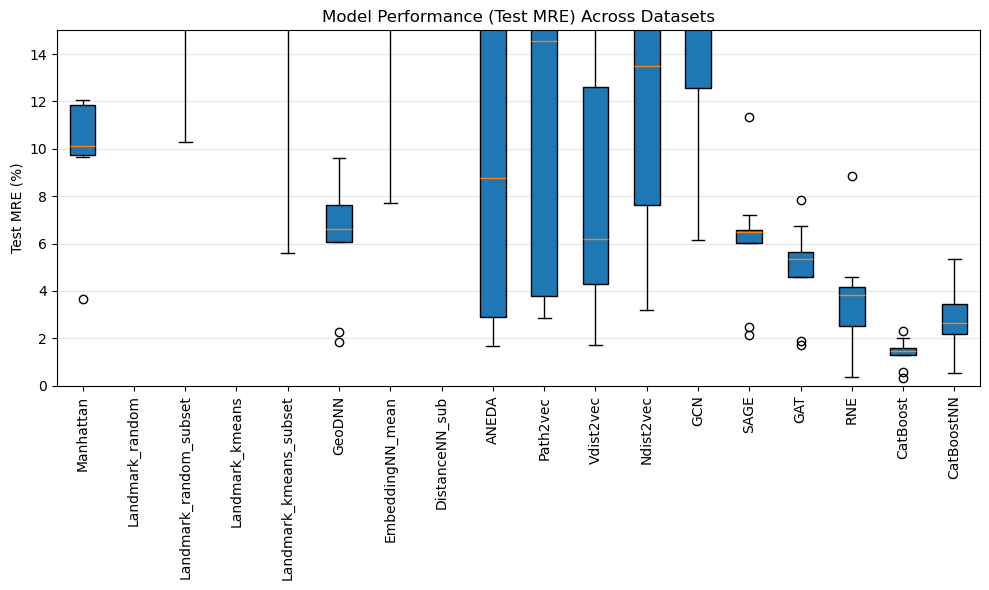

In [8]:
# Draw a box plot of model performance (test MRE) averaged across datasets

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot([pivot_test_mre.loc[model].dropna().values for model in pivot_test_mre.index],
            labels=pivot_test_mre.index,
            patch_artist=True)

plt.ylabel('Test MRE (%)')
plt.title('Model Performance (Test MRE) Across Datasets')
plt.xticks(rotation=90)
plt.ylim(0, 15)  # Set y-axis limits from 0 to 50
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

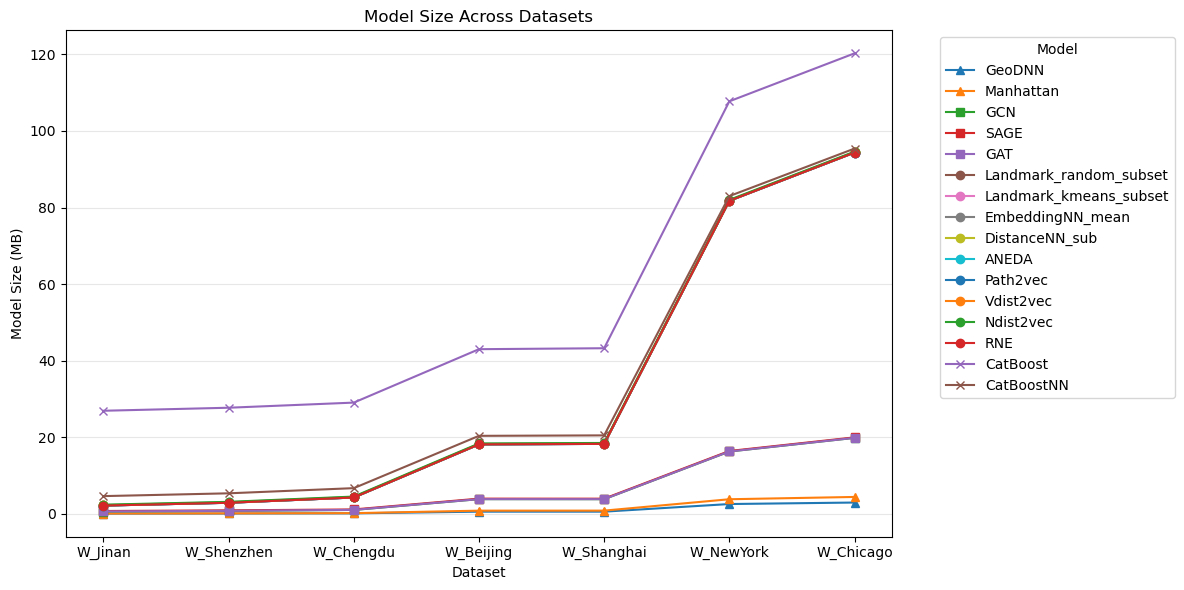

| model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |
|:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|
| GeoDNN                 |      0.09 |         0.11 |        0.15 |        0.59 |         0.59 |        2.58 |        2.97 |
| Manhattan              |      0.1  |         0.14 |        0.2  |        0.85 |         0.86 |        3.83 |        4.43 |
| GCN                    |      0.63 |         0.8  |        1.04 |        3.86 |         3.85 |       16.3  |       19.86 |
| SAGE                   |      0.76 |         0.93 |        1.17 |        3.99 |         3.98 |       16.43 |       19.99 |
| GAT                    |      0.64 |         0.81 |        1.05 |        3.86 |         3.85 |       16.3  |       19.86 |
| Landmark_random_subset |      2.18 |         2.92 |        4.29 |       18.16 |        18.29 |       81.77 |       94.37 |


In [9]:
all_models = [
    'GeoDNN',

    'Manhattan',  # Better

    'GCN',
    'SAGE',
    'GAT',

    # 'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    # 'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

markers = {
    # Category 1: coordinates only
    'GeoDNN': '^',
    'Manhattan': '^',

    # Category 2: coordinates + edges
    'GCN': 's',
    'SAGE': 's',
    'GAT': 's',

    # Category 3: embeddings only
    'EmbeddingNN': 'o',
    'EmbeddingNN_mean': 'o',
    'EmbeddingNN_sub': 'o',
    'DistanceNN': 'o',
    'DistanceNN_mean': 'o',
    'DistanceNN_sub': 'o',
    'ANEDA': 'o',
    'ANEDA_random': 'o',
    'Path2vec': 'o',
    'Vdist2vec': 'o',
    'Ndist2vec': 'o',
    'RNE': 'o',
    'Landmark_random': 'o',
    'Landmark_random_subset': 'o',
    'Landmark_kmeans': 'o',
    'Landmark_kmeans_subset': 'o',

    # Category 4: embeddings + model
    'CatBoost': 'x',
    'CatBoostNN': 'x',
}

all_datasets = [
    'W_Jinan',      # 8.9k
    'W_Shenzhen',   # 11.9k
    'W_Chengdu',    # 17.5k
    'W_Beijing',    # 74.3k
    'W_Shanghai',   # 74.9k
    'W_NewYork',    # 334.9k
    'W_Chicago',    # 386.5k
]

# Plot
plt.figure(figsize=(12, 6))
for model in all_models:
    model_data = df[df['model_name'] == model]
    plt.plot(
        all_datasets,
        [model_data[model_data['data_name'] == d]['model_size'].mean() if not model_data[model_data['data_name'] == d].empty else None for d in all_datasets],
        marker=markers.get(model, ''),
        label=model
    )
plt.xlabel('Dataset')
plt.ylabel('Model Size (MB)')
plt.title('Model Size Across Datasets')
plt.xticks(rotation=0)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Table
pivot_model_size = (
    df[df['model_name'].isin(all_models) & df['data_name'].isin(all_datasets)]
    .groupby(['model_name', 'data_name'])['model_size']
    .mean()
    .unstack('data_name')
    .reindex(index=all_models, columns=all_datasets)
)
print(pivot_model_size.round(2).to_markdown())

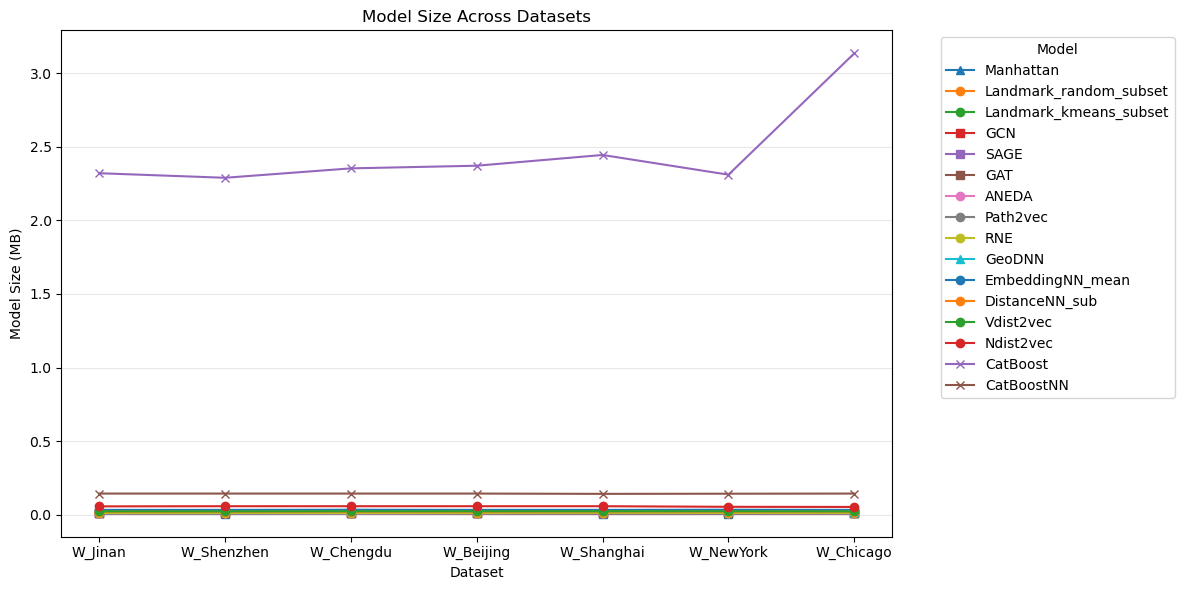

| model_name             |   W_Jinan |   W_Shenzhen |   W_Chengdu |   W_Beijing |   W_Shanghai |   W_NewYork |   W_Chicago |   Mean |   Std |
|:-----------------------|----------:|-------------:|------------:|------------:|-------------:|------------:|------------:|-------:|------:|
| Manhattan              |     0.008 |        0.007 |       0.008 |       0.008 |        0.007 |       0.007 |       0.008 |  0.008 | 0     |
| Landmark_random_subset |     0.011 |        0.011 |       0.011 |       0.011 |        0.011 |       0.011 |       0.011 |  0.011 | 0     |
| Landmark_kmeans_subset |     0.011 |        0.011 |       0.011 |       0.011 |        0.012 |       0.012 |       0.011 |  0.011 | 0     |
| GCN                    |     0.01  |        0.01  |       0.01  |       0.009 |        0.009 |       0.009 |       0.009 |  0.009 | 0     |
| SAGE                   |     0.009 |        0.01  |       0.009 |       0.009 |        0.009 |       0.009 |       0.009 |  0.009 | 0     |
| GAT 

In [10]:
all_models = [
    'Manhattan',  # Better
    # 'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    # 'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best
    'GCN',
    # 'GCN_smooth',
    'SAGE',
    # 'SAGE_smooth',
    'GAT',
    # 'GAT_smooth',
    'ANEDA',  # Better
    # 'ANEDA_random',
    'Path2vec',
    'RNE',

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'Vdist2vec',
    'Ndist2vec',


    'CatBoost',
    'CatBoostNN',
]

markers = {
    # Category 1: shallow decoder
    'Manhattan': '^',
    'Landmark_random': 'o',
    'Landmark_random_subset': 'o',
    'Landmark_kmeans': 'o',
    'Landmark_kmeans_subset': 'o',
    'GCN': 's',
    'SAGE': 's',
    'GAT': 's',
    'ANEDA': 'o',
    'ANEDA_random': 'o',
    'Path2vec': 'o',
    'RNE': 'o',

    # Category 2: neural network
    'GeoDNN': '^',
    'EmbeddingNN': 'o',
    'EmbeddingNN_mean': 'o',
    'EmbeddingNN_sub': 'o',
    'DistanceNN': 'o',
    'DistanceNN_mean': 'o',
    'DistanceNN_sub': 'o',
    'Vdist2vec': 'o',
    'Ndist2vec': 'o',

    # Category 4: embeddings + model
    'CatBoost': 'x',
    'CatBoostNN': 'x',
}

all_datasets = [
    'W_Jinan',      # 8.9k
    'W_Shenzhen',   # 11.9k
    'W_Chengdu',    # 17.5k
    'W_Beijing',    # 74.3k
    'W_Shanghai',   # 74.9k
    'W_NewYork',    # 334.9k
    'W_Chicago',    # 386.5k
]

# Plot
plt.figure(figsize=(12, 6))
for model in all_models:
    model_data = df[df['model_name'] == model]
    plt.plot(
        all_datasets,
        [model_data[model_data['data_name'] == d]['test_query_time'].mean() if not model_data[model_data['data_name'] == d].empty else None for d in all_datasets],
        marker=markers.get(model, ''),
        label=model
    )
plt.xlabel('Dataset')
plt.ylabel('Model Size (MB)')
plt.title('Model Size Across Datasets')
plt.xticks(rotation=0)
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Table
pivot_test_query_time = (
    df[df['model_name'].isin(all_models) & df['data_name'].isin(all_datasets)]
    .groupby(['model_name', 'data_name'])['test_query_time']
    .mean()
    .unstack('data_name')
    .reindex(index=all_models, columns=all_datasets)
)
# Add mean and std columns across datasets
pivot_test_query_time['Mean'] = pivot_test_query_time.mean(axis=1)
pivot_test_query_time['Std'] = pivot_test_query_time.std(axis=1)
# print(pivot_test_query_time[['Mean', 'Std']].round(3).to_markdown())
print(pivot_test_query_time.round(3).to_markdown())

In [ ]:
# CPU
| model_name             |    Mean |   Std |
|:-----------------------|--------:|------:|
| Manhattan              |   0.189 |     0 |
| Landmark_random_subset |   0.408 |     0 |
| Landmark_kmeans_subset |   0.405 |     0 |
| HCL                    |   7.966 | 3.816 |
| GCN                    |   0.647 |     0 |
| SAGE                   |   0.649 |     0 |
| GAT                    |   0.722 |     0 |
| ANEDA                  |   0.551 |     0 |
| Path2vec               |   0.524 |     0 |
| RNE                    |   0.392 |     0 |
| GeoDNN                 |   0.655 |     0 |
| EmbeddingNN_mean       |   3.308 |     0 |
| DistanceNN_sub         |   0.702 |     0 |
| Vdist2vec              |   1.331 |     0 |
| Ndist2vec              |   4.237 |     0 |
| CatBoost               |   2.127 |     0 |
| LandmarkNN             |  28.252 |     0 |

# CUDA
| model_name             |   Mean |   Std |
|:-----------------------|-------:|------:|
| Manhattan              |  0.008 | 0     |
| Landmark_random_subset |  0.011 | 0     |
| Landmark_kmeans_subset |  0.011 | 0     |
| GCN                    |  0.009 | 0     |
| SAGE                   |  0.009 | 0     |
| GAT                    |  0.009 | 0     |
| ANEDA                  |  0.013 | 0     |
| Path2vec               |  0.013 | 0     |
| RNE                    |  0.011 | 0     |
| GeoDNN                 |  0.023 | 0.001 |
| EmbeddingNN_mean       |  0.032 | 0     |
| DistanceNN_sub         |  0.020 | 0     |
| Vdist2vec              |  0.023 | 0     |
| Ndist2vec              |  0.056 | 0.002 |
| CatBoost               |  2.461 | 0.279 |
| LandmarkNN             |  0.143 | 0.001 |

# Combined
| model_name             |   CPU (Mean ± Std) |   GPU (Mean ± Std) |
|:-----------------------|:-------------------|:-------------------|
| Manhattan              | 0.189 ± 0          | 0.008 ± 0          |
| Landmark_random_subset | 0.408 ± 0          | 0.011 ± 0          |
| Landmark_kmeans_subset | 0.405 ± 0          | 0.011 ± 0          |
| HCL                    | 7.966 ± 3.816      |         —          |
| GCN                    | 0.647 ± 0          | 0.009 ± 0          |
| SAGE                   | 0.649 ± 0          | 0.009 ± 0          |
| GAT                    | 0.722 ± 0          | 0.009 ± 0          |
| ANEDA                  | 0.551 ± 0          | 0.013 ± 0          |
| Path2vec               | 0.524 ± 0          | 0.013 ± 0          |
| RNE                    | 0.392 ± 0          | 0.011 ± 0          |
| GeoDNN                 | 0.655 ± 0          | 0.023 ± 0.001      |
| EmbeddingNN_mean       | 3.308 ± 0          | 0.032 ± 0          |
| DistanceNN_sub         | 0.702 ± 0          | 0.020 ± 0          |
| Vdist2vec              | 1.331 ± 0          | 0.023 ± 0          |
| Ndist2vec              | 4.237 ± 0          | 0.056 ± 0.002      |
| CatBoost               | 2.127 ± 0          | 2.461 ± 0.279      |
| LandmarkNN             | 28.252 ± 0         | 0.143 ± 0.001      |

In [12]:
sample_text = """
| model_name             |   CPU (Mean ± Std) |   GPU (Mean ± Std) |
|:-----------------------|:-------------------|:-------------------|
| Manhattan              | 0.189 ± 0          | 0.008 ± 0          |
| Landmark_random_subset | 0.408 ± 0          | 0.011 ± 0          |
| Landmark_kmeans_subset | 0.405 ± 0          | 0.011 ± 0          |
| HCL                    | 7.966 ± 3.816      |         —          |
| GCN                    | 0.647 ± 0          | 0.009 ± 0          |
| SAGE                   | 0.649 ± 0          | 0.009 ± 0          |
| GAT                    | 0.722 ± 0          | 0.009 ± 0          |
| ANEDA                  | 0.551 ± 0          | 0.013 ± 0          |
| Path2vec               | 0.524 ± 0          | 0.013 ± 0          |
| RNE                    | 0.392 ± 0          | 0.011 ± 0          |
| GeoDNN                 | 0.655 ± 0          | 0.023 ± 0.001      |
| EmbeddingNN_mean       | 3.308 ± 0          | 0.032 ± 0          |
| DistanceNN_sub         | 0.702 ± 0          | 0.020 ± 0          |
| Vdist2vec              | 1.331 ± 0          | 0.023 ± 0          |
| Ndist2vec              | 4.237 ± 0          | 0.056 ± 0.002      |
| CatBoost               | 2.127 ± 0          | 2.461 ± 0.279      |
| LandmarkNN             | 28.252 ± 0         | 0.143 ± 0.001      |
"""

# compute speedup  per line by dividing CPU mean by GPU mean
for line in sample_text.strip().split("\n")[2:]:
    parts = line.split("|")
    model_name = parts[1].strip()
    cpu_stats = parts[2].strip()
    gpu_stats = parts[3].strip()

    if gpu_stats == "—":
        speedup = "N/A"
    else:
        cpu_mean = float(cpu_stats.split("±")[0].strip())
        gpu_mean = float(gpu_stats.split("±")[0].strip())
        speedup = round(cpu_mean / gpu_mean, 2) if gpu_mean != 0 else "Inf"

    print(f"{model_name}: Speedup = {speedup}x")

Manhattan: Speedup = 23.62x
Landmark_random_subset: Speedup = 37.09x
Landmark_kmeans_subset: Speedup = 36.82x
HCL: Speedup = N/Ax
GCN: Speedup = 71.89x
SAGE: Speedup = 72.11x
GAT: Speedup = 80.22x
ANEDA: Speedup = 42.38x
Path2vec: Speedup = 40.31x
RNE: Speedup = 35.64x
GeoDNN: Speedup = 28.48x
EmbeddingNN_mean: Speedup = 103.37x
DistanceNN_sub: Speedup = 35.1x
Vdist2vec: Speedup = 57.87x
Ndist2vec: Speedup = 75.66x
CatBoost: Speedup = 0.86x
LandmarkNN: Speedup = 197.57x


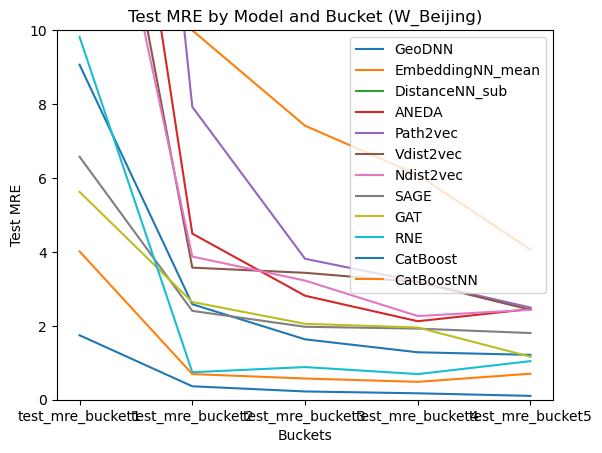

In [116]:
df[df['model_name'].isin(all_models) & df['data_name'].isin(['W_Jinan'])][['model_name', 'data_name', 'test_mre']+[c for c in df.columns if 'test_mre_bucket' in c]]

# plot all 5 buckets of test_mre for all models on W_Jinan dataset with a line plot with buckets on x-axis and test_mre on y-axis
all_models = [
    # 'Manhattan',  # Better

    # 'Landmark_random',
    # 'Landmark_random_subset', # Better than Landmark_random
    # 'Landmark_kmeans',  # Better than Landmark_random
    # 'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # # 'GCN',
    # 'GCN_smooth',
    # 'SAGE_smooth',  # Better than SAGE
    'SAGE',
    # 'GAT_smooth',  # Better than GAT
    'GAT',

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

dataset_name = 'W_Beijing'

bucket_columns = [c for c in df.columns if 'test_mre_bucket' in c]
for model in all_models:
    model_data = df[(df['model_name'] == model) & (df['data_name'] == dataset_name)]
    plt.plot(bucket_columns, model_data[bucket_columns].values.flatten(), label=model)

plt.xlabel('Buckets')
plt.ylabel('Test MRE')
# set y-limit 0 to 15
plt.ylim(0, 10)
plt.title(f'Test MRE by Model and Bucket ({dataset_name})')
plt.legend()
plt.show()

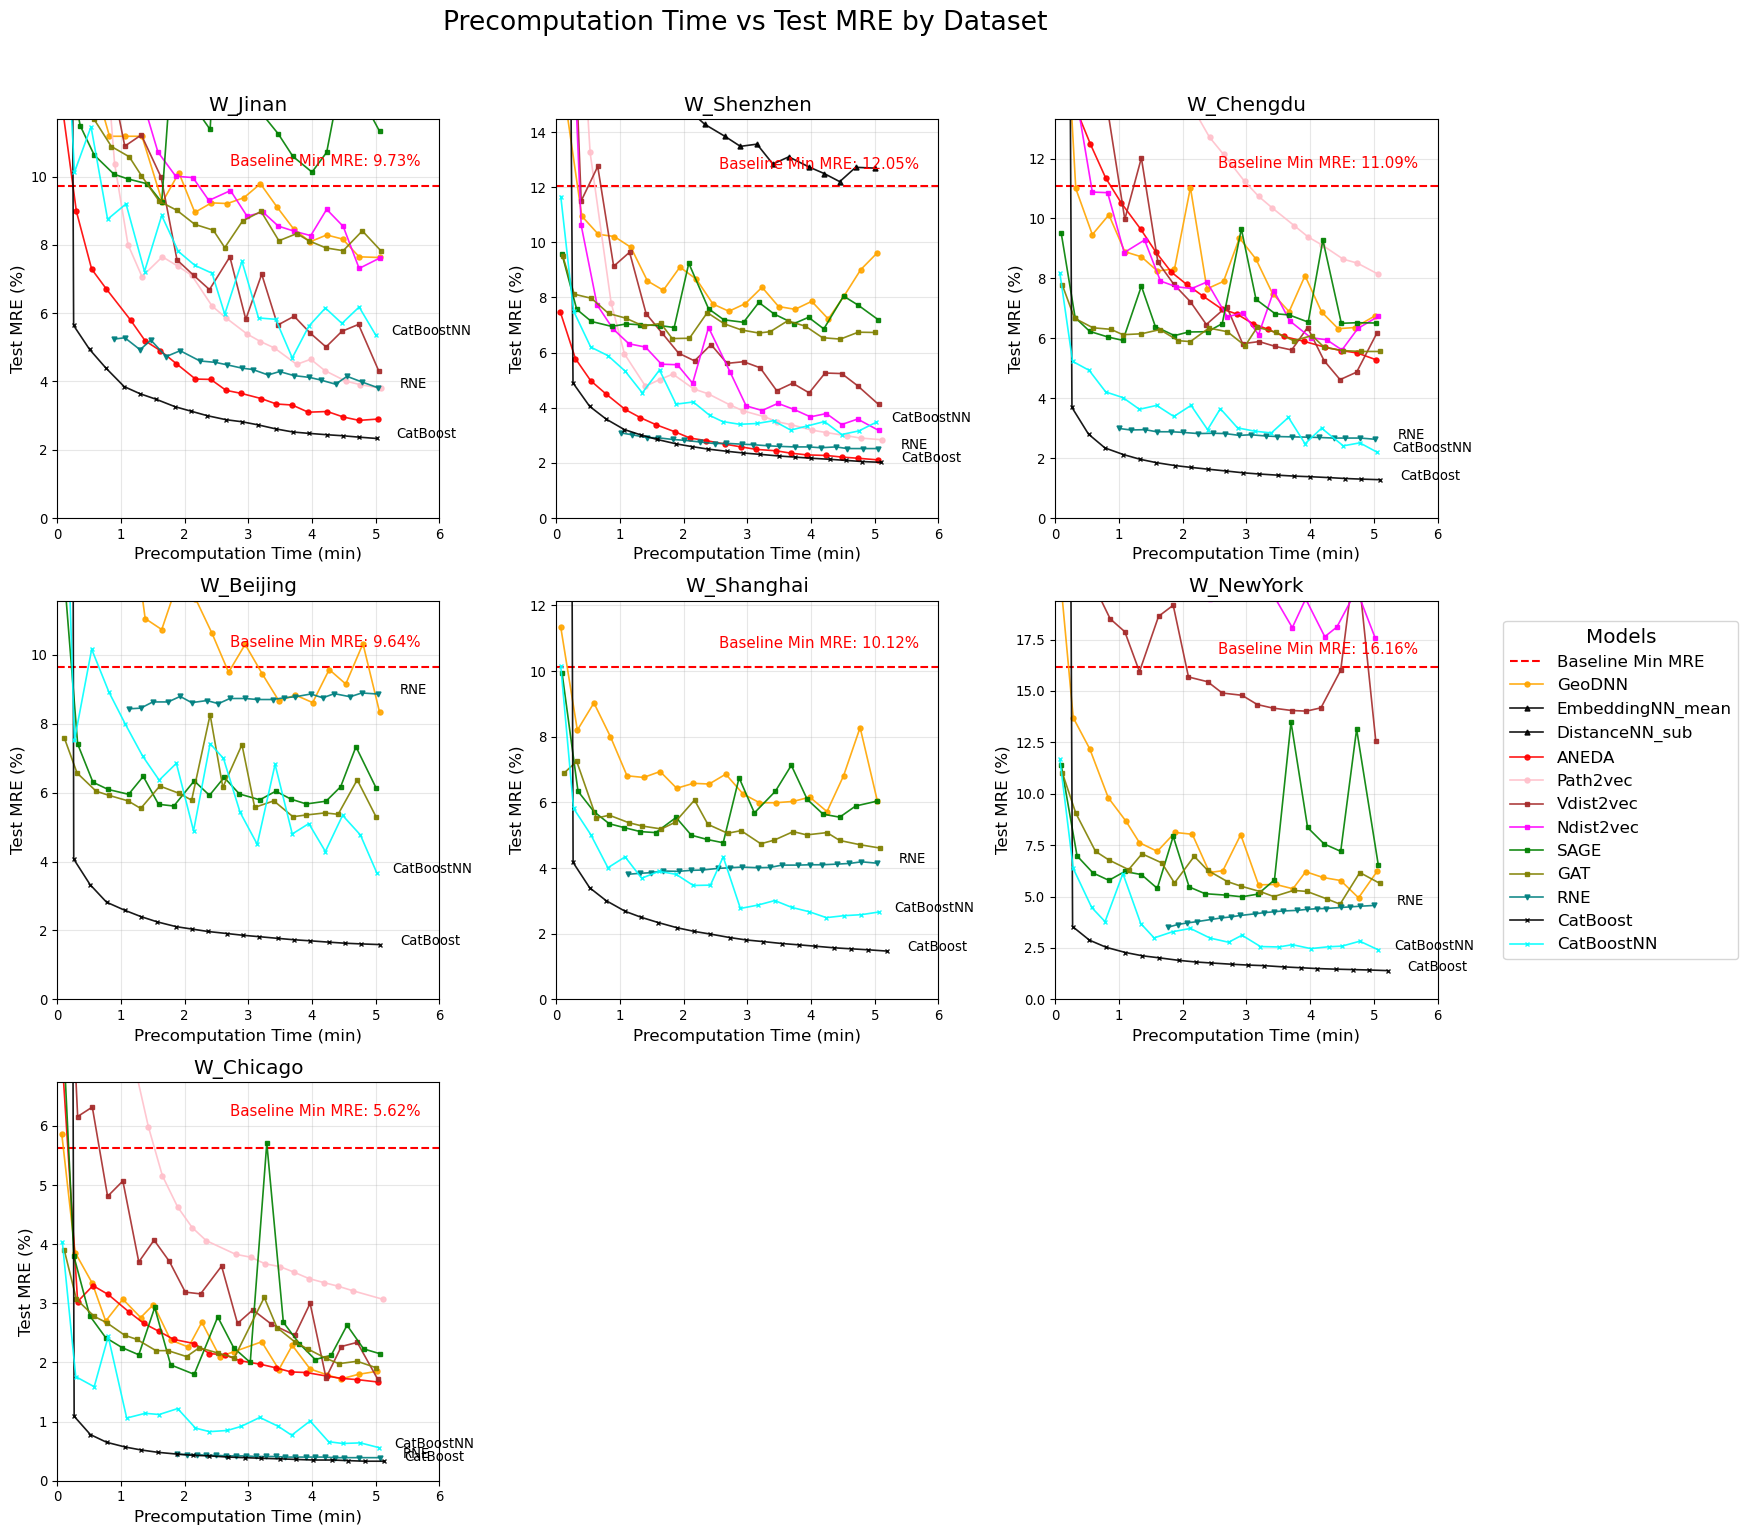

In [ ]:
# Pivot table: models as rows, datasets as columns, metric = test_mre
all_models = [
    'Manhattan',  # Better

    'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # 'GCN',
    'SAGE',
    'GAT',  # Better

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

all_datasets = [
    'W_Jinan',  # 8.9k
    'W_Shenzhen',  # 11.9k
    'W_Chengdu',  # 17.5k
    'W_Beijing',  # 74.3k
    'W_Shanghai',  # 74.9k
    'W_NewYork',  # 334.9k
    'W_Chicago',  # 386.5k
]

# Create scatter plots for precomputation time vs test MRE
def plot_precomputation_vs_mre(df, datasets, all_models, font_scale=1.5):
    # Calculate number of rows and columns for subplots
    n_datasets = len(datasets)
    n_cols = 3
    n_rows = (n_datasets + n_cols - 1) // n_cols

    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    fig.suptitle('Precomputation Time vs Test MRE by Dataset', fontsize=16*font_scale, y=1.02)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Define colors for different model types
    model_colors = {
        # 'Manhattan': 'gray',
        # 'Landmark': 'brown',
        'GeoDNN': 'orange',
        'EmbeddingNN': 'blue',
        'DistanceNN': 'purple',
        'ANEDA': 'red',
        'Path2vec': 'pink',
        'Vdist2vec': 'brown',
        'Ndist2vec': 'magenta',
        'SAGE': 'green',
        'GAT': 'olive',
        'RNE': 'teal',
        'CatBoost': 'black',
        'CatBoostNN': 'cyan',
    }

    markers = {
        # Category 1: coordinates only
        'GeoDNN': 'o',

        # Category 2: coordinates + edges
        'GCN': 's',
        'SAGE': 's',
        'GAT': 's',

        # Category 3: embeddings only
        'EmbeddingNN': 'o',
        'EmbeddingNN_mean': '^',
        'EmbeddingNN_sub': '^',
        'DistanceNN': '^',
        'DistanceNN_mean': '^',
        'DistanceNN_sub': '^',
        'ANEDA': 'o',
        'ANEDA_random': 'o',
        'Path2vec': 'o',
        'Vdist2vec': 's',
        'Ndist2vec': 's',
        'RNE': 'v',

        # Category 4: embeddings + model
        'CatBoost': 'x',
        'CatBoostNN': 'x',
    }

    baseline_models = ['Manhattan', 'Landmark_kmeans', 'Landmark_random', 'Landmark_kmeans_subset', 'Landmark_random_subset']

    # Plot each dataset in a separate subplot
    for idx, dataset in enumerate(datasets):
        ax = axes[idx]
        data = df[df['data_name'] == dataset]

        # Add horizontal line for baseline minimum
        baseline_data = data[data['model_name'].isin(baseline_models)]
        if not baseline_data.empty:
            min_baseline_mre = baseline_data['test_mre'].min()
            if min_baseline_mre <= 25:  # Changed from 20 to 25
                ax.axhline(y=min_baseline_mre, color='red', linestyle='--', label='Baseline Min MRE')
                ax.text(0.95, min_baseline_mre + 0.5,
                       f'Baseline Min MRE: {min_baseline_mre:.2f}%',
                       color='red',
                       fontsize=9*font_scale,
                       ha='right',
                       va='bottom',
                       transform=ax.get_yaxis_transform())

        # Plot top 3 models (excluding baselines)
        # top_models = data[~data['model_name'].isin(baseline_models)].nsmallest(3, 'test_mre')
        top_models = ['CatBoostNN', 'RNE', 'CatBoost'] # Manually specify top models for consistency
        model_excluding_baselines = [m for m in all_models if m not in baseline_models]
        texts = []
        for model in model_excluding_baselines:
            model_data = data[data['model_name'] == model].iloc[0]
            model_color = model_colors.get(model, 'black')
            # Plot 'time_elapsed_history' on x-axis and 'val_mre_history' on y-axis
            # Randomly sample upto 20 evenly spaced points for plotting
            idx_sample = np.linspace(0, len(model_data['time_elapsed_history']) - 1, min(20, len(model_data['time_elapsed_history']))).astype(int)
            model_data_sampled = {
                'time_elapsed_history': np.array(model_data['time_elapsed_history'])[idx_sample],
                'val_mre_history': np.array(model_data['val_mre_history'])[idx_sample],
            }
            ax.plot(model_data_sampled['time_elapsed_history'],
                    model_data_sampled['val_mre_history'],
                    label=model_data['model_name'],
                    alpha=0.9,
                    linewidth=1*font_scale,
                    marker=markers.get(model, 'o'),
                    markersize=3*font_scale,
                    color=model_color)
            if model in top_models:
                # Annotate the point with text and collect the annotation object
                ax.annotate(model_data['model_name'],
                            (model_data_sampled['time_elapsed_history'][-1], model_data_sampled['val_mre_history'][-1]),
                            textcoords="offset points",
                            # xytext=(0, 0),
                            xytext=(20 + len(model_data['model_name'])*2, 0),
                            ha='center',
                            fontsize=8*font_scale)

        # Add labels and title
        ax.set_xlabel('Precomputation Time (min)', fontsize=10*font_scale)
        ax.set_ylabel('Test MRE (%)', fontsize=10*font_scale)
        ax.set_title(f'{dataset}', fontsize=12*font_scale)

        # Set tick label sizes
        ax.tick_params(axis='both', labelsize=8*font_scale)

        # Add grid
        ax.grid(True, alpha=0.3)

        # Set axis limits
        ax.set_xlim(0, 6)
        ax.set_ylim(0, min_baseline_mre*1.2)  # Plot up to 13% MRE for better visibility

    # Remove empty subplots
    for idx in range(len(datasets), len(axes)):
        fig.delaxes(axes[idx])

    # Add legend outside of subplots
    handles, labels = axes[0].get_legend_handles_labels()
    legend = fig.legend(handles, labels,
                       loc='center left',
                       bbox_to_anchor=(1.0, 0.5),
                       title='Models',
                       fontsize=10*font_scale)
    legend.get_title().set_fontsize(12*font_scale)

    plt.tight_layout()
    plt.show()

# Create the plot
plot_precomputation_vs_mre(df, all_datasets, all_models, font_scale=1.2)

## Figure 2 from Paper

Saved figure to `precomputation-time-vs-error.pdf`


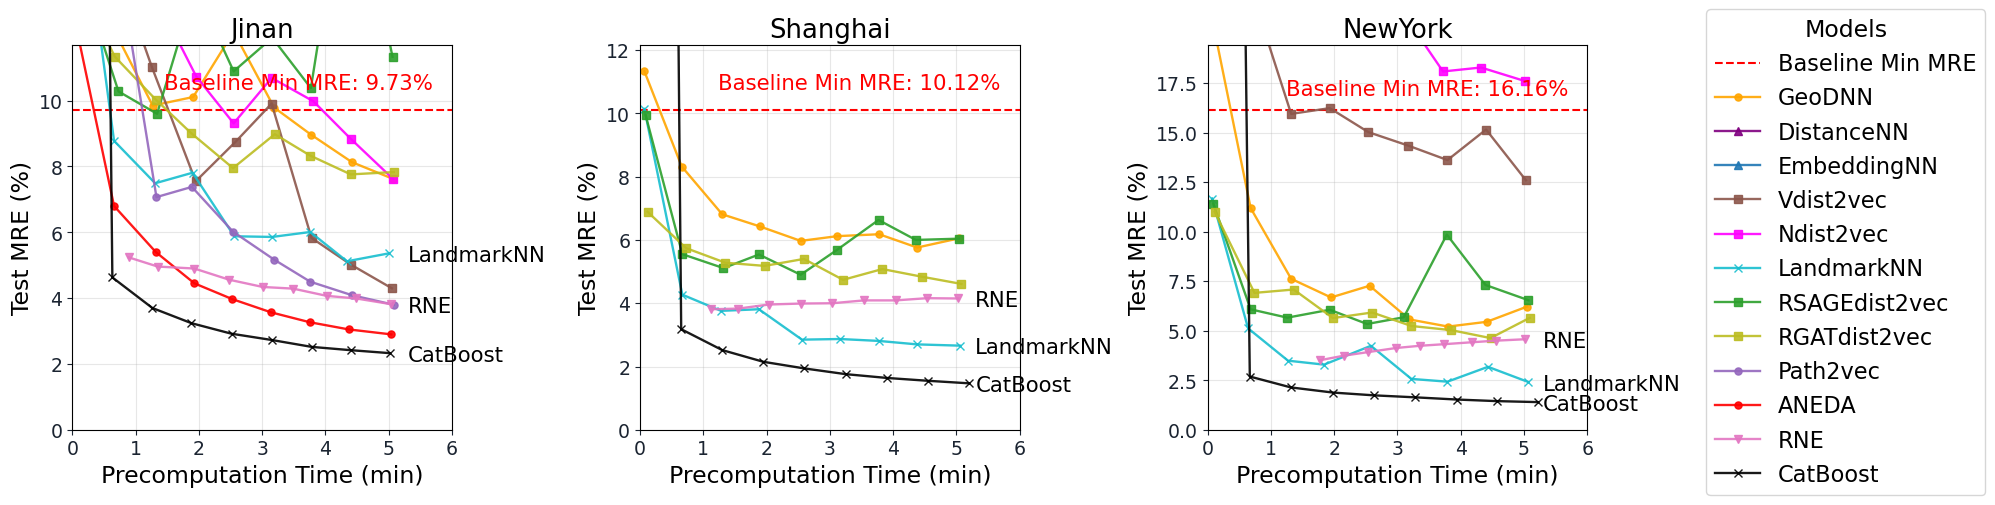

In [35]:
# Pivot table: models as rows, datasets as columns, metric = test_mre
all_models = [
    'Manhattan',  # Better

    'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    'Vdist2vec',
    'Ndist2vec',

    'CatBoostNN',

    # 'GCN',
    'SAGE',
    'GAT',  # Better

    'Path2vec',

    'ANEDA',  # Better
    # 'ANEDA_random',

    'RNE',

    'CatBoost',
]

all_datasets = [
    'W_Jinan',  # 8.9k
    # 'W_Shenzhen',  # 11.9k
    # 'W_Chengdu',  # 17.5k
    # 'W_Beijing',  # 74.3k
    'W_Shanghai',  # 74.9k
    'W_NewYork',  # 334.9k
    # 'W_Chicago',  # 386.5k
]

def plot_precomputation_vs_mre(df, datasets, all_models, font_scale=1.5, save_path=None, dpi=100):

    # Map dataset display names
    display_names = {
        'W_Jinan': 'Jinan',
        'W_Shanghai': 'Shanghai',
        'W_NewYork': 'NewYork',
        'CatBoostNN': 'LandmarkNN',
        'EmbeddingNN_mean': 'EmbeddingNN',
        'DistanceNN_sub': 'DistanceNN',
        'GAT': 'RGATdist2vec',
        'GCN': 'RGCNdist2vec',
        'SAGE': 'RSAGEdist2vec',
    }

    # Calculate number of rows and columns for subplots
    n_datasets = len(datasets)
    n_cols = 3
    n_rows = (n_datasets + n_cols - 1) // n_cols

    # Create figure and subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(17, 5*n_rows))
    # Suppress showing the title
    # fig.suptitle('Precomputation Time vs Test MRE by Dataset', fontsize=16*font_scale, y=1.02)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    # Define colors for different model types
    model_colors = {
        'GeoDNN': 'orange',
        'EmbeddingNN_mean': 'tab:blue',
        'DistanceNN_sub': 'purple',
        'ANEDA': 'red',
        'Path2vec': 'tab:purple',
        'Vdist2vec': 'tab:brown',
        'Ndist2vec': 'magenta',
        'SAGE': 'tab:green',
        'GAT': 'tab:olive',
        'RNE': 'tab:pink',
        'CatBoost': 'black',
        'CatBoostNN': 'tab:cyan',
    }

    markers = {
        'GeoDNN': 'o',
        'GCN': 's',
        'SAGE': 's',
        'GAT': 's',
        'EmbeddingNN': 'o',
        'EmbeddingNN_mean': '^',
        'EmbeddingNN_sub': '^',
        'DistanceNN': '^',
        'DistanceNN_mean': '^',
        'DistanceNN_sub': '^',
        'ANEDA': 'o',
        'ANEDA_random': 'o',
        'Path2vec': 'o',
        'Vdist2vec': 's',
        'Ndist2vec': 's',
        'RNE': 'v',
        'CatBoost': 'x',
        'CatBoostNN': 'x',
    }

    baseline_models = ['Manhattan', 'Landmark_kmeans', 'Landmark_random', 'Landmark_kmeans_subset', 'Landmark_random_subset']

    # Plot each dataset in a separate subplot
    for idx, dataset in enumerate(datasets):
        ax = axes[idx]
        data = df[df['data_name'] == dataset]

        # Add horizontal line for baseline minimum
        baseline_data = data[data['model_name'].isin(baseline_models)]
        min_baseline_mre = None
        if not baseline_data.empty:
            min_baseline_mre = baseline_data['test_mre'].min()
            if min_baseline_mre <= 25:
                ax.axhline(y=min_baseline_mre, color='red', linestyle='--', label='Baseline Min MRE')
                ax.text(0.95, min_baseline_mre + 0.5,
                       f'Baseline Min MRE: {min_baseline_mre:.2f}%',
                       color='red',
                       fontsize=9*font_scale,
                       ha='right',
                       va='bottom',
                       transform=ax.get_yaxis_transform())

        # Plot top 3 models (excluding baselines)
        # top_models = data[~data['model_name'].isin(baseline_models)].nsmallest(3, 'test_mre')
        top_models = ['CatBoostNN', 'RNE', 'CatBoost'] # Manually specify top models for consistency
        model_excluding_baselines = [m for m in all_models if m not in baseline_models]
        texts = []
        for model in model_excluding_baselines:
            model_data = data[data['model_name'] == model].iloc[0]
            model_color = model_colors.get(model, 'black')
            display_model_name = display_names.get(model_data['model_name'], model_data['model_name'])
            # Plot 'time_elapsed_history' on x-axis and 'val_mre_history' on y-axis
            # Randomly sample upto 9 evenly spaced points for plotting
            idx_sample = np.linspace(0, len(model_data['time_elapsed_history']) - 1, min(9, len(model_data['time_elapsed_history']))).astype(int)
            model_data_sampled = {
                'time_elapsed_history': np.array(model_data['time_elapsed_history'])[idx_sample],
                'val_mre_history': np.array(model_data['val_mre_history'])[idx_sample],
            }

            # # Smooth using Savitzky-Golay filter
            # from scipy.signal import savgol_filter
            # window_length = 8
            # if len(model_data_sampled['val_mre_history']) >= window_length:  # data length >= window size
            #     model_data_sampled['val_mre_history'] = savgol_filter(
            #         model_data_sampled['val_mre_history'], window_length=window_length, polyorder=2)

            ax.plot(model_data_sampled['time_elapsed_history'],
                    model_data_sampled['val_mre_history'],
                    label=display_model_name,
                    alpha=0.9,
                    linewidth=1*font_scale,
                    marker=markers.get(model, 'o'),
                    markersize=3*font_scale,
                    color=model_color)
            if model in top_models:
                # Annotate the point with text and collect the annotation object
                ax.annotate(display_model_name,
                            (5.3, model_data_sampled['val_mre_history'][-1]),
                            ha='left',
                            va='center_baseline',
                            fontsize=9*font_scale)

        # Add labels and title (use display name mapping)
        ax.set_xlabel('Precomputation Time (min)', fontsize=10*font_scale)
        ax.set_ylabel('Test MRE (%)', fontsize=10*font_scale)
        display_name = display_names.get(dataset, dataset)
        ax.set_title(f'{display_name}', fontsize=11*font_scale)

        # Set tick label sizes
        # ax.tick_params(axis='both', labelsize=8*font_scale)
        # Gray out the tick params change
        ax.tick_params(axis='both', labelsize=8*font_scale, colors='xkcd:dark')

        # Add grid
        ax.grid(True, alpha=0.3)

        # Set axis limits if baseline found
        if min_baseline_mre is not None:
            ax.set_xlim(0, 6)
            ax.set_ylim(0, min_baseline_mre*1.2)

    # Remove empty subplots
    for idx in range(len(datasets), len(axes)):
        fig.delaxes(axes[idx])

    # Add legend outside of subplots
    handles, labels = axes[0].get_legend_handles_labels()
    legend = fig.legend(handles, labels,
                       loc='center left',
                       bbox_to_anchor=(1.0, 0.5),
                       title='Models',
                       fontsize=9.5*font_scale)
    legend.get_title().set_fontsize(10*font_scale)

    plt.tight_layout()
    # Save if requested, then show
    if save_path:
        fig.savefig(save_path, format='pdf', dpi=dpi, bbox_inches='tight')
        print(f"Saved figure to `{save_path}`")
    plt.show()

# Create the plot
plot_precomputation_vs_mre(df, all_datasets, all_models, font_scale=1.7, save_path='precomputation-time-vs-error.pdf')

## Plots

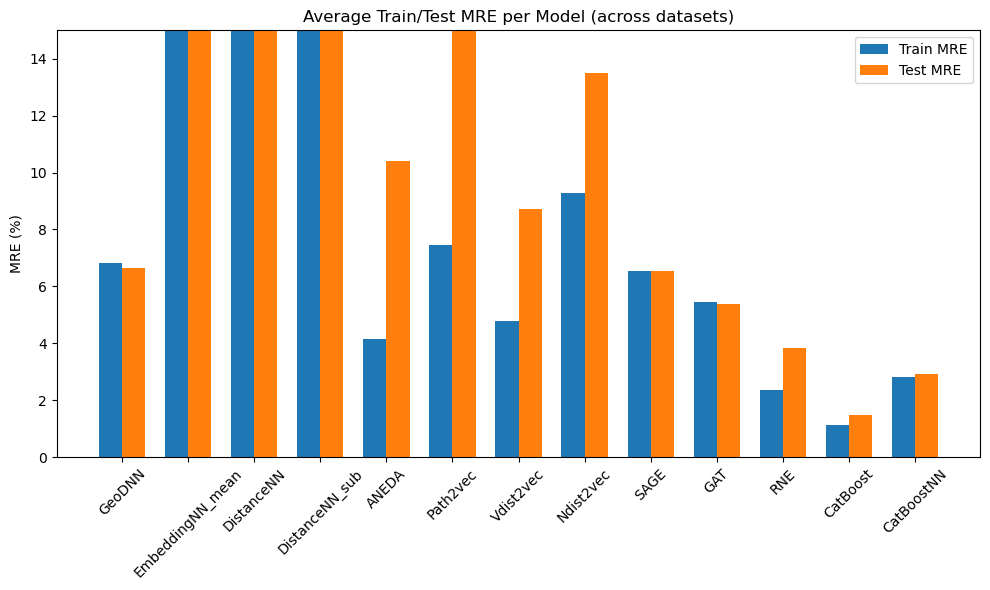

In [109]:
all_models = [
    # 'Manhattan',  # Better

    # 'Landmark_random',
    # 'Landmark_random_subset', # Better than Landmark_random
    # 'Landmark_kmeans',  # Better than Landmark_random
    # 'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # # 'GCN',
    'SAGE',
    'GAT',  # Better than SAGE

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

all_datasets = [
    'W_Jinan',  # 8.9k
    'W_Shenzhen',  # 11.9k
    'W_Chengdu',  # 17.5k
    'W_Beijing',  # 74.3k
    'W_Shanghai',  # 74.9k
    'W_NewYork',  # 334.9k
    'W_Chicago',  # 386.5k
]

# Filter df by models
df_filtered = df[df['model_name'].isin(all_models)]

datasets = df_filtered['data_name'].unique()
models = df_filtered['model_name'].unique()

# Calculate mean train and test MRE for each model across datasets
mean_mre = df_filtered.groupby('model_name')[['train_mre', 'test_mre']].mean().loc[all_models]

x = np.arange(len(mean_mre.index))
bar_width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - bar_width/2, mean_mre['train_mre'], width=bar_width, label='Train MRE')
plt.bar(x + bar_width/2, mean_mre['test_mre'], width=bar_width, label='Test MRE')

plt.xticks(x, mean_mre.index, rotation=45)
plt.ylabel('MRE (%)')
plt.ylim(0, 15)
plt.title('Average Train/Test MRE per Model (across datasets)')
plt.legend()
plt.tight_layout()
plt.show()

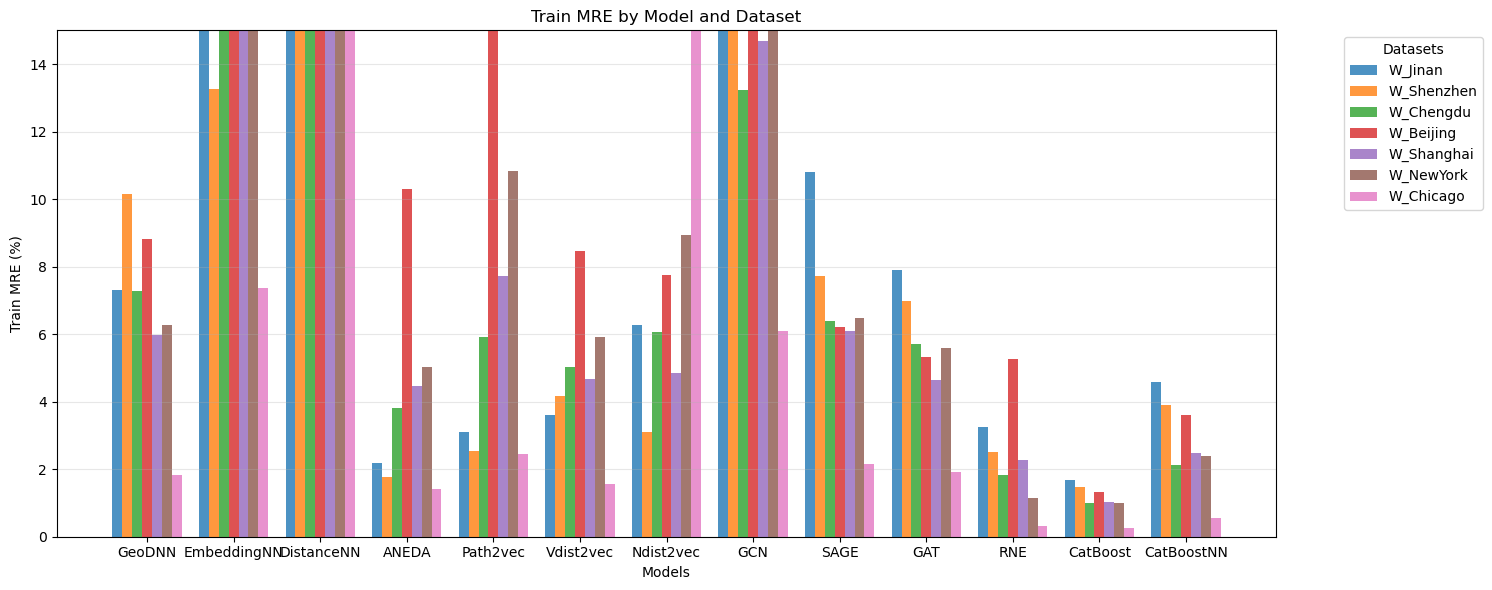

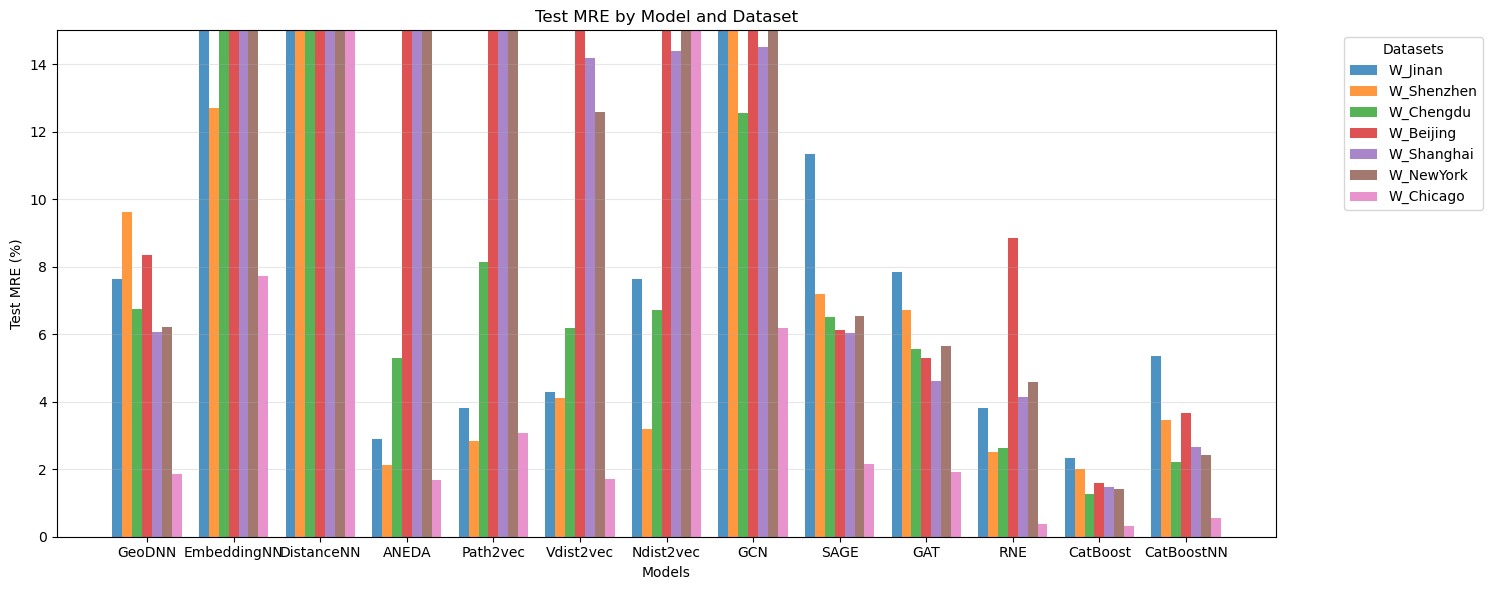

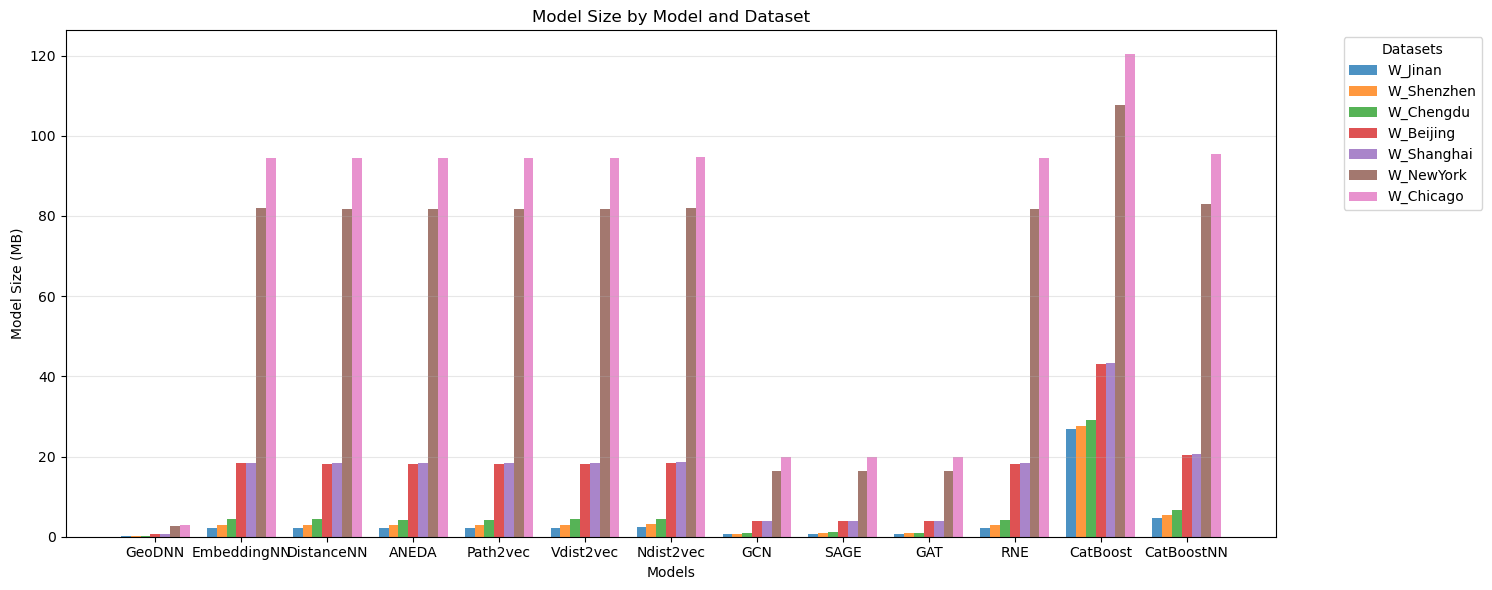

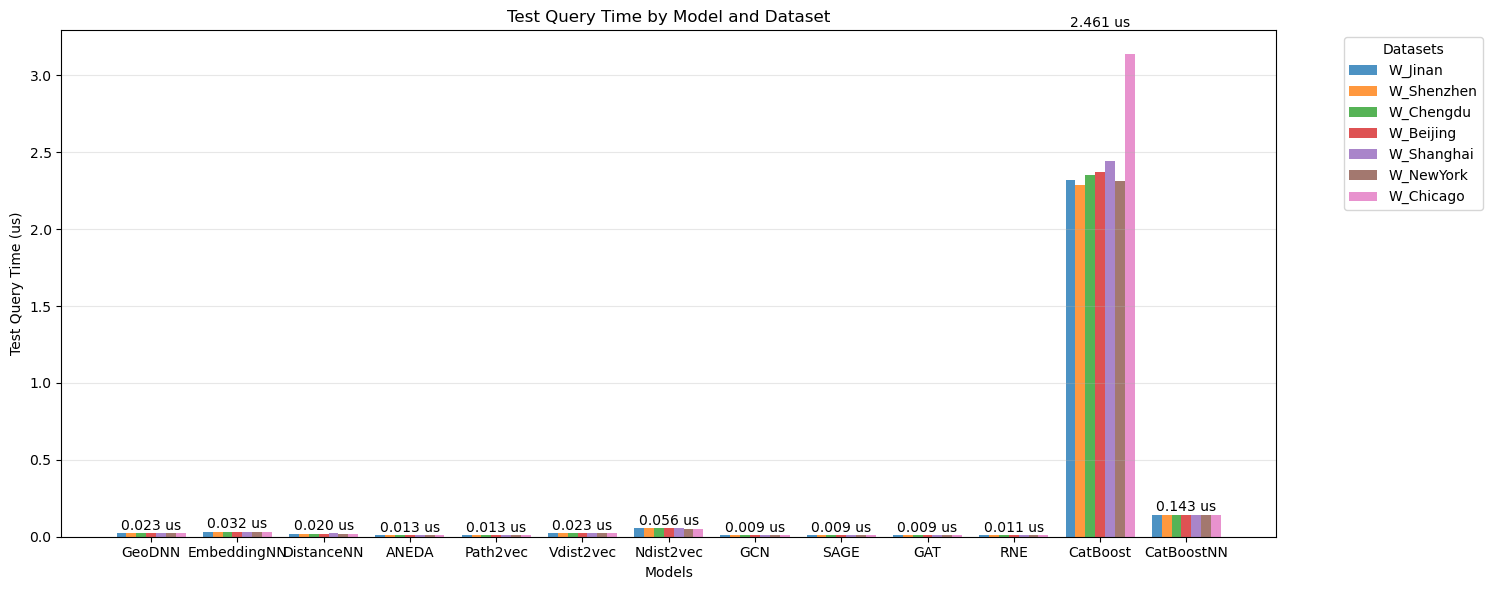

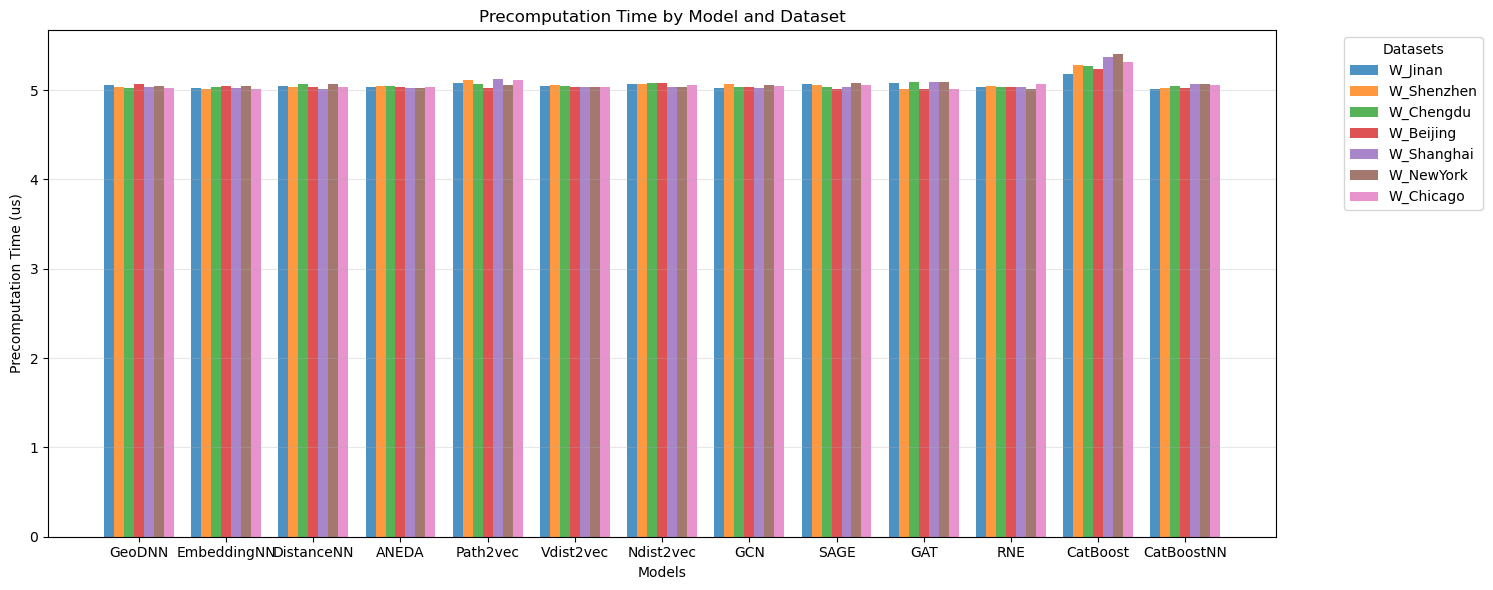

In [119]:
import numpy as np

# Keep the metrics dictionary the same
metrics = {
    'Train MRE': 'train_mre',
    'Test MRE': 'test_mre',
    'Model Size': 'model_size',
    'Test Query Time': 'test_query_time',
    'Precomputation Time': 'precomputation_time'
}
metric_units = {
    'Train MRE': '%',
    'Test MRE': '%',
    'Model Size': 'MB',
    'Test Query Time': 'us',
    'Precomputation Time': 'us'
}

all_models = [
    # 'Manhattan',  # Better

    # 'Landmark_random',
    # 'Landmark_random_subset', # Better than Landmark_random
    # 'Landmark_kmeans',  # Better than Landmark_random
    # 'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    'GCN',
    'SAGE',
    'GAT',  # Better than SAGE

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

all_datasets = [
    'W_Jinan',  # 8.9k
    'W_Shenzhen',  # 11.9k
    'W_Chengdu',  # 17.5k
    'W_Beijing',  # 74.3k
    'W_Shanghai',  # 74.9k
    'W_NewYork',  # 334.9k
    'W_Chicago',  # 386.5k
]

# Create grouped bar plots
def plot_metric_by_models(df, metric_name, metric_col, models, datasets):
    plt.figure(figsize=(15, 6))

    width = 0.8 / len(datasets)
    x = np.arange(len(models))

    # Store bar heights for annotation
    all_bar_heights = []

    for i, dataset in enumerate(datasets):
        values = []
        for model in models:
            val = df[(df['model_name'] == model) & (df['data_name'] == dataset)][metric_col]
            values.append(val.iloc[0] if not val.empty else np.nan)
        all_bar_heights.append(values)
        plt.bar(x + i*width - (len(datasets)-1)*width/2,
               values,
               width,
               label=dataset,
               alpha=0.8)

    # Annotate mean for each model (only for Test Query Time)
    if metric_name == 'Test Query Time':
        all_bar_heights = np.array(all_bar_heights)  # shape: (datasets, models)
        for idx, model in enumerate(models):
            # Get all bar heights for this model across datasets
            heights = all_bar_heights[:, idx]
            mean_val = np.nanmean(heights)
            max_val = np.nanmax(heights)
            xpos = x[idx]  # center of group
            # Place annotation slightly above max bar
            plt.text(xpos, max_val * 1.05, f"{mean_val:.3f} {metric_units[metric_name]}",
                     ha='center', va='bottom', fontsize=10, color='black', rotation=0)

    plt.xlabel('Models')
    plt.ylabel(f"{metric_name} ({metric_units[metric_name]})")
    plt.title(f'{metric_name} by Model and Dataset')
    modified_model_names = [m.split('_')[0] for m in models]
    plt.xticks(x, modified_model_names, rotation=0, ha='center')
    # if metric_name in ['Test Query Time']:
    #     plt.yscale('log')
    if metric_col in ['train_mre', 'test_mre']:
        plt.ylim(0, 15)
    plt.legend(title='Datasets', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Filter and plot for each metric
df_filtered = df[df['model_name'].isin(all_models)]

for metric_name, metric_col in metrics.items():
    plot_metric_by_models(df_filtered, metric_name, metric_col, all_models, all_datasets)

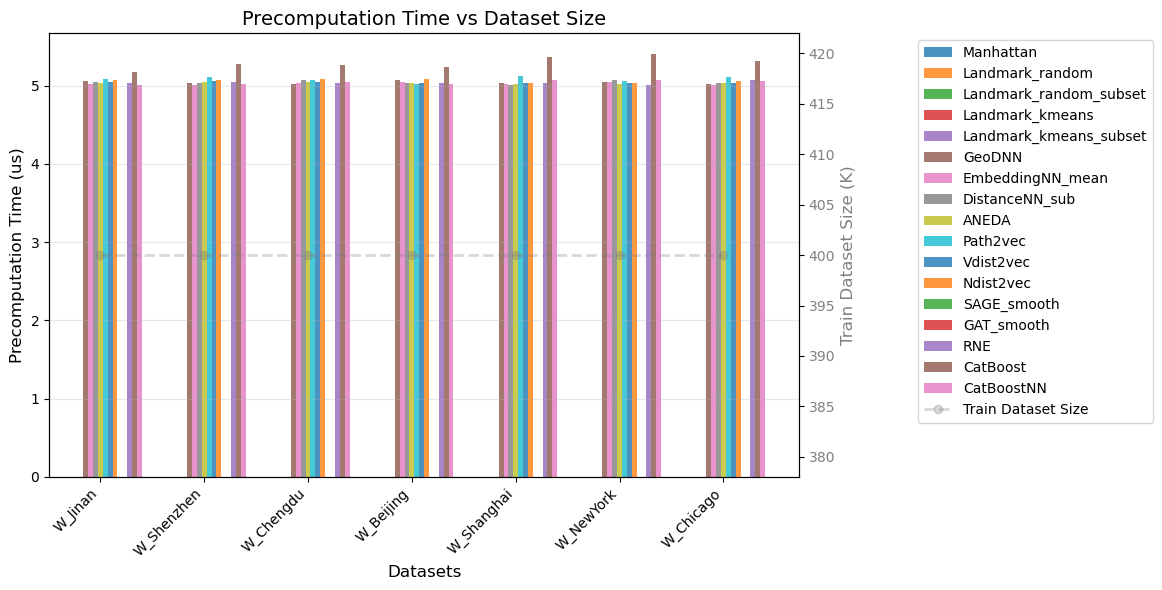

In [39]:
all_models = [
    'Manhattan',  # Better

    'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # # 'GCN',
    # 'GCN_smooth',
    'SAGE_smooth',  # Better than SAGE
    # 'SAGE',
    'GAT_smooth',  # Better than GAT
    # 'GAT',

    'RNE',

    'CatBoost',
    'CatBoostNN',
]

all_datasets = [
    'W_Jinan',  # 8.9k
    'W_Shenzhen',  # 11.9k
    'W_Chengdu',  # 17.5k
    'W_Beijing',  # 74.3k
    'W_Shanghai',  # 74.9k
    'W_NewYork',  # 334.9k
    'W_Chicago',  # 386.5k
]

def plot_metric_across_datasets(df, models, datasets, metric='precomputation_time'):
    plt.figure(figsize=(12, 6))

    # Create main axis for primary metric
    ax1 = plt.gca()

    # Calculate bar positions
    bar_width = 0.8 / len(models)  # Adjust total width to leave some space between groups
    x = np.arange(len(datasets))

    # Plot bars for each model
    for i, model in enumerate(models):
        model_data = df[df['model_name'] == model]
        # Create a DataFrame with all datasets and merge with model data to maintain order
        ordered_data = pd.DataFrame({'data_name': datasets})
        model_data = ordered_data.merge(model_data, on='data_name', how='left')

        ax1.bar(x + i*bar_width - (len(models)-1)*bar_width/2,
               model_data[metric],
               bar_width,
               label=model,
               alpha=0.8)

    # Customize primary axis
    ax1.set_xlabel('Datasets', fontsize=12)
    metric_name = metric.replace("_", " ").title()
    ax1.set_ylabel(f'{metric_name} ({metric_units[metric_name]})', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')

    # Create secondary axis for train dataset size
    ax2 = ax1.twinx()

    # Plot train dataset size as a light gray line
    data_sizes = df[['data_name', 'train_data_size']].drop_duplicates()
    # Reindex data_sizes to match dataset order
    data_sizes = pd.DataFrame({'data_name': datasets}).merge(data_sizes, on='data_name', how='left')

    ax2.plot(x,
             data_sizes['train_data_size'],
             color='gray',
             linestyle='--',
             alpha=0.3,
             linewidth=2,
             marker='o',
             label='Train Dataset Size')

    # Customize secondary axis
    ax2.set_ylabel('Train Dataset Size (K)', fontsize=12, color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
              bbox_to_anchor=(1.15, 1), loc='upper left')

    plt.title(f'{metric.replace("_", " ").title()} vs Dataset Size', fontsize=14)
    plt.tight_layout()
    plt.show()

df_filtered = df[df['model_name'].isin(all_models)]
plot_metric_across_datasets(df_filtered, all_models, all_datasets)

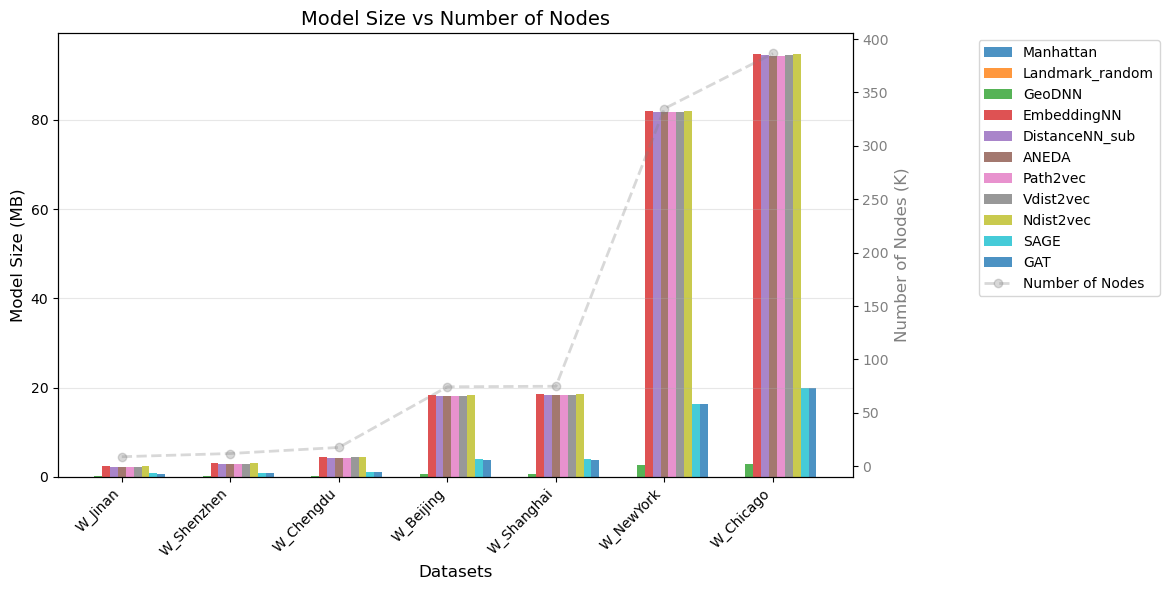

In [40]:
all_models = [
    'Manhattan',  # Better

    'Landmark_random',  # Better
    # 'Landmark_kmeans',

    'GeoDNN',

    'EmbeddingNN',  # Better
    # 'EmbeddingNN_mean',
    # 'EmbeddingNN_sub',

    # 'DistanceNN',
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random'

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # # 'GCN',
    'SAGE',
    'GAT',  # Better
]

def plot_model_size_across_datasets(df, models, datasets):
    plt.figure(figsize=(12, 6))

    # Create main axis for model size
    ax1 = plt.gca()

    # Calculate bar positions
    bar_width = 0.8 / len(models)  # Adjust total width to leave some space between groups
    x = np.arange(len(datasets))

    # Plot bars for each model
    for i, model in enumerate(models):
        model_data = df[df['model_name'] == model]
        # Create a DataFrame with all datasets and merge with model data to maintain order
        ordered_data = pd.DataFrame({'data_name': datasets})
        model_data = ordered_data.merge(model_data, on='data_name', how='left')

        ax1.bar(x + i*bar_width - (len(models)-1)*bar_width/2,
               model_data['model_size'],
               bar_width,
               label=model,
               alpha=0.8)

    # Customize primary axis
    ax1.set_xlabel('Datasets', fontsize=12)
    ax1.set_ylabel('Model Size (MB)', fontsize=12)
    ax1.set_xticks(x)
    ax1.set_xticklabels(datasets, rotation=45, ha='right')
    ax1.grid(True, alpha=0.3, axis='y')

    # Create secondary axis for number of nodes
    ax2 = ax1.twinx()

    # Plot number of nodes as a line
    node_counts = df[['data_name', 'num_nodes']].drop_duplicates()
    # Reindex node_counts to match dataset order
    node_counts = pd.DataFrame({'data_name': datasets}).merge(node_counts, on='data_name', how='left')

    ax2.plot(x,
             node_counts['num_nodes'],
             color='gray',
             linestyle='--',
             alpha=0.3,
             linewidth=2,
             marker='o',
             label='Number of Nodes')

    # Customize secondary axis
    ax2.set_ylabel('Number of Nodes (K)', fontsize=12, color='gray')
    ax2.tick_params(axis='y', labelcolor='gray')

    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2,
              bbox_to_anchor=(1.15, 1), loc='upper left')

    plt.title('Model Size vs Number of Nodes', fontsize=14)
    plt.tight_layout()
    plt.show()

# Filter data and plot
df_filtered = df[df['model_name'].isin(all_models)]
plot_model_size_across_datasets(df_filtered, all_models, all_datasets)

Max and min values in metric Precomputation Time (min): 5.1 MB, 5.0 MB


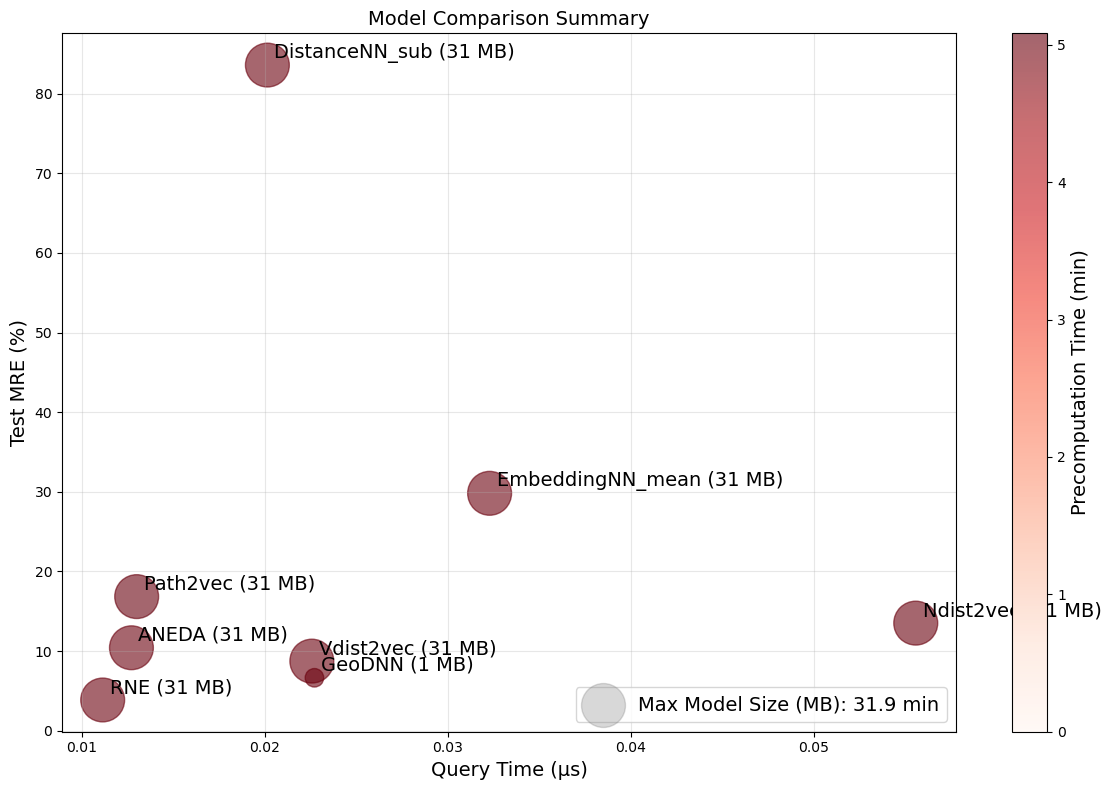


Summary of metrics:
| model_name       |   test_mre |   precomputation_time |   test_query_time |   model_size |
|:-----------------|-----------:|----------------------:|------------------:|-------------:|
| RNE              |       3.85 |                  5.04 |              0.01 |        31.71 |
| GeoDNN           |       6.64 |                  5.04 |              0.02 |         1.01 |
| Vdist2vec        |       8.73 |                  5.04 |              0.02 |        31.77 |
| ANEDA            |      10.41 |                  5.04 |              0.01 |        31.71 |
| Ndist2vec        |      13.5  |                  5.06 |              0.06 |        31.95 |
| Path2vec         |      16.83 |                  5.08 |              0.01 |        31.71 |
| EmbeddingNN_mean |      29.81 |                  5.03 |              0.03 |        31.84 |
| DistanceNN_sub   |      83.6  |                  5.04 |              0.02 |        31.73 |


In [41]:
def plot_combined_metrics(df, models):
    # Calculate mean metrics across datasets for each model
    # Dim1: x-axis
    # Dim2: y-axis
    # Dim3: size of circle
    # Dim4: color intensity

    # mean_metrics = df[df['model_name'].isin(models)].query("data_name == 'W_Chicago'")

    mean_metrics = df[df['model_name'].isin(models)].groupby('model_name').agg({
        'test_mre': 'mean',            # dim4: color intensity
        'precomputation_time': 'mean', # dim3: size of circle
        'test_query_time': 'mean',     # dim2: y-axis
        'model_size': 'mean',          # dim1: x-axis
    }).reset_index()

    plt.figure(figsize=(12, 8))


    metric_name = {
        'test_query_time': 'Query Time (μs)',
        'test_mre': 'Test MRE (%)',
        'precomputation_time': 'Precomputation Time (min)',
        'model_size': 'Model Size (MB)',
    }
    dim1 = 'test_query_time'
    dim2 = 'test_mre'
    dim3 = 'model_size'
    dim4 = 'precomputation_time'

    vmin = 0 # 0.2 * mean_metrics[dim4].max()
    vmax = mean_metrics[dim4].max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)

    scatter = plt.scatter(mean_metrics[dim1],  # X-axis
                         mean_metrics[dim2],  # Y-axis
                         s=1000 * np.sqrt(mean_metrics[dim3] / mean_metrics[dim3].max()),  # Area of circle
                         c=mean_metrics[dim4],  # Color intensity
                         cmap='Reds',
                         alpha=0.6,
                         norm=norm)

    cbar = plt.colorbar(scatter)
    print(f"Max and min values in metric {metric_name[dim4]}: {mean_metrics[dim4].max():.1f} MB, {mean_metrics[dim4].min():.1f} MB")
    cbar.set_label(metric_name[dim4], fontsize=14)

    # Plot annotations with model name and model size in MB
    for idx, row in mean_metrics.iterrows():
        label = f"{row['model_name']} ({int(row['model_size'])} MB)"
        plt.annotate(label,
                     (row[dim1], row[dim2]),
                     xytext=(5, 5),
                     textcoords='offset points',
                     fontsize=14,
                     )


    legend_elements = [plt.scatter([], [], s=1000,
                                 c='gray', alpha=0.3,
                                 label=f'Max {metric_name[dim3]}: {mean_metrics[dim3].max():.1f} min')]
    plt.legend(handles=legend_elements, loc='lower right', fontsize=14)

    plt.xlabel(metric_name[dim1], fontsize=14)
    plt.ylabel(metric_name[dim2], fontsize=14)
    plt.title('Model Comparison Summary', fontsize=14)
    # plt.xscale('log')
    # plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nSummary of metrics:")
    summary_df = mean_metrics.round(2)
    summary_df = summary_df.sort_values('test_mre')
    print(summary_df.to_markdown(index=False))

# Define models to include
all_models = [
    'Manhattan',  # Better

    'Landmark_random',
    'Landmark_random_subset', # Better than Landmark_random
    'Landmark_kmeans',  # Better than Landmark_random
    'Landmark_kmeans_subset', # Better than Landmark_kmeans #### Almost best

    'GeoDNN',

    # 'EmbeddingNN',  # alias, EmbeddingNN_concat
    'EmbeddingNN_mean',  # Better
    # 'EmbeddingNN_sub',

    # 'DistanceNN',  # alias, DistanceNN_concat
    # 'DistanceNN_mean',
    'DistanceNN_sub',  # Better

    'ANEDA',  # Better
    # 'ANEDA_random',

    'Path2vec',

    'Vdist2vec',
    'Ndist2vec',

    # # 'GCN',
    # 'GCN_smooth',
    'SAGE_smooth',  # Better than SAGE
    # 'SAGE',
    'GAT_smooth',  # Better than GAT
    # 'GAT',

    'RNE',

    # 'CatBoost',
    # 'CatBoostNN',
]

all_datasets = [
    'W_Jinan',  # 8.9k
    'W_Shenzhen',  # 11.9k
    'W_Chengdu',  # 17.5k
    'W_Beijing',  # 74.3k
    'W_Shanghai',  # 74.9k
    'W_NewYork',  # 334.9k
    'W_Chicago',  # 386.5k
]
plot_combined_metrics(df, all_models)


## OLD Code

In [11]:
df[['model_class', 'data_name', 'num_nodes', 'num_edges', 'train_data_size', 'test_data_size', 'model_params',
    'precomputation_time', 'model_size', 'test_query_time', 'test_mre']].query("model_class == 'rgnndist2vec'")

model_class   data_name  num_nodes  num_edges  train_data_size  \
6   rgnndist2vec   W_Beijing       74.4      103.4             13.2   
7   rgnndist2vec   W_Beijing       74.4      103.4             13.2   
8   rgnndist2vec   W_Beijing       74.4      103.4             13.2   
15  rgnndist2vec   W_Chicago      386.5      549.6            619.4   
16  rgnndist2vec   W_Chicago      386.5      549.6            619.4   
17  rgnndist2vec   W_Chicago      386.5      549.6            619.4   
24  rgnndist2vec   W_NewYork      334.9      445.9           2191.7   
25  rgnndist2vec   W_NewYork      334.9      445.9           2191.7   
26  rgnndist2vec   W_NewYork      334.9      445.9           2191.7   
33  rgnndist2vec     W_Jinan        8.9       14.1             94.2   
34  rgnndist2vec     W_Jinan        8.9       14.1             94.2   
35  rgnndist2vec     W_Jinan        8.9       14.1             94.2   
42  rgnndist2vec  W_Shenzhen       11.9       18.9             72.2   
43  rgnndist2vec  W_Shenzhen       11.9       18.9             72.2   
44  rgnndist2vec  W_Shenzhen       11.9       18.9             72.2   
51  rgnndist2vec   W_Chengdu       17.6       25.3             15.2   
52  rgnndist2vec   W_Chengdu       17.6       25.3             15.2   
53  rgnndist2vec   W_Chengdu       17.6       25.3             15.2   

    test_data_size  model_params  precomputation_time  model_size  \
6           1046.4          34.4                 0.17        3.86   
7           1046.4          68.2                 0.15        3.99   
8           1046.4          35.5                 0.17        3.86   
15           929.1          34.4                 1.13       19.86   
16           929.1          68.2                 1.00       19.99   
17           929.1          35.5                 1.37       19.86   
24           547.9          34.4                 3.80       16.30   
25           547.9          68.2                 3.22       16.43   
26           547.9          35.5                 4.77       16.30   
33          1036.0          34.4                 0.27        0.63   
34          1036.0          68.2                 0.26        0.76   
35          1036.0          35.5                 0.33        0.64   
42          1047.2          34.4                 0.25        0.80   
43          1047.2          68.2                 0.24        0.93   
44          1047.2          35.5                 0.29        0.81   
51          1046.9          34.4                 0.16        1.04   
52          1046.9          68.2                 0.15        1.17   
53          1046.9          35.5                 0.17        1.05   

    test_query_time  test_mre  
6             0.006     37.69  
7             0.007     16.16  
8             0.006      9.75  
15            0.010      8.58  
16            0.009      0.99  
17            0.009      1.26  
24            0.010     29.68  
25            0.010      6.58  
26            0.010      4.69  
33            0.007     45.67  
34            0.007     13.51  
35            0.007     13.46  
42            0.007     24.31  
43            0.007     11.09  
44            0.006      9.71  
51            0.007     14.25  
52            0.007     13.19  
53            0.007      9.78

In [10]:
df[['data_name', 'model_params',
    'precomputation_time', 'model_size', 'test_query_time', 'train_mre', 'test_mre']].query("data_name == 'W_Jinan'")

data_name  model_params  precomputation_time  model_size  test_query_time  \
27   W_Jinan           0.0                 0.00        0.10            0.003   
28   W_Jinan           0.0                 0.02        2.18            0.009   
29   W_Jinan           0.0                 0.03        2.18            0.009   
30   W_Jinan           4.2                 0.20        0.09            0.016   
31   W_Jinan         585.1                 0.20        2.24            0.020   
32   W_Jinan         629.9                 0.25        2.41            0.052   
33   W_Jinan          34.4                 0.27        0.63            0.007   
34   W_Jinan          68.2                 0.26        0.76            0.007   
35   W_Jinan          35.5                 0.33        0.64            0.007   
54   W_Jinan          65.0                 0.23        2.43            0.037   
55   W_Jinan          33.0                 0.22        2.30            0.029   
56   W_Jinan           9.0                 0.23        2.21            0.017   
57   W_Jinan           5.0                 0.23        2.20            0.017   
58   W_Jinan           5.0                 0.23        2.20            0.016   
59   W_Jinan         570.1                 0.22        2.18            0.013   
60   W_Jinan         570.1                 0.23        2.18            0.013   

    train_mre  test_mre  
27     100.00    100.00  
28     138.82    170.69  
29     104.85    137.63  
30      27.55     36.47  
31      47.16     70.96  
32      32.03     39.64  
33      29.88     45.67  
34      13.48     13.51  
35      12.78     13.46  
54      33.41     53.32  
55      47.19     69.47  
56     139.34    191.22  
57     177.66    232.54  
58      62.23     71.46  
59      11.55     14.87  
60     436.65    577.55

In [69]:
df[['data_name', 'aggregation_method', 'embedding_name', 'model_params',
    'precomputation_time', 'model_size', 'test_query_time', 'train_mre', 'test_mre']].query("data_name == 'Dhaka'").pivot(
        index='aggregation_method',
        columns='embedding_name',
        values='test_mre'
    )

embedding_name      line_unweighted  line_weighted  node2vec_unweighted  \
aggregation_method                                                        
concat                        67.13          69.44                20.05   
hadamard                     108.09         110.04                63.62   
mean                          90.10          84.39                30.15   
subtract                      87.89          82.23                35.49   

embedding_name      node2vec_weighted  
aggregation_method                     
concat                          23.27  
hadamard                        67.12  
mean                            37.25  
subtract                        42.75

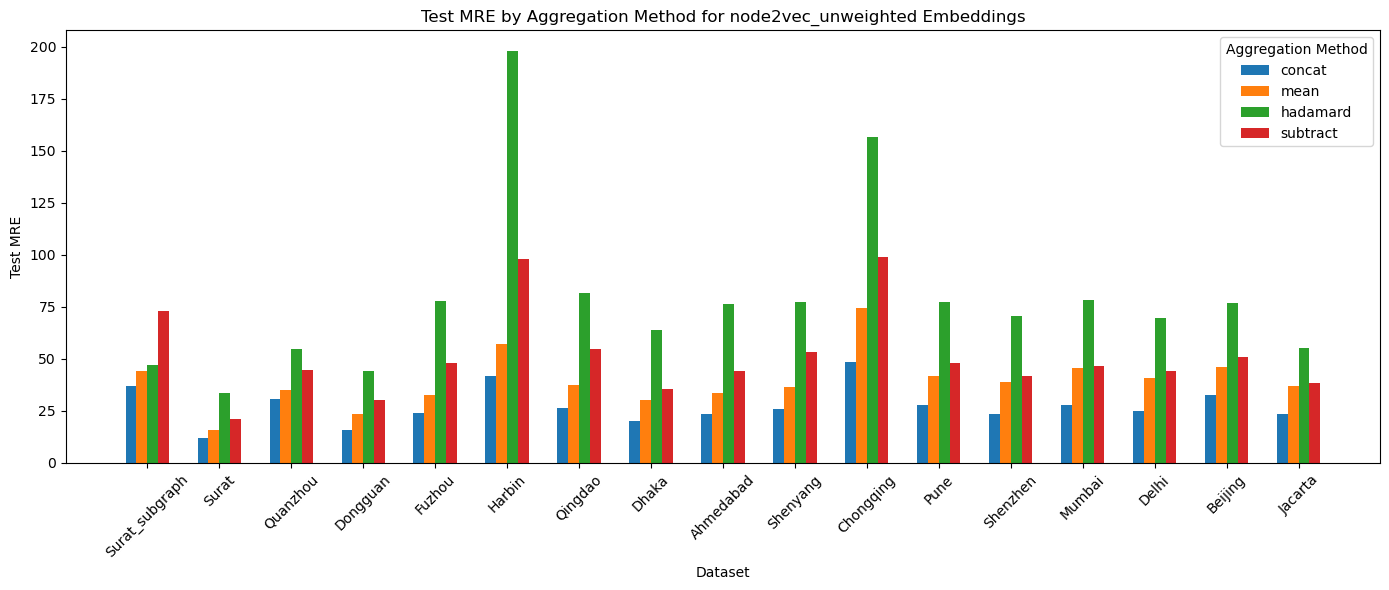

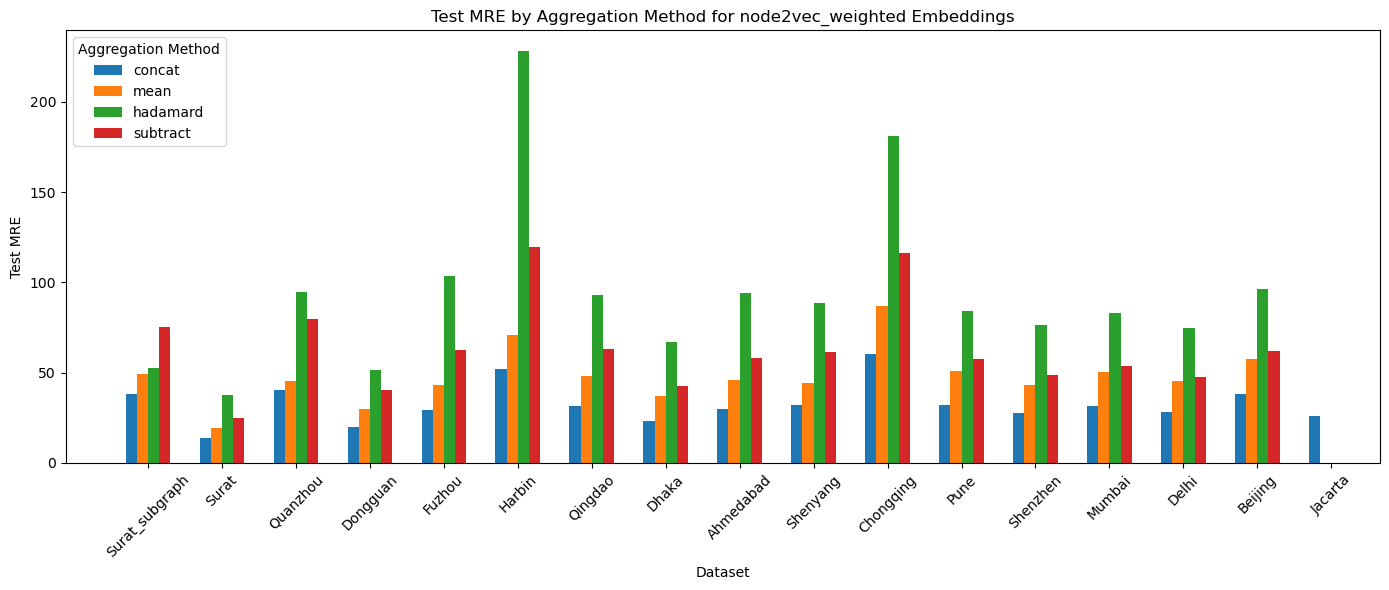

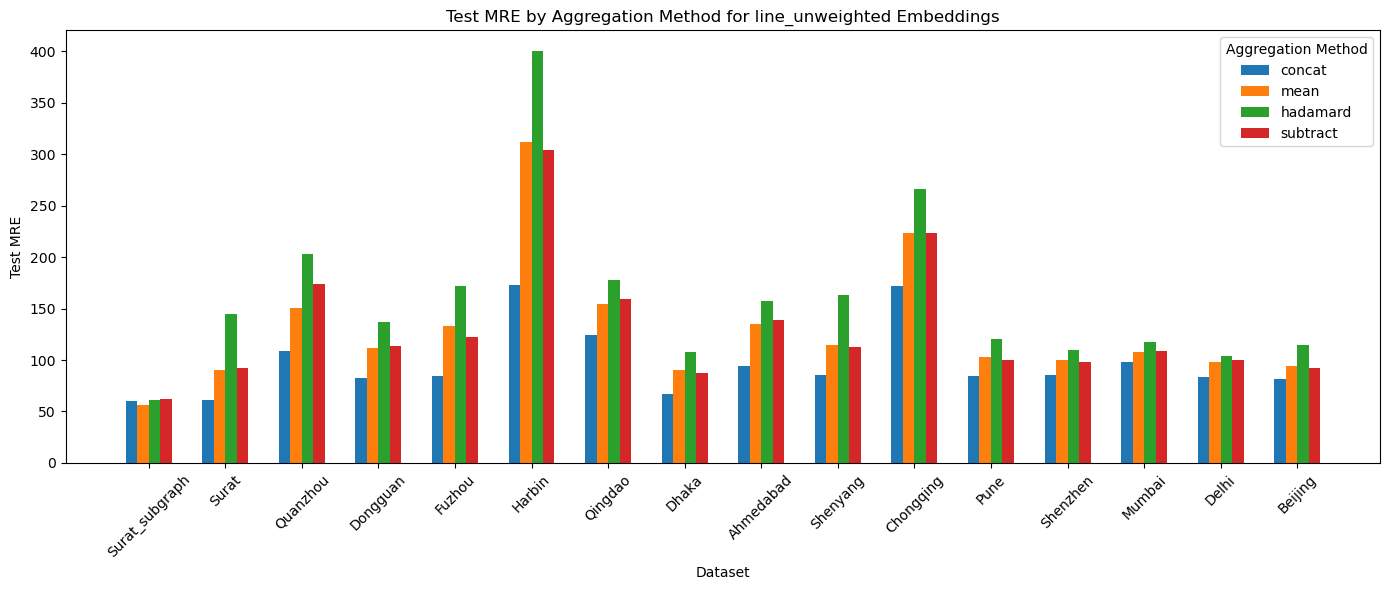

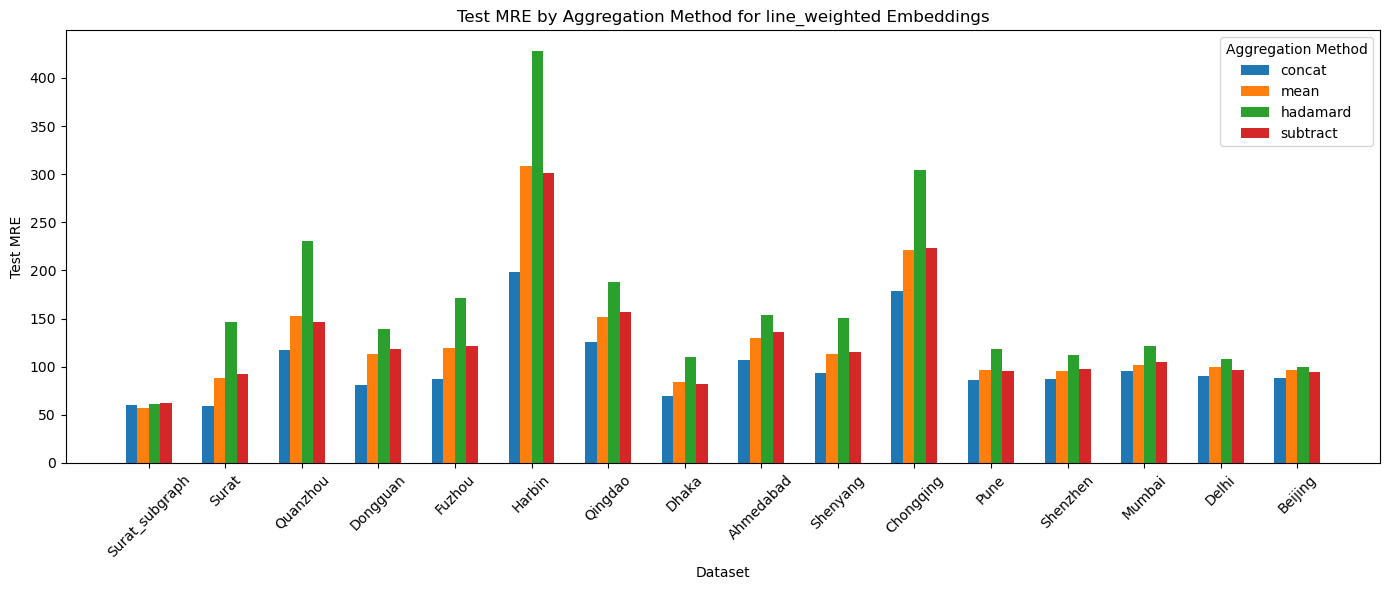

In [72]:
import numpy as np

import matplotlib.pyplot as plt

for embedding in df['embedding_name'].unique():
    # Filter for node2vec_unweighted embeddings
    filtered_df = df[df['embedding_name'] == embedding]

    # Get unique datasets and aggregation methods
    datasets = filtered_df['data_name'].unique()
    agg_methods = filtered_df['aggregation_method'].unique()

    # Prepare data for plotting
    bar_width = 0.15
    x = np.arange(len(datasets))

    plt.figure(figsize=(14, 6))

    for i, agg in enumerate(agg_methods):
        values = []
        for dataset in datasets:
            val = filtered_df[(filtered_df['data_name'] == dataset) & (filtered_df['aggregation_method'] == agg)]['test_mre']
            values.append(val.values[0] if not val.empty else np.nan)
        plt.bar(x + i * bar_width, values, width=bar_width, label=agg)

    plt.xlabel('Dataset')
    plt.ylabel('Test MRE')
    plt.title(f'Test MRE by Aggregation Method for {embedding} Embeddings')
    plt.xticks(x + bar_width * (len(agg_methods)-1)/2, datasets, rotation=45)
    plt.legend(title='Aggregation Method')
    plt.tight_layout()
    plt.show()

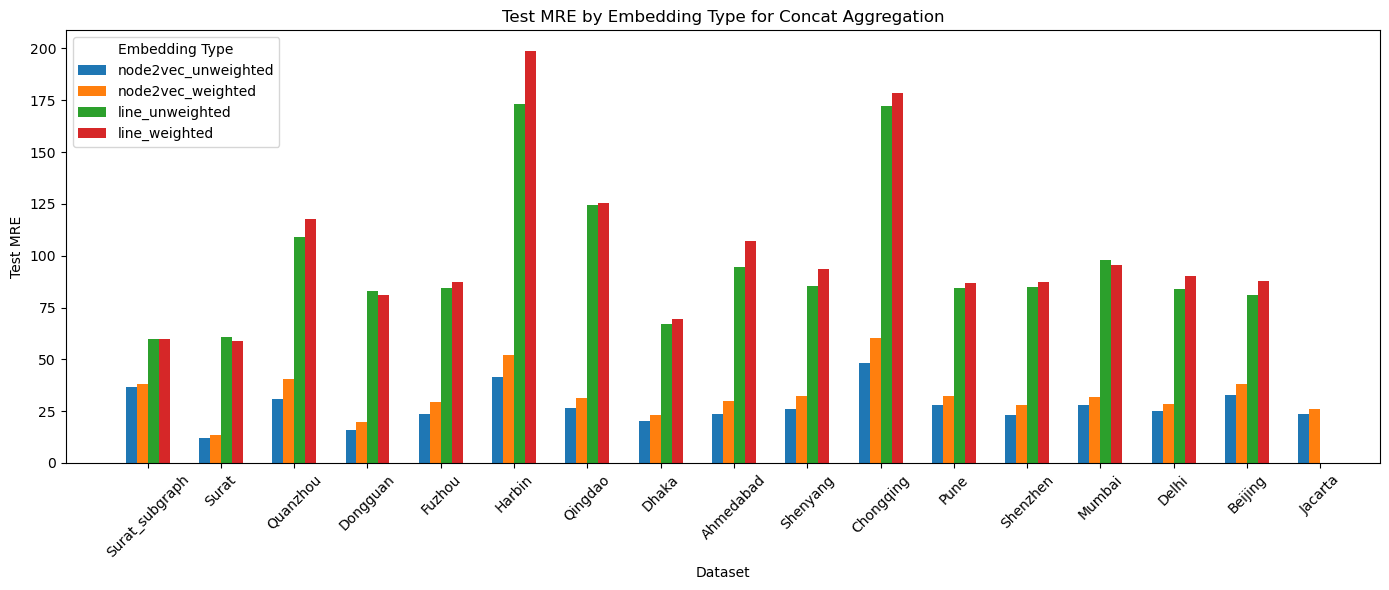

In [71]:
# Compare test_mre across different embedding types for 'concat' aggregation

embed_types = df['embedding_name'].unique()
datasets = df['data_name'].unique()
bar_width = 0.15
x = np.arange(len(datasets))

plt.figure(figsize=(14, 6))

for i, embed in enumerate(embed_types):
    filtered_df = df[(df['embedding_name'] == embed) & (df['aggregation_method'] == 'concat')]
    values = []
    for dataset in datasets:
        val = filtered_df[filtered_df['data_name'] == dataset]['test_mre']
        values.append(val.values[0] if not val.empty else np.nan)
    plt.bar(x + i * bar_width, values, width=bar_width, label=embed)

plt.xlabel('Dataset')
plt.ylabel('Test MRE')
plt.title('Test MRE by Embedding Type for Concat Aggregation')
plt.xticks(x + bar_width * (len(embed_types)-1)/2, datasets, rotation=45)
plt.legend(title='Embedding Type')
plt.tight_layout()
plt.show()

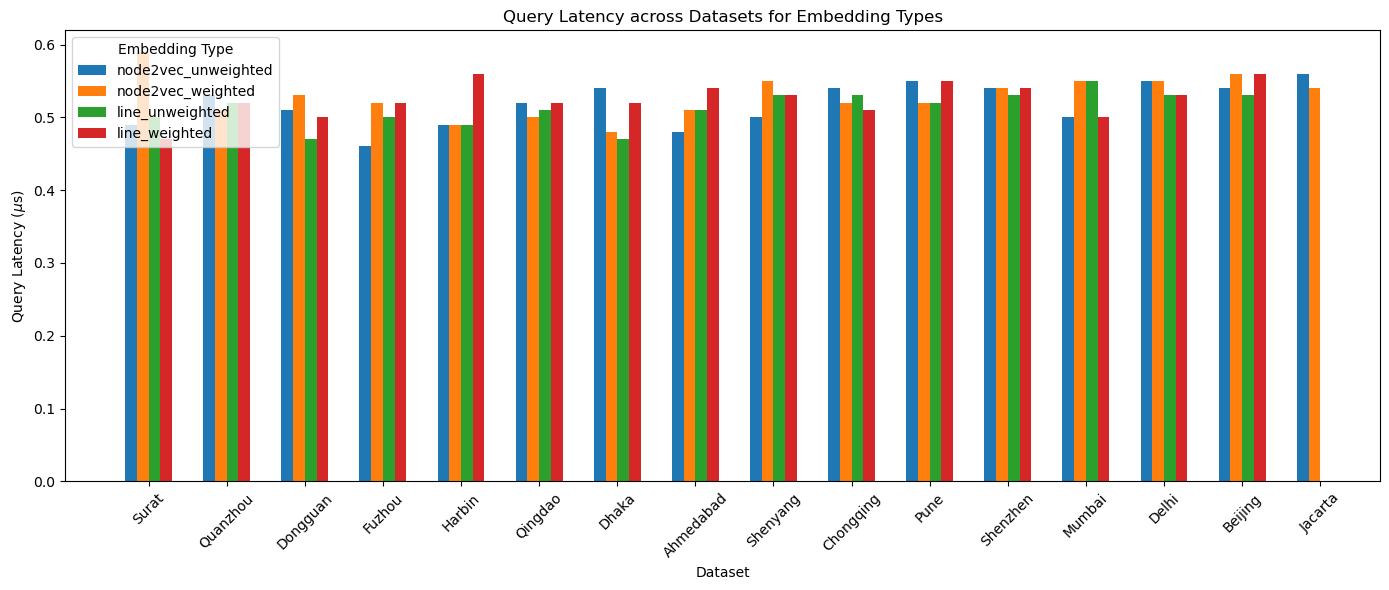

In [78]:
# Plot query latency across datasets for each embedding type (skip 'Surat_subgraph')

embed_types = df['embedding_name'].unique()
datasets_to_plot = [d for d in df['data_name'].unique() if d != 'Surat_subgraph']
bar_width = 0.15
x = np.arange(len(datasets_to_plot))

plt.figure(figsize=(14, 6))

for i, embed in enumerate(embed_types):
    filtered_df = df[df['embedding_name'] == embed]
    values = []
    for dataset in datasets_to_plot:
        val = filtered_df[filtered_df['data_name'] == dataset]['test_query_time']
        values.append(val.values[0] if not val.empty else np.nan)
    plt.bar(x + i * bar_width, values, width=bar_width, label=embed)

plt.xlabel('Dataset')
plt.ylabel('Query Latency ($\mu$s)')
plt.title('Query Latency across Datasets for Embedding Types')
plt.xticks(x + bar_width * (len(embed_types)-1)/2, datasets_to_plot, rotation=45)
plt.legend(title='Embedding Type')
plt.tight_layout()
plt.show()


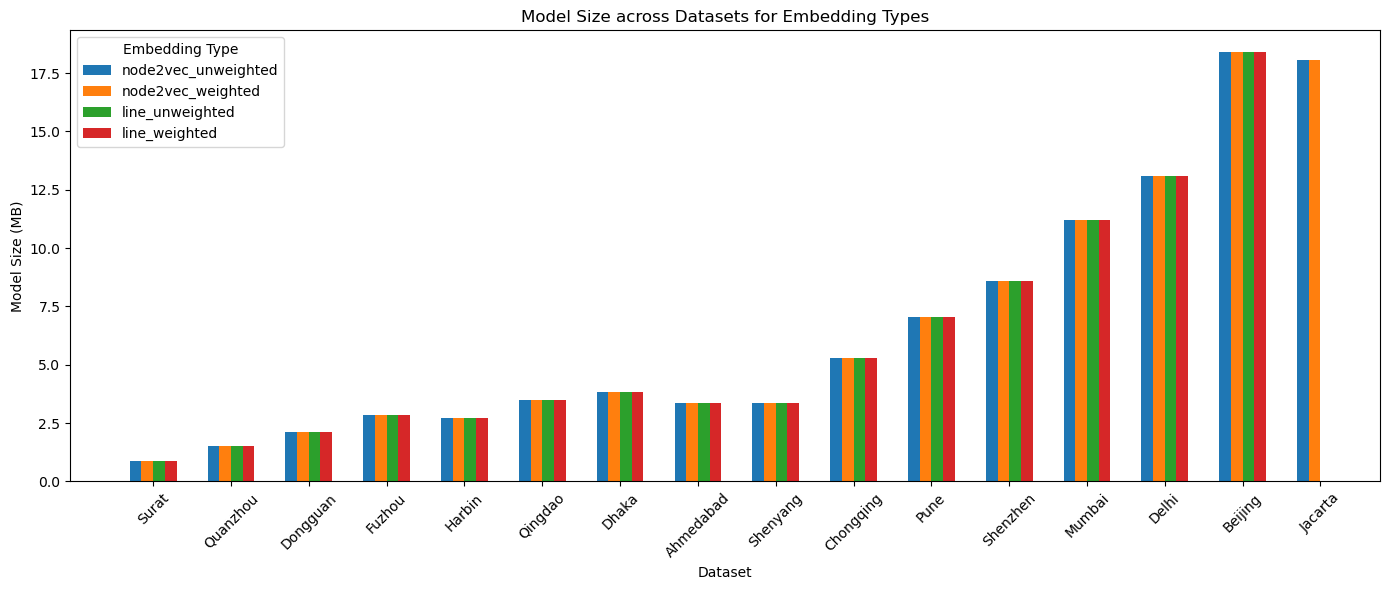

In [79]:
# Plot model size across datasets for each embedding type (skip 'Surat_subgraph')

embed_types = df['embedding_name'].unique()
datasets_to_plot = [d for d in df['data_name'].unique() if d != 'Surat_subgraph']
bar_width = 0.15
x = np.arange(len(datasets_to_plot))

plt.figure(figsize=(14, 6))

for i, embed in enumerate(embed_types):
    filtered_df = df[df['embedding_name'] == embed]
    values = []
    for dataset in datasets_to_plot:
        val = filtered_df[filtered_df['data_name'] == dataset]['model_size']
        values.append(val.values[0] if not val.empty else np.nan)
    plt.bar(x + i * bar_width, values, width=bar_width, label=embed)

plt.xlabel('Dataset')
plt.ylabel('Model Size (MB)')
plt.title('Model Size across Datasets for Embedding Types')
plt.xticks(x + bar_width * (len(embed_types)-1)/2, datasets_to_plot, rotation=45)
plt.legend(title='Embedding Type')
plt.tight_layout()
plt.show()


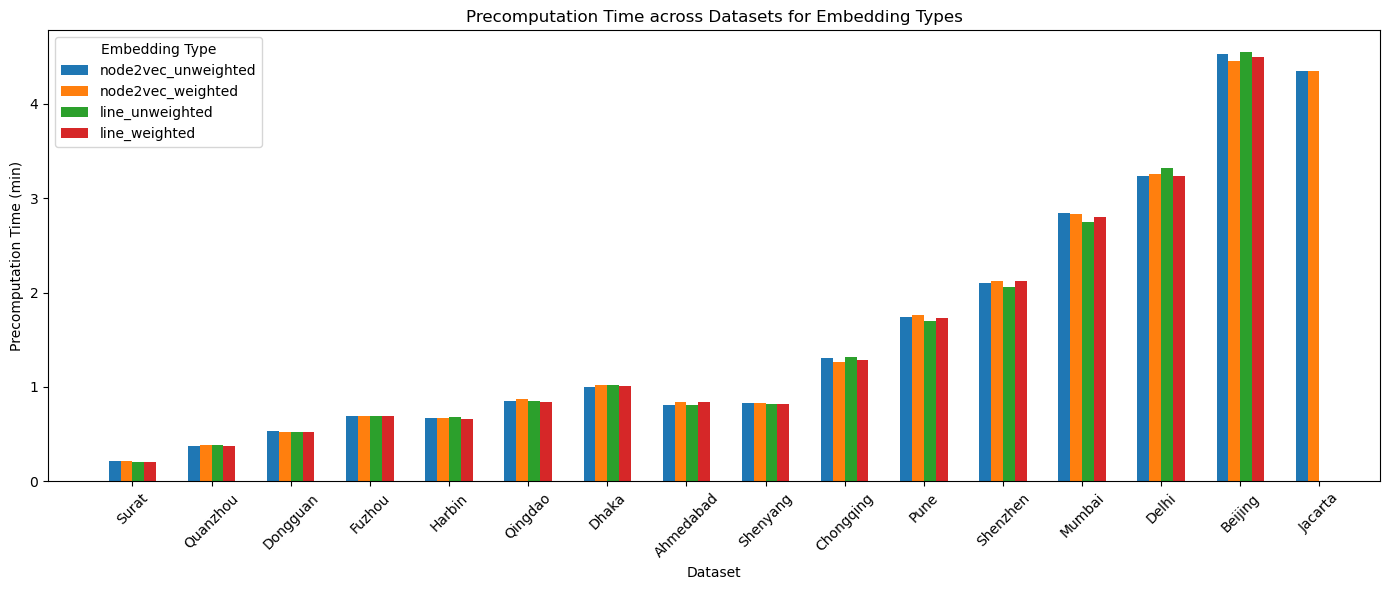

In [81]:
# Plot precomputation time across datasets for each embedding type (skip 'Surat_subgraph')

embed_types = df['embedding_name'].unique()
datasets_to_plot = [d for d in df['data_name'].unique() if d != 'Surat_subgraph']
bar_width = 0.15
x = np.arange(len(datasets_to_plot))

plt.figure(figsize=(14, 6))

for i, embed in enumerate(embed_types):
    filtered_df = df[df['embedding_name'] == embed]
    values = []
    for dataset in datasets_to_plot:
        val = filtered_df[filtered_df['data_name'] == dataset]['precomputation_time']
        values.append(val.values[0] if not val.empty else np.nan)
    plt.bar(x + i * bar_width, values, width=bar_width, label=embed)

plt.xlabel('Dataset')
plt.ylabel('Precomputation Time (min)')
plt.title('Precomputation Time across Datasets for Embedding Types')
plt.xticks(x + bar_width * (len(embed_types)-1)/2, datasets_to_plot, rotation=45)
plt.legend(title='Embedding Type')
plt.tight_layout()
plt.show()


In [3]:
parse_worker_log("../results/logs/expt19-train-v2-small-urban-landmark/train_GeoDNN_Rome.log")

{'model_class': 'GeoDNN',
 'model_name': 'GeoDNN',
 'data_name': 'Rome',
 'data_strategy': 'landmark',
 'data_version': 'v2-urban-landmark',
 'seed': 42,
 'num_nodes': 158546,
 'num_edges': 209321,
 'train_data_size': 15854500,
 'train_data_distance_mean': 34553.52,
 'test_data_size': 15854500,
 'test_data_distance_mean': 32925.74,
 'model_params': 4241,
 'loss_function': 'MSELoss',
 'optimizer': 'Adam',
 'gpu_name': 'NVIDIA A30',
 'device': 'cuda',
 'precomputation_time': '12.33 minutes',
 'model_size': '1.23 MB',
 'train_evaluation_time': '0.43 minutes',
 'train_mae': 732.86,
 'train_mre': 'inf%',
 'train_query_time': '0.67 microseconds',
 'test_evaluation_time': '0.37 minutes',
 'test_mae': 1478.52,
 'test_mre': '6.12%',
 'test_query_time': '0.66 microseconds',
 'average_query_time': '0.62 microseconds'}

## Parse Log File

In [5]:
# Parse master log file
master_log_filenames = [
    # *glob("../results/logs/expt18-train-small-v1-landmark/train-master-*.log"),
    # *glob("../results/logs/expt18-train-medium-v1-landmark/train-master-*.log"),
    # *glob("../results/logs/expt18-train-large-v1-landmark/train-master-*.log"),
    *glob("../results/logs/expt19-train-v2-small-urban-landmark/train-master-*.log"),
    *glob("../results/logs/expt19-train-v2-medium-urban-landmark/train-master-*.log"),
    # *glob("../results/logs/expt19-train-v2-dimacs-landmark/train-master-*.log"),
]
df_list = []
for master_log_filename in master_log_filenames:
    if not os.path.exists(master_log_filename):
        print(f"Master log file {master_log_filename} does not exist.")
        continue
    print(f"Parsing master log file: {master_log_filename}")
    df = parse_master_log(master_log_filename)
    df = convert_units(df)
    print(f"Parsed DataFrame shape: {df.shape}")
    df_list.append(df)
    print(df.to_markdown(index=False))

# Combine all DataFrames into one
results_df = pd.concat(df_list, ignore_index=True)
print("Combined DataFrame shape:", results_df.shape)

# Save results to CSV file
file_name = "../results/parsed_results.csv"
print("Saving results to:", file_name)
results_df.to_csv(file_name, index=False)

Parsing master log file: ../results/logs/expt19-train-v2-small-urban-landmark/train-master-8663744.log


1309it [00:02, 439.76it/s]


Parsed DataFrame shape: (100, 33)
| python_command                                                                                                                                                                                                                                                                              | log_output                                                                                  | expt_name                            | model_class   | model_name         | data_name   | data_strategy   | data_version      |   seed |   num_nodes |   num_edges |   train_data_size |   train_data_distance_mean |   test_data_size |   test_data_distance_mean |   model_params | gpu_name   | device   |   precomputation_time |   model_size |   train_evaluation_time |   train_mae |   train_mre |   train_query_time |   test_evaluation_time |   test_mae |   test_mre |   test_query_time |   average_query_time |   max_cpu_memory |   time_elapsed | loss_function   | optimizer   |
|:----

509it [00:01, 360.57it/s]


Parsed DataFrame shape: (44, 33)
| python_command                                                                                                                                                                                                                                                                             | log_output                                                                                 | expt_name                             | model_class   | model_name         | data_name   | data_strategy   | data_version      |   seed |   num_nodes |   num_edges |   train_data_size |   train_data_distance_mean |   test_data_size |   test_data_distance_mean |   model_params | gpu_name   | device   |   precomputation_time |   model_size |   train_evaluation_time |   train_mae |   train_mre |   train_query_time |   test_evaluation_time |   test_mae |   test_mre |   test_query_time |   average_query_time |   max_cpu_memory |   time_elapsed | loss_function   | optimizer   |
|:------

In [6]:
df.tail()

python_command  \
39  python train_rgnndist2vec.py --gnn_layer_type ...   
40  python train_landmark.py --model_strategy rand...   
41  python train_landmark.py --model_strategy kmea...   
42  python train_landmark.py --model_strategy degr...   
43  python train_landmark.py --model_strategy page...   

                                           log_output  \
39  ../results/logs/expt19-train-v2-medium-urban-l...   
40  ../results/logs/expt19-train-v2-medium-urban-l...   
41  ../results/logs/expt19-train-v2-medium-urban-l...   
42  ../results/logs/expt19-train-v2-medium-urban-l...   
43  ../results/logs/expt19-train-v2-medium-urban-l...   

                                expt_name   model_class          model_name  \
39  expt19-train-v2-medium-urban-landmark  RGNNdist2vec  GAT_no_edge_weight   
40  expt19-train-v2-medium-urban-landmark      Landmark     Landmark_random   
41  expt19-train-v2-medium-urban-landmark      Landmark     Landmark_kmeans   
42  expt19-train-v2-medium-urban-landmark      Landmark     Landmark_degree   
43  expt19-train-v2-medium-urban-landmark      Landmark   Landmark_pagerank   

   data_name data_strategy       data_version  seed  num_nodes  num_edges  \
39     Paris      landmark  v2-urban-landmark    42      461.5      629.5   
40    Moscow      landmark  v2-urban-landmark    42      685.1      924.7   
41    Moscow      landmark  v2-urban-landmark    42      685.1      924.7   
42    Moscow      landmark  v2-urban-landmark    42      685.1      924.7   
43    Moscow      landmark  v2-urban-landmark    42      685.1      924.7   

    train_data_size  train_data_distance_mean  test_data_size  \
39          46154.1                  30618.81         46154.1   
40          68509.0                  71909.48         68509.0   
41          68509.0                  71909.48         68509.0   
42          68509.0                  71909.48         68509.0   
43          68509.0                  71909.48         68509.0   

    test_data_distance_mean  model_params    gpu_name device  \
39                 33274.70         35.52  NVIDIA A30   cuda   
40                 73493.13          0.00  NVIDIA A30   cuda   
41                 73493.13          0.00  NVIDIA A30   cuda   
42                 73493.13          0.00  NVIDIA A30   cuda   
43                 73493.13          0.00  NVIDIA A30   cuda   

    precomputation_time  model_size  train_evaluation_time  train_mae  \
39               102.52       22.87                   1.22     372.01   
40                 2.35        0.00                   1.81    2439.67   
41                 2.45        0.00                   1.74    2553.34   
42                 2.68        0.00                   1.93    4915.82   
43                 2.38        0.00                   1.63    2402.55   

    train_mre  train_query_time  test_evaluation_time  test_mae  test_mre  \
39       1.69              0.32                  1.05    551.79       2.2   
40      14.80              0.35                  1.38   2489.21       inf   
41      12.79              0.34                  1.44   2566.33       inf   
42      19.33              0.40                  1.42   4942.78       inf   
43      12.37              0.35                  1.42   2389.62       inf   

    test_query_time  average_query_time  max_cpu_memory  time_elapsed  \
39             0.33                0.33            5.80        107.43   
40             0.35                0.34            7.20          9.20   
41             0.37                0.39            7.21          9.49   
42             0.36                0.38            7.21          9.84   
43             0.36                0.39            7.23          9.20   

   loss_function optimizer  
39  SmoothL1Loss      Adam  
40           NaN       NaN  
41           NaN       NaN  
42           NaN       NaN  
43           NaN       NaN

In [7]:
assert df['expt_name'].nunique() == 1, "There should be only one experiment name in the log file."
assert df['data_strategy'].nunique() == 1, "There should be only one data strategy in the log file."
assert df['data_version'].nunique() == 1, "There should be only one data version in the log file."
assert df['gpu_name'].nunique() == 1, "There should be only one GPU name in the log file."
assert df['device'].nunique() == 1, "There should be only one device in the log file."
assert df['optimizer'].nunique() == 1, "There should be only one optimizer in the log file."
assert (df['train_data_size'].fillna(0) == df['test_data_size'].fillna(0)).all(), "Train and test data sizes should be equal in the log file."
# assert df['loss_function'].nunique() == 1, "There should be only one loss function in the log file."

In [8]:
data_order = [
    # ## Small (<10k nodes) ##
    "Surat",  # 1843
    "Quanzhou",  # 3079
    "Dongguan",  # 4606
    "Fuzhou",  # 5955
    "Harbin",  # 6328
    "Qingdao",  # 7992
    "Dhaka",  # 8349
    "Ahmedabad",  # 8808
    "Shenyang",  # 9020
    "Chongqing",  # 9519

    ## Medium (10k-100k nodes) ##
    "Pune",  # 14542
    "Shenzhen",  # 21809
    "Mumbai",  # 25668
    "Delhi",  # 37971
    "Beijing",  # 45201
    "Jacarta",  # 50215
    "Naples",  # 63070
    "Hyderabad",  # 74357
    "Rome",  # 87739
    "Istambul",  # 98573

    ## Large (100k-1M nodes) ##
    "Atlanta",  # 113028
    "Milan",  # 119638
    "London",  # 150598
    "Boston",  # 181666
    "NewYork",  # 190368
    "Phoenix",  # 200519
    "LosAngeles",  # 228185
    "Chicago",  # 259887
    "Paris",  # 281031
    "Moscow",  # 406505

    ## Extra Large (>1M nodes) ##
    # ...
]
model_order = [
    # LpNorm
    "Manhattan",
    "Euclidean",

    # Landmark
    'Landmark_random',
    'Landmark_kmeans',
    'Landmark_betweenness_high',
    'Landmark_degree',
    'Landmark_pagerank',
    # 'Landmark_betweenness_low',
    # 'Landmark_closeness_high',
    # 'Landmark_closeness_low',
    # 'Landmark_eigenvector',
    # 'Landmark_katz',
    # 'Landmark_harmonic',

    # NN
    'GeoDNN',
    'Vdist2vec',
    'Ndist2vec',

    # GNN
    'GCN_no_edge_weight',
    'GCN',
    'SAGE',
    'GAT_no_edge_weight',
    'GAT',
]

def pivot_by(df, value):
    """
    Pivots the DataFrame by the specified value.
    """
    local_model_order = [model for model in model_order if model in df['model_name'].unique()]
    local_data_order = [data for data in data_order if data in df['data_name'].unique()]
    # local_data_order = [data for data in data_order if data in df.columns]
    df = df.loc[df['model_name'].isin(local_model_order) & df['data_name'].isin(local_data_order)]
    # print(df.shape)
    pivot_table = df.pivot(
        index='model_name',
        columns='data_name',
        values=value
    )
    return pivot_table.loc[local_model_order, local_data_order]
    # return pivot_table.loc[model_order, data_order]

In [9]:
# Print the results in a pivot table format
cols = [
    'model_params',
    'train_mre',
    'test_mre',
    'precomputation_time',
    'train_query_time',
    'test_query_time',
    'model_size',
    'max_cpu_memory',
    'num_nodes',
]

for col in cols:
    print(f"======== {col} ========")
    pivot_table = pivot_by(results_df, col)
    print(pivot_table.shape)
    print(pivot_table.to_markdown())

======== model_params ========
(10, 15)
| model_name         |   Surat |   Dongguan |   Harbin |   Ahmedabad |   Chongqing |   Shenzhen |   Delhi |   Beijing |   Hyderabad |     Rome |   London |   NewYork |   Chicago |    Paris |   Moscow |
|:-------------------|--------:|-----------:|---------:|------------:|------------:|-----------:|--------:|----------:|------------:|---------:|---------:|----------:|----------:|---------:|---------:|
| Landmark_random    |    0    |       0    |     0    |        0    |        0    |       0    |    0    |      0    |        0    |     0    |     0    |      0    |      0    |     0    |        0 |
| Landmark_kmeans    |    0    |       0    |     0    |        0    |        0    |       0    |    0    |      0    |        0    |     0    |     0    |      0    |      0    |     0    |        0 |
| Landmark_degree    |    0    |       0    |     0    |        0    |        0    |       0    |    0    |      0    |        0    |     0    |     0  

In [10]:
def plot_metric_by_datasets(results_df, metric, ordered_models, ordered_datasets, secondary_metric=None):
    model_name_mapping = {
        "Manhattan": "Manhattan (1-norm)",
        "Euclidean": "Euclidean (2-norm)",
        "Landmark_random": "Landmark (random)",
        "Landmark_kmeans": "Landmark (k-means)",
        "Landmark_pagerank": "Landmark (pagerank)",
        "Landmark_degree": "Landmark (degree)",
        "Landmark_betweenness_high": "Landmark (betweenness high)",
        "Landmark_betweenness_low": "Landmark (betweenness low)",
        "Landmark_closeness_high": "Landmark (closeness high)",
        "Landmark_closeness_low": "Landmark (closeness low)",
        "Landmark_eigenvector": "Landmark (eigenvector)",
        "Landmark_katz": "Landmark (katz)",
        "Landmark_harmonic": "Landmark (harmonic)",
        "GeoDNN": "GeoDNN",
        "Vdist2vec": "Vdist2vec",
        "Ndist2vec": "Ndist2vec",
        "GCN": "GCN",
        "GCN_no_edge_weight": "GCN (no edge weight)",
        "SAGE": "SAGE",
        "GAT": "GAT",
        "GAT_no_edge_weight": "GAT (no edge weight)",
    }

    ## Markers reference: https://matplotlib.org/stable/api/markers_api.html
    # linestyles hierarchy: solid '-' > dashed '--' > dotted ':'
    markers = ['o', 's', 'D', 'p', '*', '^', 'v', '>', '<', 'h', 'H', 'X', 'd', '|', '_']

    ## Colors reference: https://matplotlib.org/stable/users/explain/colors/colormaps.html#qualitative
    # marker hierarchy: circle 'o' > square 's' > star '*'
    colors = colormaps['tab20']
    style_mapping = {
        "Manhattan": {"linestyle": '-', 'marker': 'o', 'color': colors(14)},  # Grey
        "Euclidean": {"linestyle": '--', 'marker': 's', 'color': colors(15)},
        "Landmark_random": {"linestyle": '--', 'marker': 's', 'color': colors(9)},
        "Landmark_kmeans": {"linestyle": '-', 'marker': 'o', 'color': colors(8)},  # Brown
        "Landmark_pagerank": {"linestyle": ':', 'marker': '*', 'color': colors(9)},
        "Landmark_degree": {"linestyle": ':', 'marker': 'd', 'color': colors(9)},
        "Landmark_betweenness_high": {"linestyle": ':', 'marker': '^', 'color': colors(9)},
        "Landmark_betweenness_low": {"linestyle": ':', 'marker': 'v', 'color': colors(9)},
        "Landmark_closeness_high": {"linestyle": ':', 'marker': '<', 'color': colors(9)},
        "Landmark_closeness_low": {"linestyle": ':', 'marker': '>', 'color': colors(9)},
        "Landmark_eigenvector": {"linestyle": ':', 'marker': 'P', 'color': colors(9)},
        "Landmark_katz": {"linestyle": ':', 'marker': 'X', 'color': colors(9)},
        "Landmark_harmonic": {"linestyle": ':', 'marker': 'D', 'color': colors(9)},
        "GeoDNN": {"linestyle": '-', 'marker': 'o', 'color': colors(2)},  # Orange
        "Vdist2vec": {"linestyle": '-', 'marker': 'o', 'color': colors(1)},
        "Ndist2vec": {"linestyle": '-', 'marker': 'o', 'color': colors(0)},  # Blue
        "GCN": {"linestyle": ':', 'marker': '^', 'color': colors(5)},
        "GCN_no_edge_weight": {"linestyle": ':', 'marker': '*', 'color': colors(5)},
        "SAGE": {"linestyle": '--', 'marker': 's', 'color': colors(3)},  # Light Orange
        "GAT": {"linestyle": '-', 'marker': 'X', 'color': colors(5)},
        "GAT_no_edge_weight": {"linestyle": '-', 'marker': 'o', 'color': colors(4)}, # Green
    }
    axis_label_mapping = {
        'model_params': 'Model Parameters (in K)',
        'train_mre': 'Train MRE (%)',
        'test_mre': 'Test MRE (%)',
        'precomputation_time': 'Precomputation Time (min)',
        'train_query_time': 'Train Query Time ($\mu$s)',
        'test_query_time': 'Test Query Time ($\mu$s)',
        'model_size': 'Model Size (in MB)',
        'max_cpu_memory': 'Max CPU Memory (in GB)',
        'train_data_size': 'Train Queries (in K)',
        'test_data_size': 'Test Queries (in K)',
        'num_nodes': 'No. of Nodes (in K)',
        'num_edges': 'No. of Edges (in K)',
    }
    title_mapping = {
        'model_params': 'Model Parameters',
        'train_mre': 'Train MRE',
        'test_mre': 'Test MRE',
        'precomputation_time': 'Precomputation Time',
        'train_query_time': 'Train Query Time',
        'test_query_time': 'Test Query Time',
        'model_size': 'Model Size',
        'max_cpu_memory': 'Max CPU Memory',
        'train_data_size': 'Train Data Size',
        'test_data_size': 'Test Data Size',
        'num_nodes': 'Number of Nodes',
        'num_edges': 'Number of Edges',
    }
    local_ordered_models = [m for m in ordered_models if m in results_df['model_name'].unique()]
    local_ordered_datasets = [d for d in ordered_datasets if d in results_df['data_name'].unique()]

    # Create the figure and main axis
    fig, ax = plt.subplots(figsize=(12, 6))

    for idx, model in enumerate(local_ordered_models):
        # Filter results for the current model
        subset = results_df.query(f"model_name == '{model}'")
        # Ensure correct order of datasets
        y = [subset.query(f"data_name == '{d}'")[metric].values[0] if d in subset['data_name'].values else None for d in local_ordered_datasets]
        # Plot the data
        ax.plot(
            local_ordered_datasets,
            y,
            label=model_name_mapping.get(model, model),
            **style_mapping.get(model, {}),
            markersize=8,
            linewidth=2
        )
    ax.set_xlabel("Dataset (increasing size)", fontsize=24)
    ax.set_ylabel(axis_label_mapping[metric], fontsize=24)
    ax.legend(title="Model", bbox_to_anchor=(1.1 if secondary_metric else 1.01, 1), loc='upper left')

    # Plot 'secondary_metric' on a secondary (twin-)axis
    if secondary_metric:
        # secondary_metric = "train_data_size"
        ax2 = ax.twinx()
        temp_df = results_df[['data_name', secondary_metric]].drop_duplicates().set_index('data_name').reindex(local_ordered_datasets)
        ax2.plot(
            local_ordered_datasets,
            temp_df[secondary_metric],
            color='grey',
            linestyle='--',
            alpha=0.5,
            label='Number of Nodes (in K)',
            linewidth=1
        )
        ax2.set_ylabel('Number of Nodes (in K)', fontsize=24, color='grey')
        ax2.tick_params(axis='y', labelcolor='grey')
        ax2.legend(title="Node Count", bbox_to_anchor=(1.1, 0), loc='lower left', fontsize=10)

    # Rotate x-axis labels
    ax.set_xticks(range(len(local_ordered_datasets)))
    ax.set_xticklabels(local_ordered_datasets, rotation=45, ha="right", fontsize=10)

    # Add a title and grid
    plt.title(f"{title_mapping[metric]} across Datasets for Each Model", fontsize=14)
    plt.tight_layout()
    plt.grid(True, axis="y")

    # Show the plot
    plt.show()

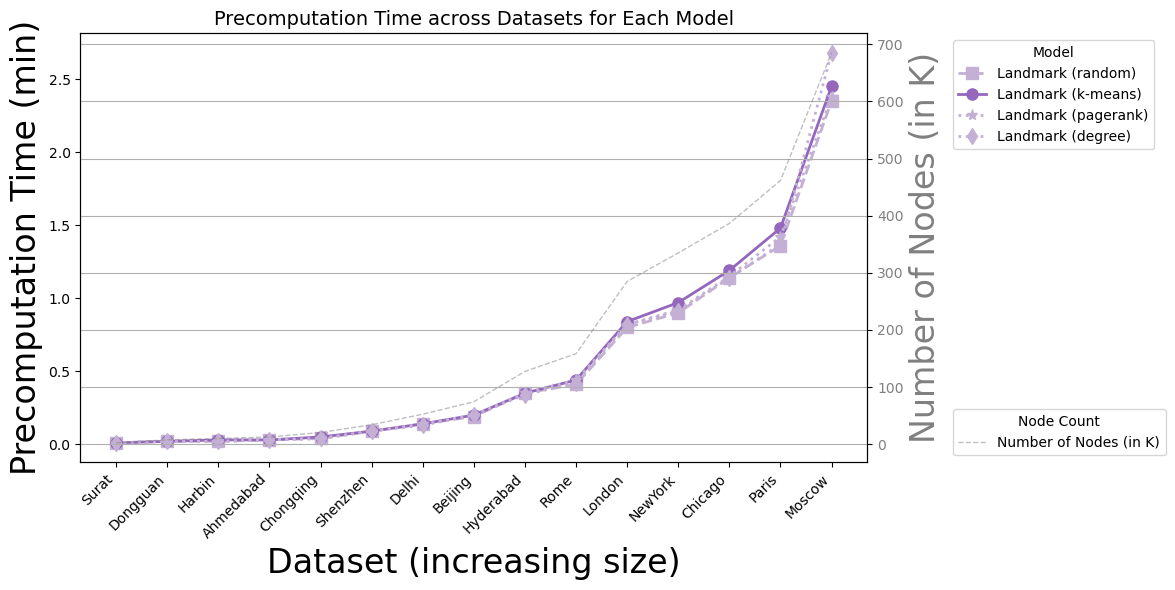

In [ ]:
# Ensure data_name order is respected and only present datasets are used
# metric = 'test_mre'
local_models = [
    # LpNorm
    "Manhattan",
    "Euclidean",

    # Landmark
    'Landmark_random',
    'Landmark_kmeans',
    'Landmark_pagerank',
    'Landmark_degree',
    'Landmark_betweenness_high',
    # 'Landmark_betweenness_low',
    # 'Landmark_closeness_high',
    # 'Landmark_closeness_low',
    # 'Landmark_eigenvector',
    # 'Landmark_katz',
    # 'Landmark_harmonic',

    # # NN
    # 'GeoDNN',
    # 'Vdist2vec',
    # 'Ndist2vec',

    # # GNN
    # 'GCN',
    # 'GCN_no_edge_weight',
    # 'SAGE',
    # 'GAT',
    # 'GAT_no_edge_weight',
]
local_datasets = [
    # ## Small (<10k nodes) ##
    'Surat',  # 2.5k
    'Quanzhou',  # 5.2k
    'Dongguan',  # 7.7k
    'Harbin',  # 10.1k
    'Fuzhou',  # 10.6k
    'Ahmedabad',  # 12.7k
    'Shenyang',  # 12.8k
    'Qingdao',  # 13.2k
    'Dhaka',  # 14.7k
    'Chongqing',  # 20.6k

    ## Medium (10k-100k nodes) ##
    'Pune',  # 27.8k
    'Shenzhen',  # 34.2k
    'Mumbai',  # 44.9k
    'Delhi',  # 52.6k
    'Jacarta',  # 73.0k
    'Beijing',  # 74.4k
    'Naples',  # 124.6k
    'Hyderabad',  # 127.5k
    'Istambul',  # 131.1k
    'Rome',  # 158.5k

    ## Large (100k-1M nodes) ##
    'Milan',  # 187.5k
    'London',  # 285.0k
    'Atlanta',  # 310.6k
    'Boston',  # 350.9k
    "NewYork",  # 190368
    "Phoenix",  # 200519
    "LosAngeles",  # 228185
    "Chicago",  # 259887
    "Paris",  # 281031
    "Moscow",  # 406505

    ## Extra Large (>1M nodes) ##
    # ...
]
metric = 'precomputation_time'
plot_metric_by_datasets(results_df, metric, local_models, local_datasets, secondary_metric='num_nodes')

In [12]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# Define available options
available_models = [
    ## LpNorm
    "Euclidean",
    "Manhattan",

    ## Landmark
    # 'Landmark_betweenness_low',
    # 'Landmark_closeness_high',
    # 'Landmark_closeness_low',
    # 'Landmark_eigenvector',
    # 'Landmark_katz',
    # 'Landmark_harmonic',
    'Landmark_betweenness_high',
    'Landmark_degree',
    'Landmark_pagerank',
    'Landmark_random',
    'Landmark_kmeans',

    # NN
    'GeoDNN',
    'Vdist2vec',
    'Ndist2vec',

    # GNN
    'GCN',
    'GCN_no_edge_weight',
    'GAT',
    'GAT_no_edge_weight',
    'SAGE',
]
baseline_models = ["Manhattan", "Euclidean"]
landmark_models = [i for i in available_models if i.startswith("Landmark")]
nn_models = ["GeoDNN", "Vdist2vec", "Ndist2vec"]
gnn_models = ["GCN", "GCN_no_edge_weight", "SAGE", "GAT", "GAT_no_edge_weight"]

available_datasets = [
    # ## Small (<10k nodes) ##
    'Surat',  # 2.5k
    'Quanzhou',  # 5.2k
    'Dongguan',  # 7.7k
    'Harbin',  # 10.1k
    'Fuzhou',  # 10.6k
    'Ahmedabad',  # 12.7k
    'Shenyang',  # 12.8k
    'Qingdao',  # 13.2k
    'Dhaka',  # 14.7k
    'Chongqing',  # 20.6k

    ## Medium (10k-100k nodes) ##
    'Pune',  # 27.8k
    'Shenzhen',  # 34.2k
    'Mumbai',  # 44.9k
    'Delhi',  # 52.6k
    'Jacarta',  # 73.0k
    'Beijing',  # 74.4k
    'Naples',  # 124.6k
    'Hyderabad',  # 127.5k
    'Istambul',  # 131.1k
    'Rome',  # 158.5k

    ## Large (100k-1M nodes) ##
    'Milan',  # 187.5k
    'London',  # 285.0k
    'Atlanta',  # 310.6k
    'Boston',  # 350.9k
    "NewYork",  # 190368
    "Phoenix",  # 200519
    "LosAngeles",  # 228185
    "Chicago",  # 259887
    "Paris",  # 281031
    "Moscow",  # 406505

    ## Extra Large (>1M nodes) ##
    # ...
]
small_datasets = ["Surat", "Quanzhou", "Dongguan", "Fuzhou", "Harbin", "Qingdao", "Dhaka", "Ahmedabad", "Shenyang"]
medium_datasets = ["Pune", "Shenzhen", "Mumbai", "Delhi", "Beijing", "Jacarta", "Naples", "Hyderabad", "Rome", "Istambul"]
large_datasets = ["Atlanta", "Milan", "London", "Boston", "NewYork", "Phoenix", "LosAngeles", "Chicago", "Paris", "Moscow"]

available_metrics = [
    "model_params",
    "train_mre",
    "test_mre",
    "precomputation_time",
    "train_query_time",
    "test_query_time",
    "model_size",
    "max_cpu_memory",
    "train_data_size",
    "test_data_size",
    "num_nodes",
    "num_edges",
]

available_secondary_metrics = [
    "num_nodes",
    "num_edges",
    "train_data_size",
    "test_data_size",
    "model_params",
    "model_size",
]

# Create checkboxes for models with a scroll bar
model_checkboxes = {model: widgets.Checkbox(value=False, description=model) for model in available_models}
model_box = widgets.VBox(
    list(model_checkboxes.values()),
    layout=widgets.Layout(max_height="200px", overflow="auto")  # Add scroll bar
)

# Create checkboxes for datasets with a scroll bar
dataset_checkboxes = {dataset: widgets.Checkbox(value=False, description=dataset) for dataset in available_datasets}
dataset_box = widgets.VBox(
    list(dataset_checkboxes.values()),
    layout=widgets.Layout(max_height="200px", overflow="auto")  # Add scroll bar
)

# Create radio buttons for metrics
metric_selector = widgets.RadioButtons(
    options=available_metrics,
    value="test_mre",
    description="Metric",
    layout=widgets.Layout()
)

# Create dropdown for secondary metrics
secondary_metric_selector = widgets.Dropdown(
    options=[("None", None)] + [(m, m) for m in available_secondary_metrics],
    value=None,
    description="Secondary Metric",
    layout=widgets.Layout()
)

# Button to trigger the plot
plot_button = widgets.Button(
    description="Plot",
    button_style="success",
)

# Output widget to display the plot
output = widgets.Output()

# Function to update the plot
def update_plot(change):
    with output:
        output.clear_output()  # Clear previous output

        # Get selected models
        selected_models = [model for model, cb in model_checkboxes.items() if cb.value]

        # Get selected datasets
        selected_datasets = [dataset for dataset, cb in dataset_checkboxes.items() if cb.value]

        # Get selected metric
        selected_metric = metric_selector.value

        # Get selected secondary metric
        selected_secondary_metric = secondary_metric_selector.value

        # Call the plotting function
        plot_metric_by_datasets(results_df, selected_metric, selected_models, selected_datasets, selected_secondary_metric)

# Attach the function to the button
plot_button.on_click(update_plot)

# Selection functions with toggle behavior
def toggle_models(models):
    """
    Toggles the selection of models. If all models are selected, unselect them.
    Otherwise, select all models.
    """
    all_selected = all(model_checkboxes[model].value for model in models if model in model_checkboxes)
    for model in models:
        if model in model_checkboxes:
            model_checkboxes[model].value = not all_selected

def toggle_datasets(datasets):
    """
    Toggles the selection of datasets. If all datasets are selected, unselect them.
    Otherwise, select all datasets.
    """
    all_selected = all(dataset_checkboxes[dataset].value for dataset in datasets if dataset in dataset_checkboxes)
    for dataset in datasets:
        if dataset in dataset_checkboxes:
            dataset_checkboxes[dataset].value = not all_selected

def clear_models(change):
    for cb in model_checkboxes.values():
        cb.value = False

def clear_datasets(change):
    for cb in dataset_checkboxes.values():
        cb.value = False

# Buttons for model selection
baseline_button = widgets.Button(description="Baselines")
baseline_button.on_click(lambda change: toggle_models(["Manhattan", "Euclidean"]))

landmark_button = widgets.Button(description="Landmark")
landmark_button.on_click(lambda change: toggle_models(landmark_models))

nn_button = widgets.Button(description="NN")
nn_button.on_click(lambda change: toggle_models(nn_models))

gnn_button = widgets.Button(description="GNN")
gnn_button.on_click(lambda change: toggle_models(gnn_models))

# Buttons for dataset selection
small_button = widgets.Button(description="Small")
small_button.on_click(lambda change: toggle_datasets(small_datasets))

medium_button = widgets.Button(description="Medium")
medium_button.on_click(lambda change: toggle_datasets(medium_datasets))

large_button = widgets.Button(description="Large")
large_button.on_click(lambda change: toggle_datasets(large_datasets))

# Clear buttons
clear_models_button = widgets.Button(description="Clear Models", button_style="danger")
clear_models_button.on_click(clear_models)

clear_datasets_button = widgets.Button(description="Clear Datasets", button_style="danger")
clear_datasets_button.on_click(clear_datasets)

# Clear all function
def clear_all(change):
    """
    Clears all selected models and datasets.
    """
    for cb in model_checkboxes.values():
        cb.value = False
    for cb in dataset_checkboxes.values():
        cb.value = False

# Clear All button
clear_all_button = widgets.Button(description="Clear All", button_style="danger")
clear_all_button.on_click(clear_all)

# Arrange widgets
model_buttons = widgets.VBox([clear_models_button, baseline_button, landmark_button, nn_button, gnn_button])
dataset_buttons = widgets.VBox([clear_datasets_button, small_button, medium_button, large_button])
clear_buttons = widgets.VBox([clear_all_button])

# Combine checkboxes and buttons
model_section = widgets.VBox([model_box, model_buttons])
dataset_section = widgets.VBox([dataset_box, dataset_buttons])
metric_section = widgets.VBox([metric_selector, clear_buttons, plot_button])

# Final layout
layout = widgets.VBox([
    widgets.HBox([model_section, dataset_section, metric_section, secondary_metric_selector]),
    output
])

# Display the UI and output
display(layout)

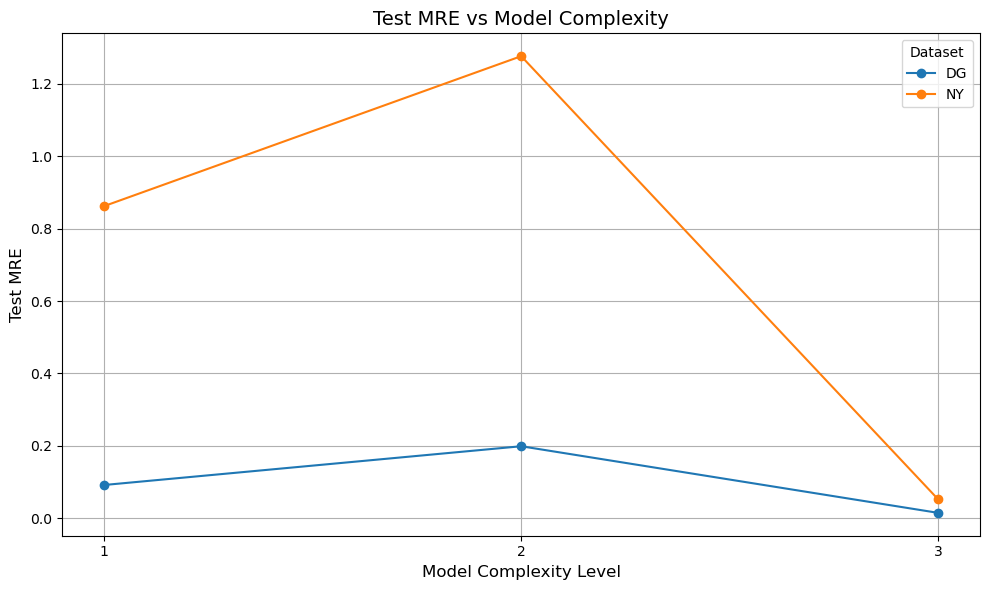

In [10]:
# import pandas as pd
# import matplotlib.pyplot as plt

def plot_mre_vs_model_complexity(df, complexity_col, mre_col, dataset_col, model_col=None):
    """
    Plot Test MRE vs Model Complexity for multiple datasets.

    Parameters:
        dataframe (pd.DataFrame): The input data containing model results.
        complexity_col (str): Column name for model complexity level.
        mre_col (str): Column name for test MRE.
        dataset_col (str): Column name for dataset identifier.
        model_col (str, optional): Column name for model names (for hover or labeling).
    """
    plt.figure(figsize=(10, 6))

    # Add


    # Iterate over each dataset and plot its line
    for dataset in df[dataset_col].unique():
        subset = df[df[dataset_col] == dataset]
        plt.plot(
            subset[complexity_col],
            subset[mre_col],
            marker='o',
            label=dataset
        )

    plt.title("Test MRE vs Model Complexity", fontsize=14)
    plt.xlabel("Model Complexity Level", fontsize=12)
    plt.ylabel("Test MRE", fontsize=12)
    plt.legend(title="Dataset")
    plt.grid(True)
    plt.xticks(sorted(df[complexity_col].unique()))
    plt.tight_layout()
    plt.show()

test_data = {
    "Dataset": ["DG", "DG", "DG", "NY", "NY", "NY"],
    "Model": ["Geodnn", "Node2vec", "Vdist2vec", "Geodnn", "Node2vec", "Vdist2vec"],
    "Model_Complexity_Level": [1, 2, 3, 1, 2, 3],
    "Test_MRE": [0.092, 0.199, 0.015, 0.862, 1.276, 0.052]
}
test_df = pd.DataFrame(test_data)

plot_mre_vs_model_complexity(test_df,
                              complexity_col="Model_Complexity_Level",
                              mre_col="Test_MRE",
                              dataset_col="Dataset",
                              model_col="Model")


In [98]:
duplicates = results_df[results_df.duplicated(subset=['model_name', 'data_name'], keep=False)]
if not duplicates.empty:
    print("Duplicate entries found:")
    print(duplicates)

Duplicate entries found:
        model_name data_name  num_nodes  model_params  train_mre  test_mre  \
143  Landmark_katz       NaN        NaN           NaN        NaN       NaN   
160  Landmark_katz       NaN        NaN           NaN        NaN       NaN   

     precomputation_time  train_query_time  test_query_time  model_size  \
143                  NaN               NaN              NaN         NaN   
160                  NaN               NaN              NaN         NaN   

     max_cpu_memory  
143          111.22  
160          111.17  


In [76]:
results_df.groupby(['model_name', 'data_name']).count().reset_index().sum()

model_name             EuclideanEuclideanEuclideanEuclideanEuclideanE...
data_name              BeijingDelhiHyderabadIstambulJacartaMumbaiNapl...
num_nodes                                                            168
model_params                                                         168
train_mre                                                            164
test_mre                                                             164
precomputation_time                                                  164
train_query_time                                                     164
test_query_time                                                      164
model_size                                                           164
max_cpu_memory                                                       168
dtype: object

In [60]:
df.groupby(['model_name', 'data_name']).head()

python_command  \
0    python model-lpnorm.py --p_norm 1 --data_name ...   
1    python model-lpnorm.py --p_norm 2 --data_name ...   
2    python model-landmark.py --model_strategy rand...   
3    python model-landmark.py --model_strategy betw...   
4    python model-landmark.py --model_strategy betw...   
..                                                 ...   
165  python model-rgnndist2vec.py --gnn_layer_type ...   
166  python model-rgnndist2vec.py --gnn_layer_type ...   
167  python model-rgnndist2vec.py --gnn_layer_type ...   
168  python model-rgnndist2vec.py --gnn_layer_type ...   
169  python model-rgnndist2vec.py --gnn_layer_type ...   

                                            log_output  \
0    ../results/logs/expt16-train-medium-v1-landmar...   
1    ../results/logs/expt16-train-medium-v1-landmar...   
2    ../results/logs/expt16-train-medium-v1-landmar...   
3    ../results/logs/expt16-train-medium-v1-landmar...   
4    ../results/logs/expt16-train-medium-v1-landmar...   
..                                                 ...   
165  ../results/logs/expt16-train-medium-v1-landmar...   
166  ../results/logs/expt16-train-medium-v1-landmar...   
167  ../results/logs/expt16-train-medium-v1-landmar...   
168  ../results/logs/expt16-train-medium-v1-landmar...   
169  ../results/logs/expt16-train-medium-v1-landmar...   

                           expt_name                 model_name   model_class  \
0    expt16-train-medium-v1-landmark                  Manhattan        LpNorm   
1    expt16-train-medium-v1-landmark                  Euclidean        LpNorm   
2    expt16-train-medium-v1-landmark            Landmark_random      Landmark   
3    expt16-train-medium-v1-landmark  Landmark_betweenness_high      Landmark   
4    expt16-train-medium-v1-landmark   Landmark_betweenness_low      Landmark   
..                               ...                        ...           ...   
165  expt16-train-medium-v1-landmark                        GCN  RGNNdist2vec   
166  expt16-train-medium-v1-landmark         GCN_no_edge_weight  RGNNdist2vec   
167  expt16-train-medium-v1-landmark                       SAGE  RGNNdist2vec   
168  expt16-train-medium-v1-landmark                        GAT  RGNNdist2vec   
169  expt16-train-medium-v1-landmark         GAT_no_edge_weight  RGNNdist2vec   

    data_name data_strategy data_version  seed  num_nodes  num_edges  \
0        Pune      landmark  v1-landmark  42.0    14542.0    22662.0   
1        Pune      landmark  v1-landmark  42.0    14542.0    22662.0   
2        Pune      landmark  v1-landmark  42.0    14542.0    22662.0   
3        Pune      landmark  v1-landmark  42.0    14542.0    22662.0   
4        Pune      landmark  v1-landmark  42.0    14542.0    22662.0   
..        ...           ...          ...   ...        ...        ...   
165  Istambul      landmark  v1-landmark  42.0    98573.0   156377.0   
166  Istambul      landmark  v1-landmark  42.0    98573.0   156377.0   
167  Istambul      landmark  v1-landmark  42.0    98573.0   156377.0   
168  Istambul      landmark  v1-landmark  42.0    98573.0   156377.0   
169  Istambul      landmark  v1-landmark  42.0    98573.0   156377.0   

     train_data_size  train_data_distance_mean  test_data_size  \
0          1454100.0                  19314.73       1454100.0   
1          1454100.0                  19314.73       1454100.0   
2          1454100.0                  19314.73       1454100.0   
3          1454100.0                  19314.73       1454100.0   
4          1454100.0                  19314.73       1454100.0   
..               ...                       ...             ...   
165        9857200.0                  40678.45       9857200.0   
166        9857200.0                  40678.45       9857200.0   
167        9857200.0                  40678.45       9857200.0   
168        9857200.0                  40678.45       9857200.0   
169        9857200.0                  40678.45       9857200.0   

     test_data_

In [103]:
cols = [
    'model_params',
    'precomputation_time',
    'train_mre',
    'test_mre',
    'train_query_time',
    'test_query_time',
    'model_size',
    'max_cpu_memory',
]

for col in cols:
    print(f"======== {col} ========")
    pivot_table = pivot_by(results_df, col)
    print(pivot_table.shape)
    print(pivot_table.to_markdown())

# pivot_table = results_df.pivot(
#     index='model_variant',
#     columns='data_name',
#     values='model_params'
# )
# print(pivot_table.shape)
# print(pivot_table.to_markdown(index=True))

======== model_params ========
(15, 10)
| model_name                |    Pune |   Shenzhen |   Mumbai |   Delhi |   Beijing |   Jacarta |   Naples |   Hyderabad |    Rome |   Istambul |
|:--------------------------|--------:|-----------:|---------:|--------:|----------:|----------:|---------:|------------:|--------:|-----------:|
| Manhattan                 |    0    |       0    |     0    |    0    |      0    |      0    |     0    |        0    |    0    |       0    |
| Euclidean                 |    0    |       0    |     0    |    0    |      0    |      0    |     0    |        0    |    0    |       0    |
| Landmark_random           |    0    |       0    |     0    |    0    |      0    |      0    |     0    |        0    |    0    |       0    |
| Landmark_betweenness_high |    0    |       0    |     0    |    0    |      0    |      0    |     0    |        0    |    0    |       0    |
| Landmark_betweenness_low  |    0    |       0    |     0    |    0    |      0    

In [105]:
def plot_mre_side_by_side(pivot_table_train, pivot_table_test, title="Train vs Test MRE"):
    """
    Plots train_mre and test_mre side by side for each dataset column and for every model.

    Args:
        pivot_table_train (pd.DataFrame): Pivot table for train_mre.
        pivot_table_test (pd.DataFrame): Pivot table for test_mre.
        title (str): Title of the plot.
    """
    # Ensure the train and test pivot tables have the same structure
    assert pivot_table_train.shape == pivot_table_test.shape, "Train and Test pivot tables must have the same shape"
    assert (pivot_table_train.columns == pivot_table_test.columns).all(), "Columns must match"
    assert (pivot_table_train.index == pivot_table_test.index).all(), "Index must match"

    # Get dataset names (columns) and model names (index)
    datasets = pivot_table_train.columns
    models = pivot_table_train.index

    # Number of datasets and models
    num_datasets = len(datasets)
    num_models = len(models)

    # Bar width and positions
    bar_width = 0.35
    x = np.arange(num_datasets)  # Positions for datasets

    # Create subplots for each model
    fig, axes = plt.subplots(num_models, 1, figsize=(12, 4 * num_models), sharex=False)

    if num_models == 1:
        axes = [axes]  # Ensure axes is iterable for a single model

    for i, model in enumerate(models):
        ax = axes[i]

        # Train and Test MRE values for the current model
        train_values = pivot_table_train.loc[model].values
        test_values = pivot_table_test.loc[model].values

        # Plot bars
        ax.bar(x - bar_width / 2, train_values, bar_width, label="Train MRE", color="blue", alpha=0.7)
        ax.bar(x + bar_width / 2, test_values, bar_width, label="Test MRE", color="orange", alpha=0.7)

        # Add labels and title
        ax.set_title(f"{model} - {title}")
        ax.set_ylabel("MRE (%)")
        ax.set_xticks(x)
        ax.set_xticklabels(datasets, rotation=0, ha="right")
        ax.legend()

    # Add shared x-axis label
    plt.xlabel("Datasets")
    plt.tight_layout()
    plt.show()

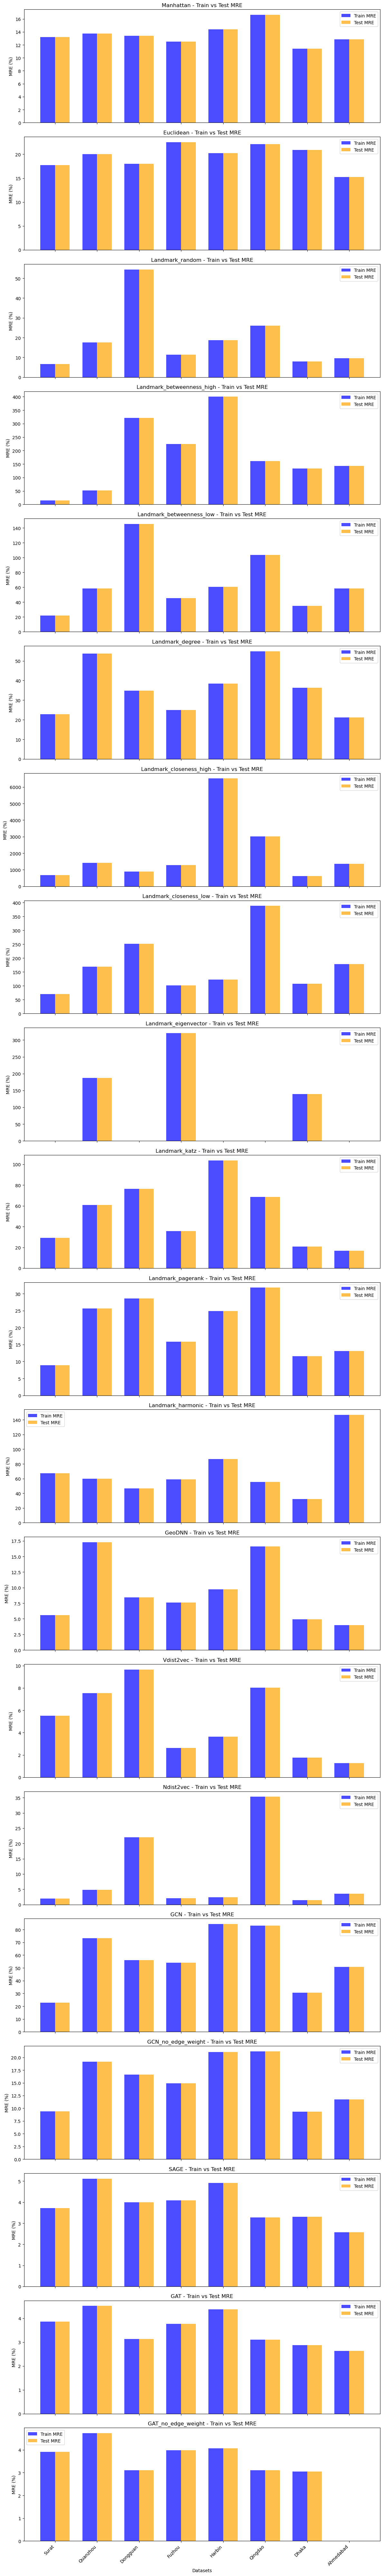

In [30]:
# Pivot the DataFrame for train_mre and test_mre
pivot_table_train_mre = pivot_by(results_df, "train_mre")
pivot_table_test_mre = pivot_by(results_df, "test_mre")

# Plot train_mre and test_mre side by side
plot_mre_side_by_side(pivot_table_train_mre, pivot_table_test_mre, title="Train vs Test MRE")

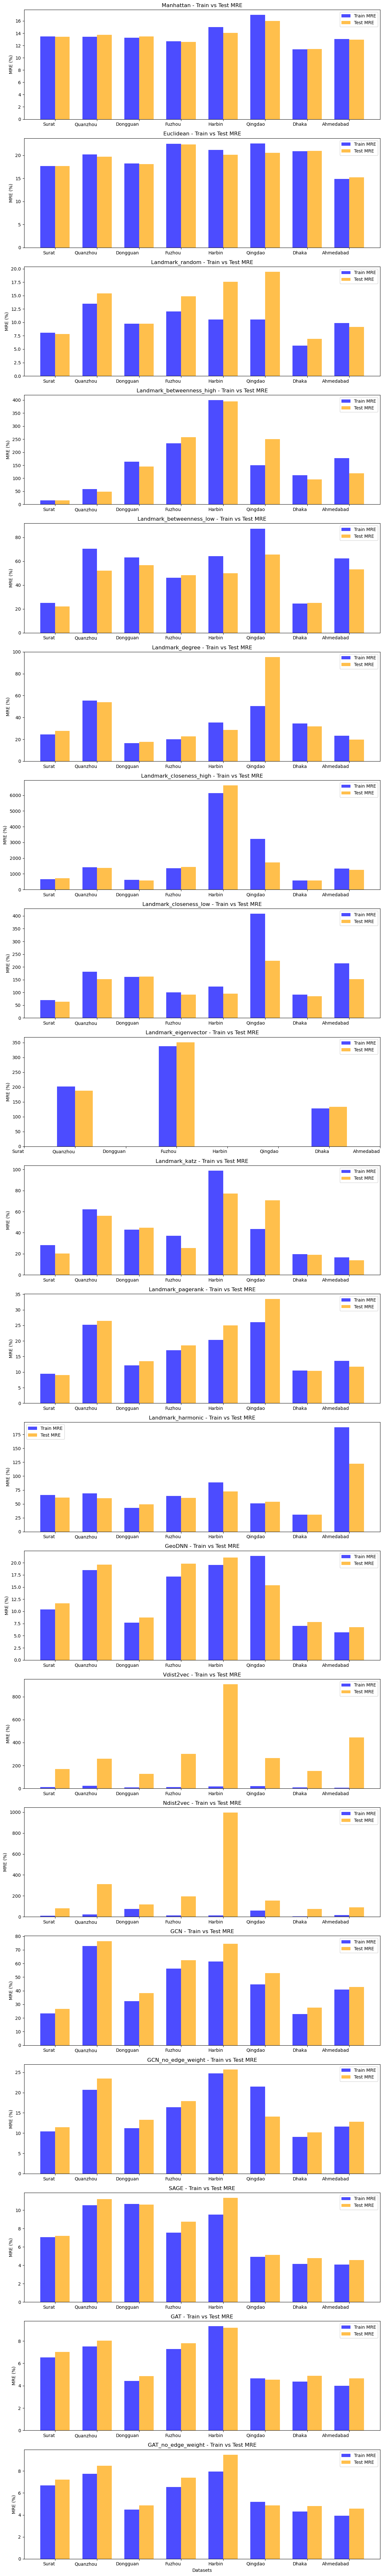

In [ ]:
# Pivot the DataFrame for train_mre and test_mre
pivot_table_train_mre = pivot_by(results_df, "train_mre")
pivot_table_test_mre = pivot_by(results_df, "test_mre")

# Plot train_mre and test_mre side by side
plot_mre_side_by_side(pivot_table_train_mre, pivot_table_test_mre, title="Train vs Test MRE")

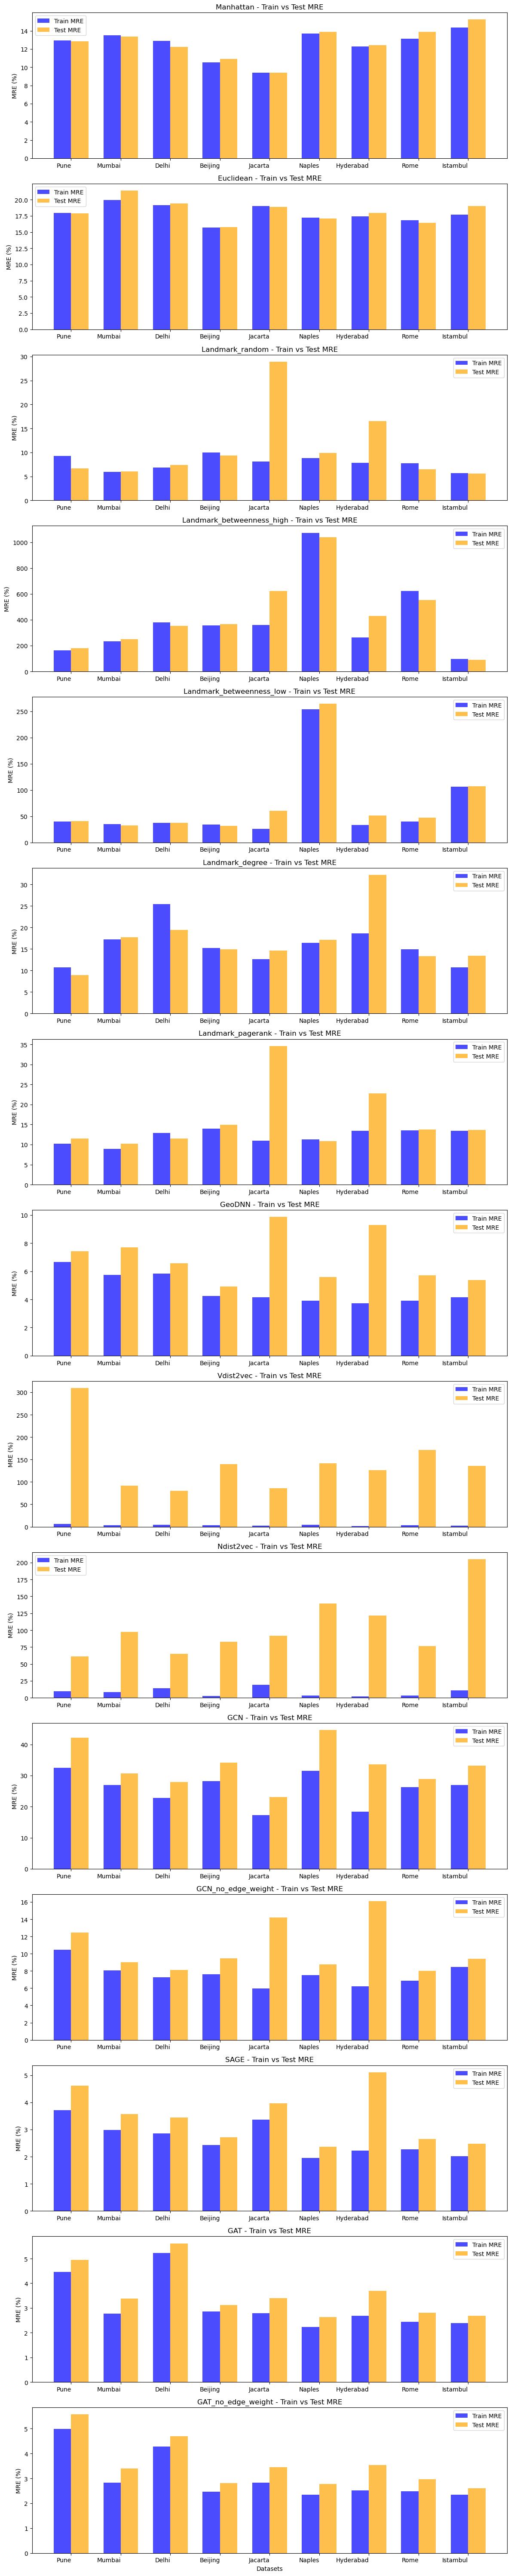

In [108]:
# Pivot the DataFrame for train_mre and test_mre
pivot_table_train_mre = pivot_by(results_df, "train_mre")
pivot_table_test_mre = pivot_by(results_df, "test_mre")

# Plot train_mre and test_mre side by side
plot_mre_side_by_side(pivot_table_train_mre, pivot_table_test_mre, title="Train vs Test MRE")

In [ ]:
cols = [
    'model_params',
    'precomputation_time',
    'train_mre',
    'test_mre',
    'train_query_time',
    'test_query_time',
    'model_size',
    'max_cpu_memory',
]

for col in cols:
    print(f"======== {col} ========")
    pivot_table = pivot_by(results_df, col)
    print(pivot_table.shape)
    print(pivot_table.to_markdown())

# pivot_table = results_df.pivot(
#     index='model_variant',
#     columns='data_name',
#     values='model_params'
# )
# print(pivot_table.shape)
# print(pivot_table.to_markdown(index=True))

======== model_params ========
(18, 10)
| model_variant             |   Surat |   Quanzhou |   Dongguan |   Fuzhou |   Harbin |   Qingdao |   Dhaka |   Ahmedabad |   Shenyang |   Chongqing |
|:--------------------------|--------:|-----------:|-----------:|---------:|---------:|----------:|--------:|------------:|-----------:|------------:|
| Landmark_random           |    0    |       0    |       0    |     0    |     0    |      0    |    0    |        0    |       0    |        0    |
| Landmark_betweenness_high |    0    |       0    |       0    |     0    |     0    |      0    |    0    |        0    |       0    |        0    |
| Landmark_betweenness_low  |    0    |       0    |       0    |     0    |     0    |      0    |    0    |        0    |       0    |        0    |
| Landmark_degree           |    0    |       0    |       0    |     0    |     0    |      0    |    0    |        0    |       0    |        0    |
| Landmark_closeness_high   |    0    |       0    |  

In [156]:
cols = [
    'model_params',
    'mre',
    'precomputation_time',
    'query_time',
    'max_cpu_memory',
]

for col in cols:
    print(f"======== {col} ========")
    pivot_table = pivot_by(results_df, col)
    print(pivot_table.shape)
    print(pivot_table.to_markdown())

======== model_params ========
(10, 10)
| model_variant             |    Pune |   Shenzhen |   Mumbai |   Delhi |   Beijing |   Jacarta |   Naples |   Hyderabad |    Rome |   Istambul |
|:--------------------------|--------:|-----------:|---------:|--------:|----------:|----------:|---------:|------------:|--------:|-----------:|
| Landmark_random           |    0    |       0    |     0    |    0    |      0    |      0    |     0    |        0    |    0    |       0    |
| Landmark_betweenness_high |    0    |       0    |     0    |    0    |      0    |      0    |     0    |        0    |    0    |       0    |
| Landmark_betweenness_low  |    0    |       0    |     0    |    0    |      0    |      0    |     0    |        0    |    0    |       0    |
| Landmark_degree           |    0    |       0    |     0    |    0    |      0    |      0    |     0    |        0    |    0    |       0    |
| Landmark_pagerank         |    0    |       0    |     0    |    0    |      0    

In [142]:
# Pivot by 'model_params'
pivot_table = pivot_by(results_df, 'model_params')
print(pivot_table.shape)
print(pivot_table.to_markdown())

(18, 10)
| model_variant             |   Surat |   Quanzhou |   Dongguan |   Fuzhou |   Harbin |   Qingdao |   Dhaka |   Ahmedabad |   Shenyang |   Chongqing |
|:--------------------------|--------:|-----------:|-----------:|---------:|---------:|----------:|--------:|------------:|-----------:|------------:|
| Landmark_random           |    0    |       0    |       0    |     0    |     0    |      0    |    0    |        0    |       0    |        0    |
| Landmark_betweenness_high |    0    |       0    |       0    |     0    |     0    |      0    |    0    |        0    |       0    |        0    |
| Landmark_betweenness_low  |    0    |       0    |       0    |     0    |     0    |      0    |    0    |        0    |       0    |        0    |
| Landmark_degree           |    0    |       0    |       0    |     0    |     0    |      0    |    0    |        0    |       0    |        0    |
| Landmark_closeness_high   |    0    |       0    |       0    |     0    |     0   

In [7]:
## Example output:
# Running command: python model-geodnn.py --data_name Surat
# /scratch/gilbreth/gchoudha/shortest-distance/src/data_utils.py:266: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
#   dataset = torch.load(file_name)
# Arguments:
#   - data_name: Surat
#   - data_strategy: landmark
#   - batch_size: 1024
#   - learning_rate: 0.001

results = []

for file_name in FILE_NAMES[:10]:
    result = parse_file(file_name)
    results.append(result)

# Convert the list of dictionaries into a DataFrame
df = pd.DataFrame(results)

../results/logs/expt12-train-small/train_GCN_Shenyang.log
model_name: RGCNdist2vec
data_name: Shenyang
data_strategy: landmark
seed: 42
num_nodes: 9020
num_edges: 15066
data_size: 901900
data_distance_mean: 25967.62
model_params: 17952
loss_function: SmoothL1Loss()
optimizer: Adam
gpu_name: NVIDIA A30
device: cuda
mae: 1247.99
mre: 12.12%
precomputation_time: 1.15 minutes
evaluation_time: 2.81 seconds
query_time: 3.12 microseconds
../results/logs/expt12-train-small/train_GAT_Ahmedabad.log
model_name: RGATdist2vec
data_name: Ahmedabad
data_strategy: landmark
seed: 42
num_nodes: 8808
num_edges: 14178
data_size: 880700
data_distance_mean: 16004.74
model_params: 19040
loss_function: SmoothL1Loss()
optimizer: Adam
gpu_name: NVIDIA A30
device: cuda
mae: 312.52
mre: 3.92%
precomputation_time: 1.75 minutes
evaluation_time: 3.06 seconds
query_time: 3.47 microseconds
../results/logs/expt12-train-small/train_Landmark_random_Ahmedabad.log
model_name: Landmark
data_name: Ahmedabad
data_strategy: la

In [8]:
df.head()

data_name     model_name data_strategy  seed  data_size  \
0   Shenyang   RGCNdist2vec      landmark    42     901900   
1  Ahmedabad   RGATdist2vec      landmark    42     880700   
2  Ahmedabad       Landmark      landmark    42     880700   
3     Fuzhou   RGCNdist2vec      landmark    42     595400   
4    Qingdao  RSAGEdist2vec      landmark    42     799100   

   data_distance_mean  num_nodes  num_edges  model_params      mae     mre  \
0            25967.62       9020      15066         17952  1247.99  12.12%   
1            16004.74       8808      14178         19040   312.52   3.92%   
2            16004.74       8808      14178             0   126.00   8.41%   
3            37653.52       5955       9693         17952  1806.14  12.95%   
4            48739.17       7992      13275         35360   933.54   4.18%   

    loss_function optimizer    gpu_name device precomputation_time  \
0  SmoothL1Loss()      Adam  NVIDIA A30   cuda        1.15 minutes   
1  SmoothL1Loss()      Adam  NVIDIA A30   cuda        1.75 minutes   
2            None      None  NVIDIA A30   cuda        0.05 minutes   
3  SmoothL1Loss()      Adam  NVIDIA A30   cuda        0.79 minutes   
4  SmoothL1Loss()      Adam  NVIDIA A30   cuda        1.06 minutes   

  evaluation_time         query_time  
0    2.81 seconds  3.12 microseconds  
1    3.06 seconds  3.47 microseconds  
2    2.07 seconds  2.35 microseconds  
3    1.79 seconds  3.00 microseconds  
4    2.71 seconds  3.39 microseconds

In [126]:
# 12345
df['model_params'] = df['model_params'].astype(int)/1000
# 2.83%
df['mre'] = df['mre'].str.extract(r'(\d+\.\d+)').astype(float)
# (25.60 minutes)
df['precomputation_time'] = df['precomputation_time'].str.extract(r'(\d+\.\d+)').astype(float)
# (58.13 seconds)
df['evaluation_time'] = df['evaluation_time'].str.extract(r'(\d+\.\d+)').astype(float)
# 3.09 microseconds
df['query_time'] = df['query_time'].str.extract(r'(\d+\.\d+)').astype(float)
# 208403 KB
df['memory_used'] = df['memory_used'].str.extract(r'(\d+)').astype(float) / 1024 / 1024
# 27:29.79 sec
df['time_elapsed'] = df['time_elapsed'].str.extract(r'(\d+):\d+\.\d+').astype(int)
df.head()

job_id                                     python_command  data_name  \
0  8346247    python model-vdist2vec.py --data_name Ahmedabad  Ahmedabad   
1  8346186     python model-vdist2vec.py --data_name Dongguan   Dongguan   
2  8346252       python model-geodnn.py --data_name Ahmedabad  Ahmedabad   
3  8346182     python model-rgcndist2vec.py --data_name Surat      Surat   
4  8346279  python model-rgcndist2vec.py --data_name Ahmed...  Ahmedabad   

     model_name data_strategy data_size data_distance_mean num_nodes  \
0     Vdist2vec      landmark  18837405           16992.86      9706   
1     Vdist2vec      landmark   4942168           34620.16      4973   
2        GeoDNN      landmark  18837405           16992.86      9706   
3  RGCNdist2vec      landmark    780520            8036.82      1977   
4  RGCNdist2vec      landmark  18837405           16992.86      9706   

  num_edges  model_params     mae    mre   loss_function    gpu_name device  \
0     15040      1923.905   92.51   2.83       MSELoss()  NVIDIA A30   cuda   
1      7825       514.268  299.44   5.06       MSELoss()  NVIDIA A30   cuda   
2     15040         4.241  302.64   5.26       MSELoss()  NVIDIA A30   cuda   
3      3054        17.952  380.30   9.95  SmoothL1Loss()  NVIDIA A30   cuda   
4     15040        17.952  647.80  11.16  SmoothL1Loss()  NVIDIA A30   cuda   

   precomputation_time  evaluation_time  query_time  memory_used  time_elapsed  
0                25.60            58.13        3.09     4.704910            27  
1                 4.85            11.89        2.41     2.000366             5  
2                19.63            47.08        2.50     4.677982            21  
3                 1.30             2.64        3.38     1.317200             1  
4                25.51            54.95        2.92     4.851418            27

In [127]:
# Define order for models and datasets
model_name_order = [
    'GeoDNN',
    'Vdist2vec',
    'Ndist2vec',
    'RGCNdist2vec',
    'RSAGEdist2vec',
    'RGATdist2vec'
]
data_name_order = [
    'Surat',
    'Dongguan',
    'Harbin',
    'Ahmedabad'
]
swap_levels = False

In [130]:
df[['data_name', 'num_nodes', 'num_edges', 'data_size', 'data_distance_mean']].drop_duplicates().T

0         1        3         5
data_name           Ahmedabad  Dongguan    Surat    Harbin
num_nodes                9706      4973     1977      6772
num_edges               15040      7825     3054     10776
data_size            18837405   4942168   780520   9167934
data_distance_mean   16992.86  34620.16  8036.82  62726.45

In [ ]:
# Pivot the DataFrame
values_order = ['model_params']
pivot_table = df.pivot(
    index='model_name',
    columns='data_name',
    values=values_order
)
if swap_levels:
    # Swap the levels of the columns
    pivot_table = pivot_table.swaplevel(0, 1, axis='columns')
    # cross-product the values with the data names
    column_order = [(data_name, value) for value in values_order for data_name in data_name_order]
else:
    # cross-product the values with the data names
    column_order = [(value, data_name) for data_name in data_name_order for value in values_order]
pivot_table.loc[model_name_order, column_order].round(2)

model_params                           
data_name            Surat Dongguan  Harbin Ahmedabad
model_name                                           
GeoDNN                4.24     4.24    4.24      4.24
Vdist2vec            87.04   514.27  943.36   1923.90
Ndist2vec           147.42   297.22  387.17    533.87
RGCNdist2vec         17.95    17.95   17.95     17.95
RSAGEdist2vec        35.36    35.36   35.36     35.36
RGATdist2vec         19.04    19.04   19.04     19.04

In [ ]:
# Pivot the DataFrame
values_order = ['mae', 'mre']
pivot_table = df.pivot(
    index='model_name',
    columns='data_name',
    values=values_order
)
# cross-product the values with the data names
column_order = [(value, data_name) for value in values_order for data_name in data_name_order]
pivot_table.loc[model_name_order, column_order].round(2)

mae                                mre                  \
data_name       Surat  Dongguan   Harbin Ahmedabad Surat Dongguan Harbin   
model_name                                                                 
GeoDNN         241.61    790.70  2049.31    302.64  7.06     6.16  11.92   
Vdist2vec      129.36    299.44   403.68     92.51   5.5     5.06   6.48   
Ndist2vec       93.04  11758.27  7466.18    698.68   4.0    60.96   9.53   
RGCNdist2vec   380.30   1246.89  2472.39    647.80  9.95    10.98  20.89   
RSAGEdist2vec  213.36    526.32   849.73    189.24  4.57      3.6   5.71   
RGATdist2vec   225.25    657.82   825.84    214.25   4.6     3.55    4.7   

                         
data_name     Ahmedabad  
model_name               
GeoDNN             5.26  
Vdist2vec          2.83  
Ndist2vec          2.47  
RGCNdist2vec      11.16  
RSAGEdist2vec      2.78  
RGATdist2vec       2.84

In [ ]:
# Pivot the DataFrame
values_order = ['precomputation_time', 'query_time']
pivot_table = df.pivot(
    index='model_name',
    columns='data_name',
    values=values_order
)
# cross-product the values with the data names
column_order = [(value, data_name) for value in values_order for data_name in data_name_order]
pivot_table.loc[model_name_order, column_order].round(2)

precomputation_time                           query_time  \
data_name                   Surat Dongguan Harbin Ahmedabad      Surat   
model_name                                                               
GeoDNN                       1.05     6.71   9.74     19.63       3.11   
Vdist2vec                    0.77     4.85   9.55     25.60       2.37   
Ndist2vec                    1.31     8.91  22.47     33.69       2.73   
RGCNdist2vec                 1.30     8.43  12.33     25.51       3.38   
RSAGEdist2vec                1.03     6.95  11.57     27.83       2.77   
RGATdist2vec                 1.93    14.54  18.16     38.21       4.21   

                                         
data_name     Dongguan Harbin Ahmedabad  
model_name                               
GeoDNN            2.85   2.45      2.50  
Vdist2vec         2.41   2.36      3.09  
Ndist2vec         2.76   3.50      2.86  
RGCNdist2vec      3.44   2.94      2.92  
RSAGEdist2vec     3.00   2.90      2.93  
RGATdist2vec      4.55   3.48      3.49

In [ ]:
# Pivot the DataFrame
values_order = ['memory_used', 'time_elapsed']
pivot_table = df.pivot(
    index='model_name',
    columns='data_name',
    values=values_order
)
# cross-product the values with the data names
column_order = [(value, data_name) for value in values_order for data_name in data_name_order]
pivot_table.loc[model_name_order, column_order].round(2)

memory_used                           time_elapsed           \
data_name           Surat Dongguan Harbin Ahmedabad        Surat Dongguan   
model_name                                                                  
GeoDNN               1.16     1.99   2.80      4.68          1.0      7.0   
Vdist2vec            1.17     2.00   2.81      4.70          0.0      5.0   
Ndist2vec            1.19     2.04   2.84      4.73          1.0      9.0   
RGCNdist2vec         1.32     2.15   2.96      4.85          1.0      9.0   
RSAGEdist2vec        1.31     2.14   2.95      4.85          1.0      7.0   
RGATdist2vec         1.33     2.16   2.97      4.85          2.0     15.0   

                                
data_name     Harbin Ahmedabad  
model_name                      
GeoDNN          10.0      21.0  
Vdist2vec       10.0      27.0  
Ndist2vec       23.0      35.0  
RGCNdist2vec    13.0      27.0  
RSAGEdist2vec   12.0      29.0  
RGATdist2vec    19.0      40.0

## Dataset Summary

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

datasets = pd.read_csv("../data/processed/full_dataset_summary.csv")
datasets.head(30)

Dataset Name  Nodes  Edges  Min Degree  Max Degree  Avg Degree  \
0         Surat   1843   2926           2           6    3.175258   
1      Quanzhou   3079   5150           2           6    3.345242   
2      Dongguan   4606   7490           2           7    3.252280   
3     Zhengzhou   5530   9223           2           8    3.335624   
4        Fuzhou   5955   9693           2           8    3.255416   
5        Harbin   6328  10381           2           7    3.280973   
6        Dalian   7455  12077           2           7    3.239973   
7       Qingdao   7992  13275           2           8    3.322072   
8         Dhaka   8349  13117           2          12    3.142173   
9     Ahmedabad   8808  14178           2           6    3.219346   
10     Shenyang   9020  15066           2          14    3.340576   
11    Chongqing   9519  15179           2           6    3.189201   
12     Bangdung  10905  16792           2           6    3.079688   
13      Chengdu  11327  19055           2          11    3.364527   
14     Hangzhou  11419  19115           2           8    3.347929   
15      Nanjing  12756  21133           2           9    3.313421   
16        Wuhan  13840  22315           2           9    3.224711   
17         Pune  14542  22662           2           6    3.116765   
18     Medellin  15108  24744           2           6    3.275616   
19     Xianyang  15926  26044           2           7    3.270627   
20      Tianjin  17494  28999           2           7    3.315308   
21     Salvador  18822  29112           2           6    3.093401   
22      Abidjan  21529  34458           2           7    3.201078   
23     Shenzhen  21809  35372           2          11    3.243798   
24       Lahore  22170  35397           2          10    3.193234   
25     Surabaya  22283  34469           2           8    3.093749   
26       Recife  23093  37023           2           8    3.206426   
27       Suzhou  23502  39251           2          11    3.340226   
28       Mumbai  25668  40374           2          10    3.145863   
29    Guangzhou  28707  46238           2           8    3.221375   

    BFS Time (s)  Min Distance (m)  Max Distance (m)  Avg Distance (m)  
0       0.000024                 0      36081.453724       7461.030287  
1       0.000002                 0     196633.280532      34451.294986  
2       0.000005                 0      89695.522636      34169.412945  
3       0.000008                 0     145025.634691      33597.673231  
4       0.000002                 0     184879.842392      36192.721536  
5       0.000001                 0     459221.047861      55336.925324  
6       0.000002                 0     258726.053987      64536.694822  
7       0.000002                 0     200357.662194      52932.755488  
8       0.000001                 0      57670.940506      10424.881985  
9       0.000002                 0     105002.158357      16149.780590  
10      0.000003                 0     222680.013455      29847.114911  
11      0.000002                 0     742950.988422     118085.494618  
12      0.000003                 0      86830.029524      11331.967967  
13      0.000002                 0     148444.368624      29144.292578  
14      0.000002                 0     228703.545612      40503.486043  
15      0.000002                 0     150915.644810      27599.203522  
16      0.000003                 0     124685.262504      24521.878658  
17      0.000003                 0     116038.916562      18224.967020  
18      0.000008                 0      37351.009343       8968.293889  
19      0.000003                 0     255714.377644      37983.056725  
20      0.000002                 0     202272.863739      43532.356644  
21      0.000002                 0      63720.665358      23177.699809  
22      0.000004                 0      80252.882502      17897.123055  
23      0.000002                 0     103551.537222      26019.908291  
24      0.000003                 0    

In [19]:
# Create logarithmic buckets
def log_bucket(nodes):
    if nodes < 10**3:
        return '<1K'
    elif nodes < 10**4:
        return '1K-10K'
    elif nodes < 10**5:
        return '10K-100K'
    else:
        return '>100K'

datasets['Size Category'] = datasets['Nodes'].apply(log_bucket)

for category in datasets['Size Category'].unique():
    print(f"Category: {category}")
    temp_df = datasets[datasets['Size Category'] == category][['Dataset Name', 'Nodes', 'Edges', 'Max Degree', 'Avg Degree', 'Max Distance (m)']].copy()
    temp_df['Avg Degree'] = temp_df['Avg Degree'].round(2)
    temp_df['Max Distance (m)'] = (temp_df['Max Distance (m)'] / 1000).round().astype(int)
    temp_df['Nodes'] = (temp_df['Nodes'] / 1000).round(1).map(lambda x: f"{x:.1f}k")
    temp_df['Edges'] = (temp_df['Edges'] / 1000).round(1).map(lambda x: f"{x:.1f}k")
    print(temp_df)
    print()

Category: 1K-10K
   Dataset Name Nodes  Edges  Max Degree  Avg Degree  Max Distance (m)
0         Surat  1.8k   2.9k           6        3.18                36
1      Quanzhou  3.1k   5.2k           6        3.35               197
2      Dongguan  4.6k   7.5k           7        3.25                90
3     Zhengzhou  5.5k   9.2k           8        3.34               145
4        Fuzhou  6.0k   9.7k           8        3.26               185
5        Harbin  6.3k  10.4k           7        3.28               459
6        Dalian  7.5k  12.1k           7        3.24               259
7       Qingdao  8.0k  13.3k           8        3.32               200
8         Dhaka  8.3k  13.1k          12        3.14                58
9     Ahmedabad  8.8k  14.2k           6        3.22               105
10     Shenyang  9.0k  15.1k          14        3.34               223
11    Chongqing  9.5k  15.2k           6        3.19               743

Category: 10K-100K
     Dataset Name  Nodes   Edges  Max De

<BarContainer object of 80 artists>

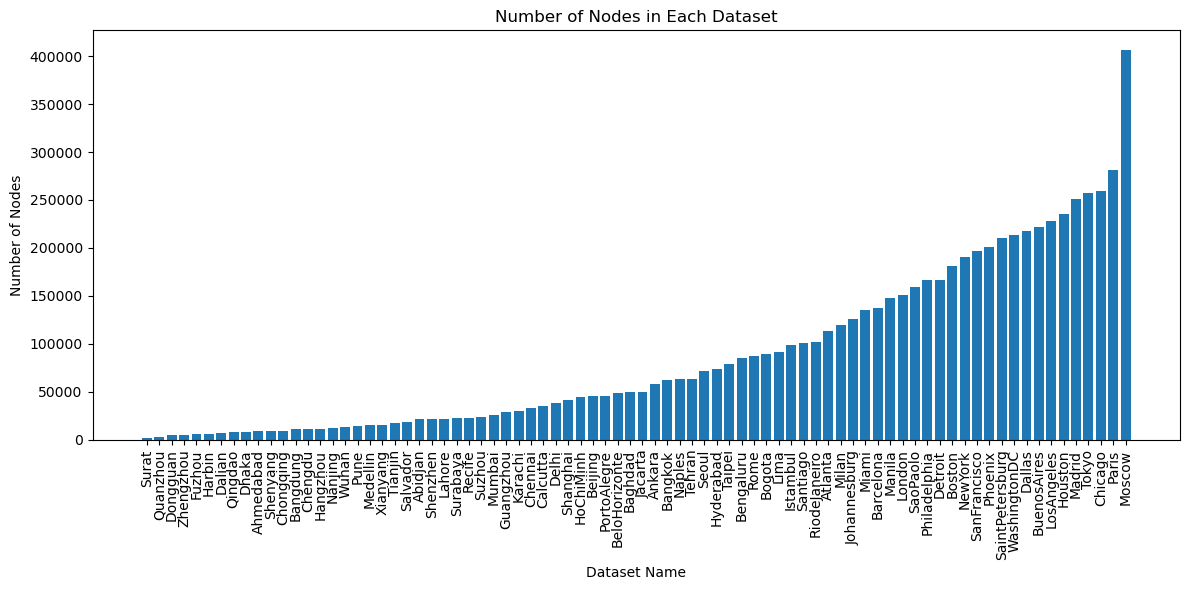

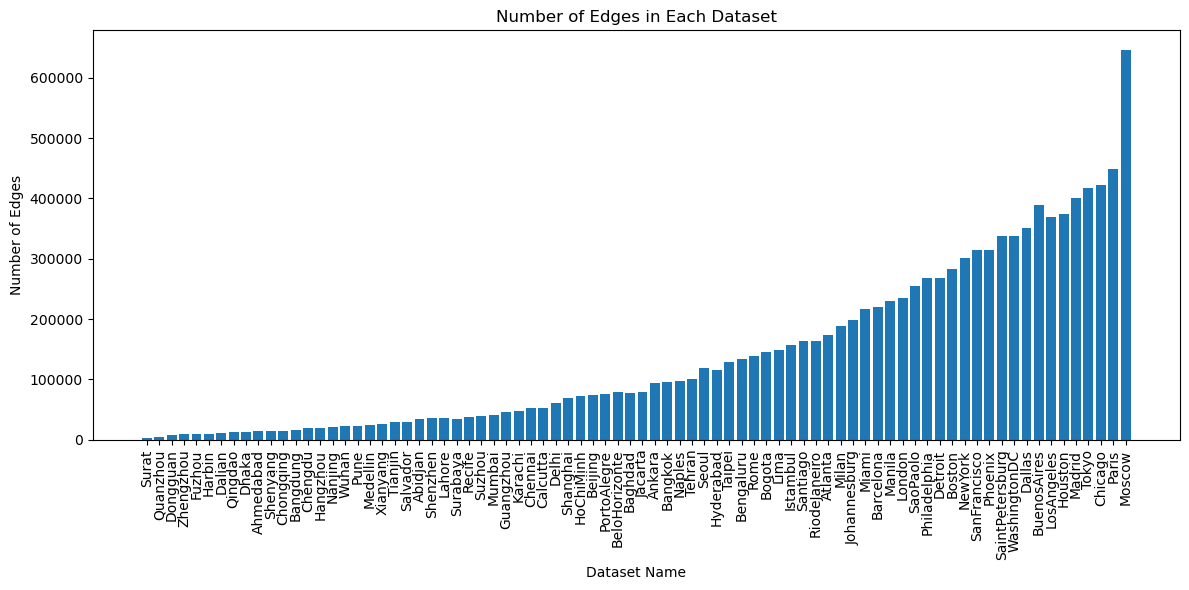

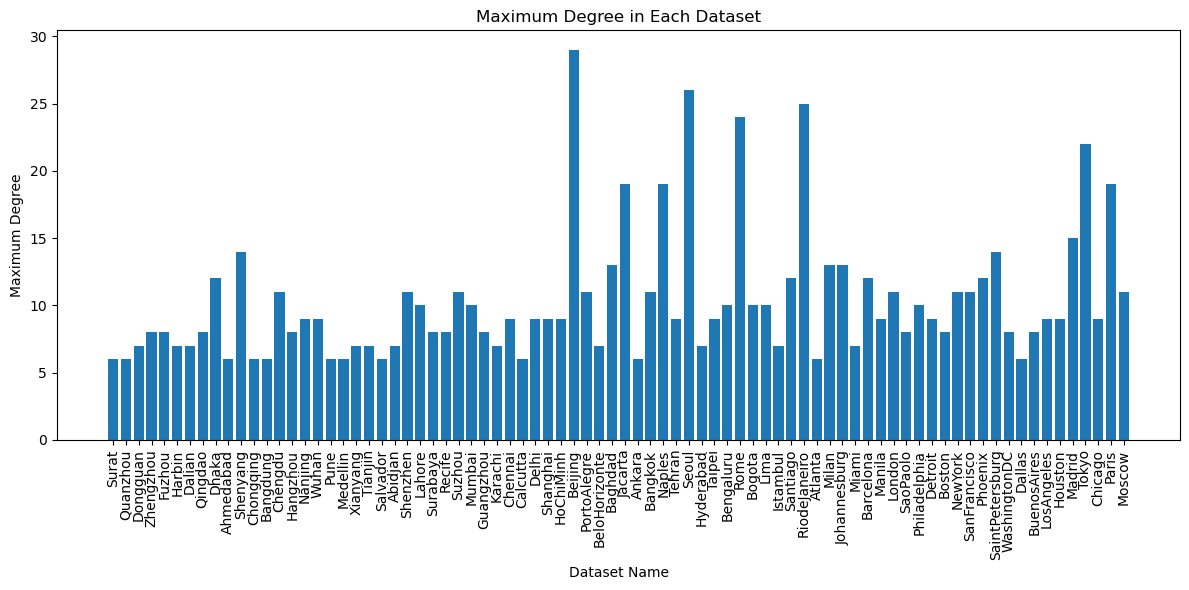

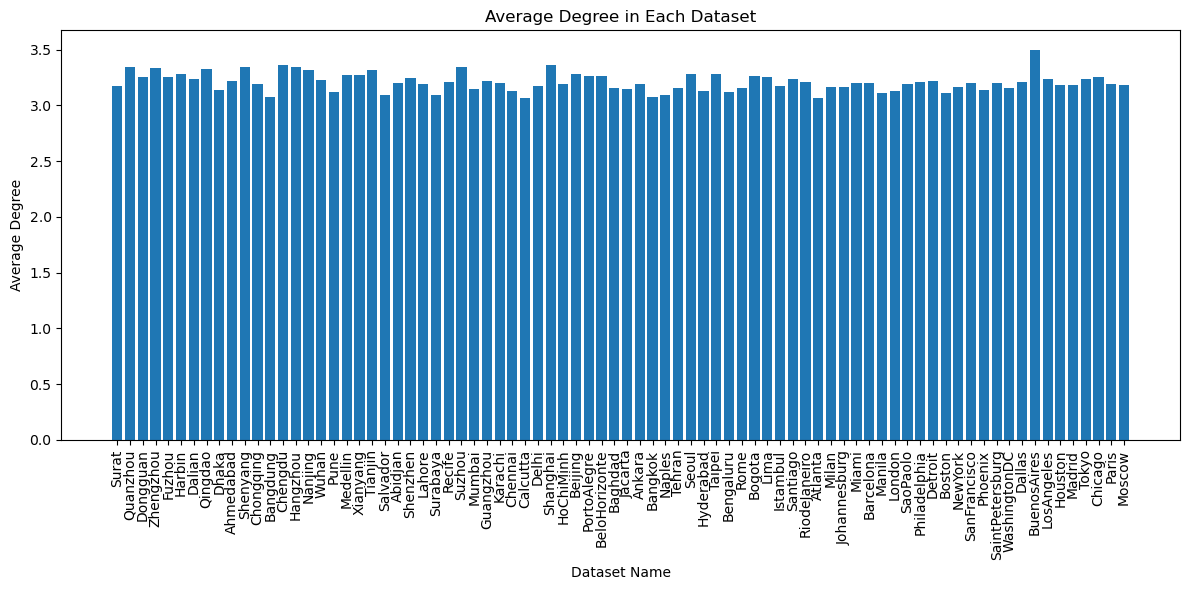

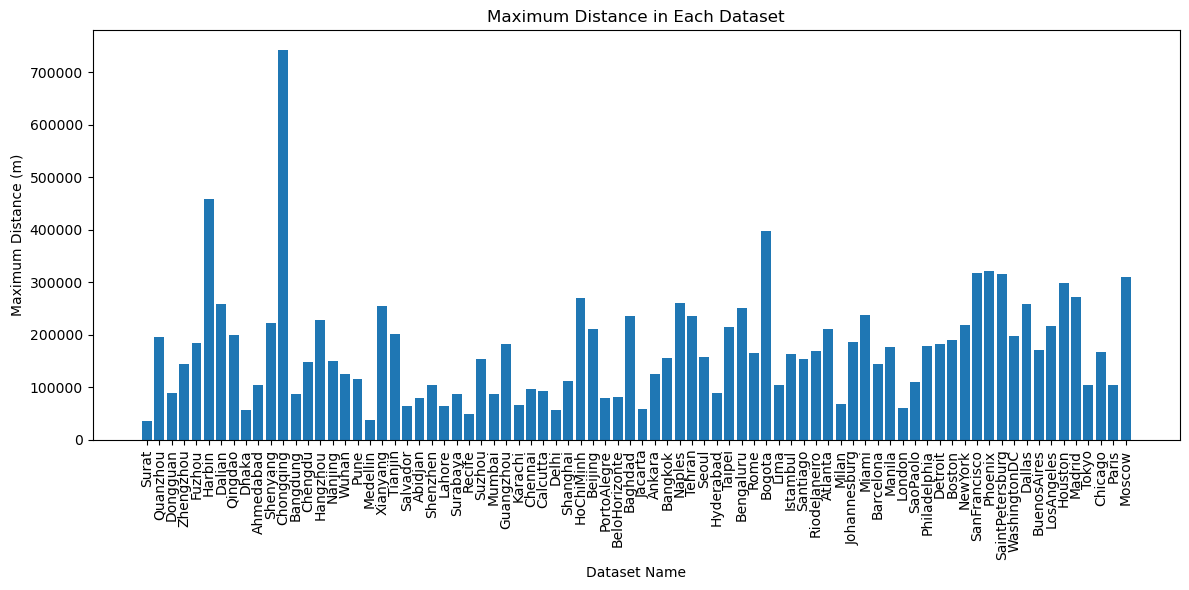

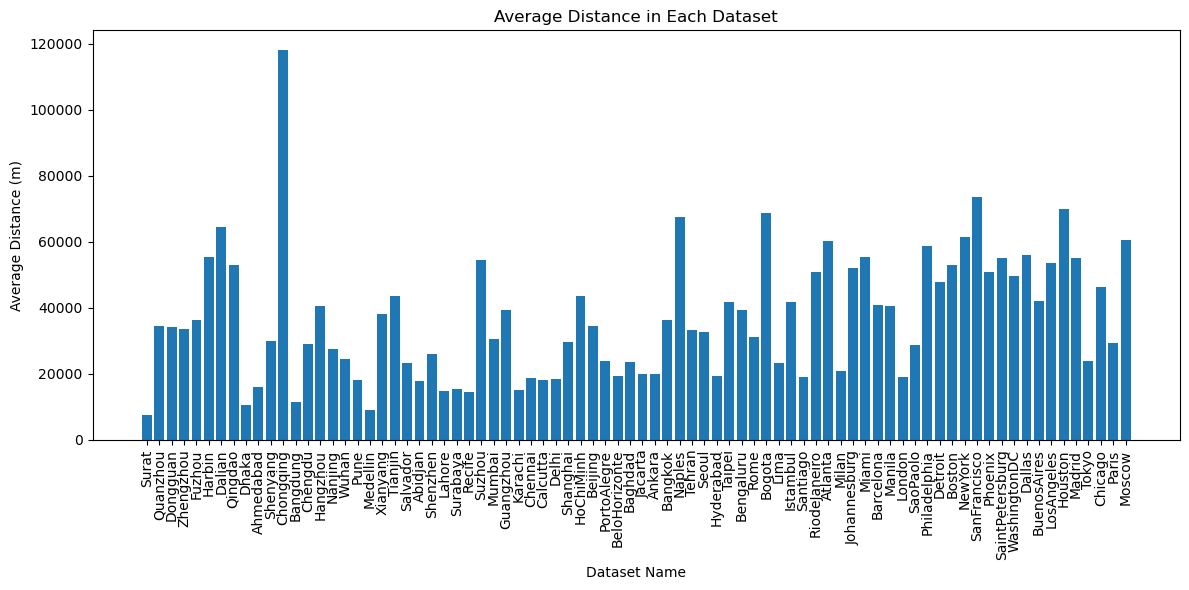

In [6]:
def plot_bar_chart(data, x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(12, 6))
    ax = plt.bar(data[x_col], data[y_col])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.tight_layout()
    # plt.show()
    return ax

plot_bar_chart(datasets, 'Dataset Name', 'Nodes', 'Number of Nodes in Each Dataset', 'Dataset Name', 'Number of Nodes')
plot_bar_chart(datasets, 'Dataset Name', 'Edges', 'Number of Edges in Each Dataset', 'Dataset Name', 'Number of Edges')
plot_bar_chart(datasets, 'Dataset Name', 'Max Degree', 'Maximum Degree in Each Dataset', 'Dataset Name', 'Maximum Degree')
plot_bar_chart(datasets, 'Dataset Name', 'Avg Degree', 'Average Degree in Each Dataset', 'Dataset Name', 'Average Degree')
plot_bar_chart(datasets, 'Dataset Name', 'Max Distance (m)', 'Maximum Distance in Each Dataset', 'Dataset Name', 'Maximum Distance (m)')
plot_bar_chart(datasets, 'Dataset Name', 'Avg Distance (m)', 'Average Distance in Each Dataset', 'Dataset Name', 'Average Distance (m)')

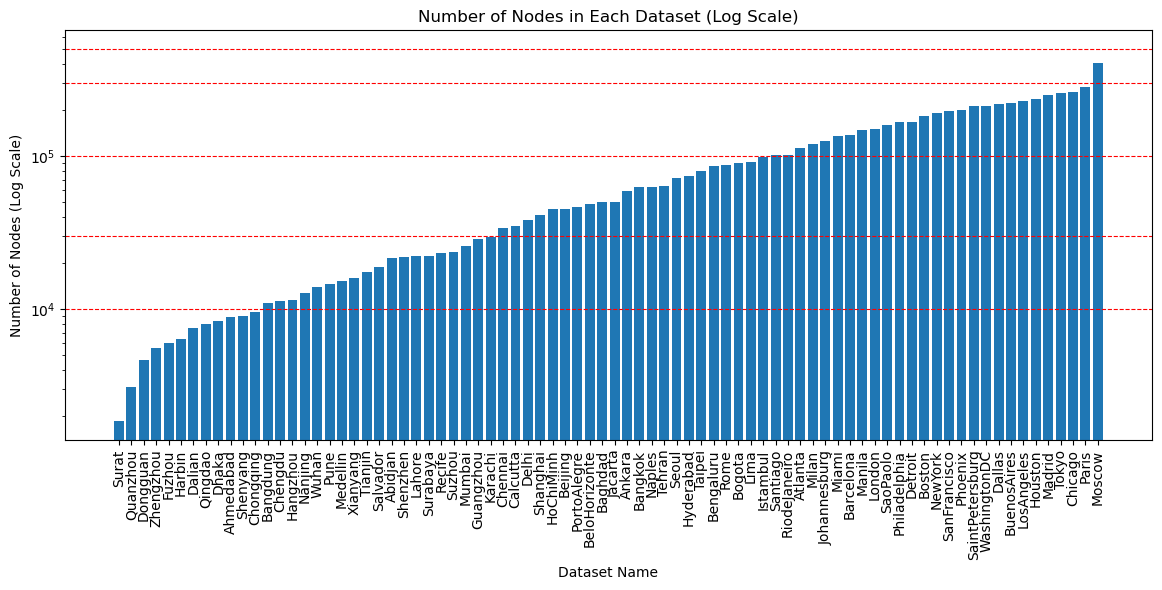

In [13]:
plot_bar_chart(datasets, 'Dataset Name', 'Nodes', 'Number of Nodes in Each Dataset', 'Dataset Name', 'Number of Nodes')
ax = plt.gca()
# for y in [10000, 25000, 50000, 75000, 100000, 150000, 200000, 400000]:
for y in [10000, 30000, 100000, 300000, 500000]:
    ax.axhline(y=y, color='r', linestyle='--', linewidth=0.8)
# show a log scale
plt.yscale('log')
plt.title('Number of Nodes in Each Dataset (Log Scale)')
plt.ylabel('Number of Nodes (Log Scale)')
plt.show()

In [ ]:
def categorize_size(nodes):
    if nodes < 5000:
        return 'Small'
    elif nodes < 50000:
        return 'Medium'
    elif nodes < 200000:
        return 'Large'
    else:
        return 'Extra Large'

datasets['Size Category'] = datasets['Nodes'].apply(categorize_size)
datasets[['Dataset Name', 'Nodes', 'Size Category']].head(20)

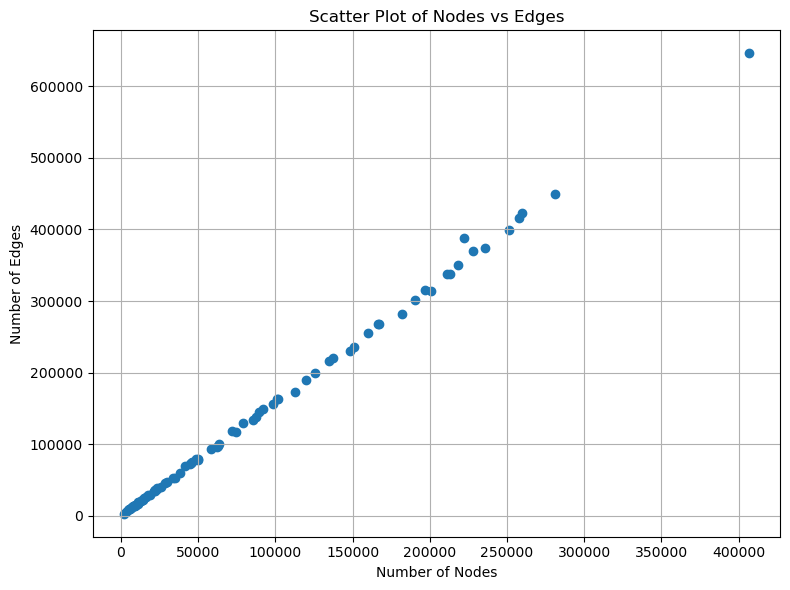

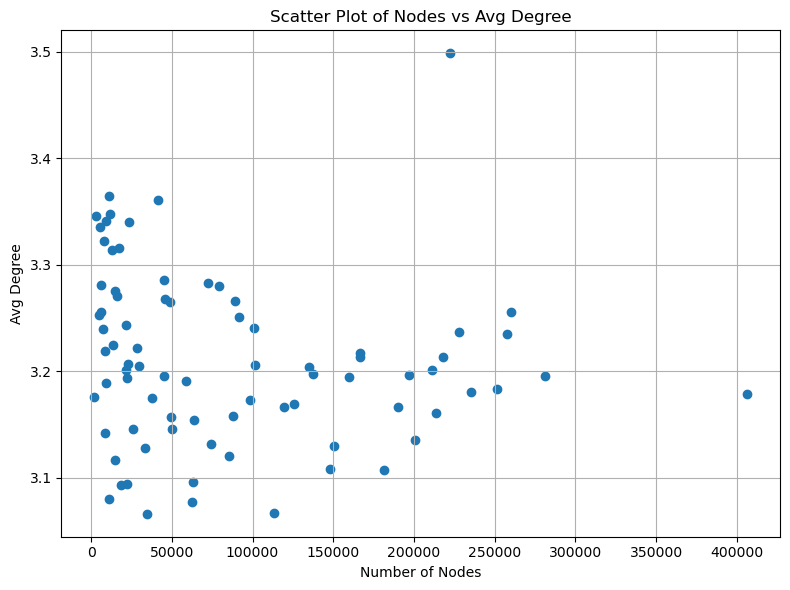

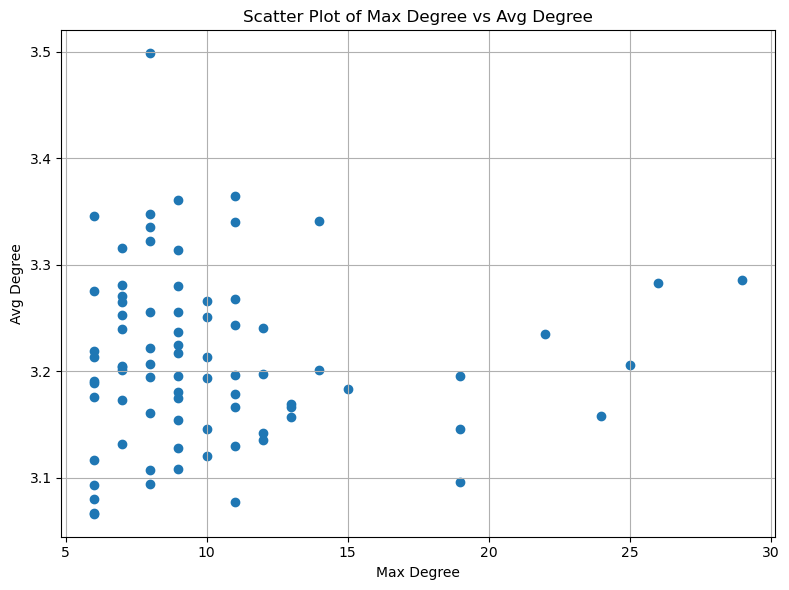

In [3]:
def plot_scatter_chart(data, x_col, y_col, title, xlabel, ylabel):
    plt.figure(figsize=(8, 6))
    plt.scatter(data[x_col], data[y_col])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_scatter_chart(datasets, 'Nodes', 'Edges', 'Scatter Plot of Nodes vs Edges', 'Number of Nodes', 'Number of Edges')
plot_scatter_chart(datasets, 'Nodes', 'Avg Degree', 'Scatter Plot of Nodes vs Avg Degree', 'Number of Nodes', 'Avg Degree')
plot_scatter_chart(datasets, 'Max Degree', 'Avg Degree', 'Scatter Plot of Max Degree vs Avg Degree', 'Max Degree', 'Avg Degree')